# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.10.0+cu111
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2021-11-23 06:51:20--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.51MB/s    in 0.9s    

2021-11-23 06:51:22 (2.51 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path, save='harry_potter_chars'):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = " ".join(data.split())

    voc2ind = {}
    out = []

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        pass # TODO Fill this in
        if char not in voc2ind:
          idx = len(voc2ind)
          voc2ind[char] = idx 
        out.append(voc2ind[char])


    ind2voc = {val: key for key, val in voc2ind.items()}

    size = int(len(out) * 0.8)
    train_text = np.array(out[:size]) # TODO Fill this in
    test_text = np.array(out[size:]) # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + save + '_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + save + '_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        # self.ind2voc = dataset['ind2voc']
        # self.voc2ind = dataset['voc2ind']

        self.len = int(((len(self.tokens) - 1) // self.sequence_length // self.batch_size) * self.batch_size)
        # self.batch_len = int(self.len / self.batch_size * self.sequence_length)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return self.len
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        start = self.sequence_length * idx
        data = self.tokens[start : start+self.sequence_length]
        label = self.tokens[start+1 : start+self.sequence_length+1]
        # data = []
        # label = []
        # for i in range(self.batch_size):
        #   start = int(i * self.batch_len + idx * self.sequence_length)
        #   data.append(self.tokens[start : start+self.sequence_length])
        #   label.append(self.tokens[start+1 : start+self.sequence_length+1])
        
        # data = np.stack(data)
        # print(data)
        # label = np.stack(label)
        return data, label

    def vocab_size(self):
        return len(self.vocab)


# SEQUENCE_LENGTH = 100
# BATCH_SIZE = 256
# data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
# l = len(data_train)
# print(l)
# x, label = data_train[l-1]
# print(x, label)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state) 
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 0.5
BEAM_WIDTH = 5

def max_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []
    for ii in range(sequence_length):
        next = int(torch.argmax(output))
        outputs.append(next)
        next = torch.as_tensor(next).to(device)
        output, hidden = model.inference(next, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device):
    outputs = []
    for ii in range(sequence_length):
        next = int(torch.multinomial(output, 1))
        outputs.append(next)
        next = torch.as_tensor(next).to(device)
        output, hidden = model.inference(next, hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device):
    outputs = []
    beam = []
    #beam = [([], output, hidden, 0)]
    
    def my_log(p):
      if p <= 0:
        return float('-inf')
      else:
        return math.log(p)

    # initialize
    for idx in range(len(vocab)):
      prob = float(output[0][idx])
      entry = ([idx], torch.as_tensor(idx).to(device), hidden, my_log(prob))
      beam.append(entry)
    beam.sort(reverse=True, key=lambda tup: tup[3])
    beam = beam[:BEAM_WIDTH]
    
    # generate
    for ii in range(sequence_length-1):
        print(f'generating {ii}')
        new_beam = []
        for chars, last_char, h, log_prob in beam:
          next_o, next_h = model.inference(last_char, h)
          for idx in range(len(vocab)):
            new_output = chars.copy()
            new_output.append(idx)
            new_prob = float(next_o[0][idx])
            entry = (new_output, torch.as_tensor(idx).to(device), next_h, my_log(new_prob) + log_prob)
            new_beam.append(entry)
        new_beam.sort(reverse=True, key=lambda tup: tup[3])
        beam = new_beam[:BEAM_WIDTH]

    return beam[0][0]


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)
        

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	hl;6661 ppq?lV7Il;xh_zElVVV/7Up  pWWzV666zl?h;;;;)p Vkl/Wh_&&)))QWWpV/E&J)  Ij}  ,66Om v0pl7 pV/El V


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	l pWllXX&lmWLn6WllWWzVkkNilppq?ilnwiiNWWzlW6'Bl6lzkl;xEllBlVliWWJiWWWii6Xlll//lliVpp hp;xWWJE7J pWW;


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	;Wz8H'/nD nwiz /Q66WppzqlNNzIUU pkplp1&z`//z;l?hp ?6nD;&&))Q z6l/n2zzjvNNzIlvWWzzEli  ^WWv;/5/zElEnp


Input	erha

  1%|          | 2/194 [00:00<00:38,  5.04it/s]

Train Epoch: 0 [0/49664 (0%)]	Loss: 15.747040


  6%|▌         | 12/194 [00:01<00:28,  6.44it/s]

Train Epoch: 0 [2560/49664 (5%)]	Loss: 12.258097


 11%|█▏        | 22/194 [00:03<00:26,  6.57it/s]

Train Epoch: 0 [5120/49664 (10%)]	Loss: 6.588701


 16%|█▋        | 32/194 [00:05<00:24,  6.51it/s]

Train Epoch: 0 [7680/49664 (15%)]	Loss: 4.125486


 22%|██▏       | 42/194 [00:06<00:23,  6.49it/s]

Train Epoch: 0 [10240/49664 (21%)]	Loss: 2.989839


 27%|██▋       | 52/194 [00:08<00:22,  6.28it/s]

Train Epoch: 0 [12800/49664 (26%)]	Loss: 3.126047


 32%|███▏      | 62/194 [00:09<00:22,  5.74it/s]

Train Epoch: 0 [15360/49664 (31%)]	Loss: 2.825656


 37%|███▋      | 72/194 [00:11<00:18,  6.49it/s]

Train Epoch: 0 [17920/49664 (36%)]	Loss: 2.855570


 42%|████▏     | 82/194 [00:13<00:17,  6.39it/s]

Train Epoch: 0 [20480/49664 (41%)]	Loss: 2.453955


 47%|████▋     | 92/194 [00:14<00:15,  6.56it/s]

Train Epoch: 0 [23040/49664 (46%)]	Loss: 2.385824


 53%|█████▎    | 102/194 [00:16<00:14,  6.27it/s]

Train Epoch: 0 [25600/49664 (52%)]	Loss: 2.428917


 58%|█████▊    | 112/194 [00:17<00:12,  6.42it/s]

Train Epoch: 0 [28160/49664 (57%)]	Loss: 2.614736


 63%|██████▎   | 122/194 [00:19<00:11,  6.49it/s]

Train Epoch: 0 [30720/49664 (62%)]	Loss: 2.454134


 68%|██████▊   | 132/194 [00:20<00:09,  6.49it/s]

Train Epoch: 0 [33280/49664 (67%)]	Loss: 2.283558


 73%|███████▎  | 142/194 [00:22<00:08,  6.44it/s]

Train Epoch: 0 [35840/49664 (72%)]	Loss: 2.117624


 78%|███████▊  | 152/194 [00:23<00:06,  6.50it/s]

Train Epoch: 0 [38400/49664 (77%)]	Loss: 2.889761


 84%|████████▎ | 162/194 [00:25<00:05,  6.36it/s]

Train Epoch: 0 [40960/49664 (82%)]	Loss: 2.532216


 89%|████████▊ | 172/194 [00:27<00:03,  6.24it/s]

Train Epoch: 0 [43520/49664 (88%)]	Loss: 2.237855


 94%|█████████▍| 182/194 [00:28<00:02,  5.72it/s]

Train Epoch: 0 [46080/49664 (93%)]	Loss: 1.996500


 99%|█████████▉| 192/194 [00:30<00:00,  6.46it/s]

Train Epoch: 0 [48640/49664 (98%)]	Loss: 1.880095


100%|██████████| 194/194 [00:30<00:00,  6.33it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsiialeihmhttn  soss d t ain   ihe mone   aasl  .Y dnesarre .. He said  HYon't saudy  'itl  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she semm tehor  we wrnshe hhtht nn the sooacer  tolnys tn tnbel toen biom tes  hiit i  e s tt the se


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 l  ieon sn soumloss og ted    but thme hing his tiiu   .. Ie mione s 'edd salned th te tiig ng tnt 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:44,  4.35it/s]

Train Epoch: 1 [0/49664 (0%)]	Loss: 1.900860


  6%|▌         | 12/194 [00:02<00:30,  6.06it/s]

Train Epoch: 1 [2560/49664 (5%)]	Loss: 2.006603


 11%|█▏        | 22/194 [00:03<00:26,  6.58it/s]

Train Epoch: 1 [5120/49664 (10%)]	Loss: 2.300194


 16%|█▋        | 32/194 [00:05<00:26,  6.07it/s]

Train Epoch: 1 [7680/49664 (15%)]	Loss: 2.008789


 22%|██▏       | 42/194 [00:06<00:23,  6.54it/s]

Train Epoch: 1 [10240/49664 (21%)]	Loss: 1.814960


 27%|██▋       | 52/194 [00:08<00:21,  6.60it/s]

Train Epoch: 1 [12800/49664 (26%)]	Loss: 2.032950


 32%|███▏      | 62/194 [00:10<00:21,  6.26it/s]

Train Epoch: 1 [15360/49664 (31%)]	Loss: 2.085114


 37%|███▋      | 72/194 [00:11<00:18,  6.47it/s]

Train Epoch: 1 [17920/49664 (36%)]	Loss: 1.981524


 42%|████▏     | 82/194 [00:13<00:17,  6.37it/s]

Train Epoch: 1 [20480/49664 (41%)]	Loss: 1.746211


 47%|████▋     | 92/194 [00:14<00:15,  6.51it/s]

Train Epoch: 1 [23040/49664 (46%)]	Loss: 1.719785


 53%|█████▎    | 102/194 [00:16<00:14,  6.53it/s]

Train Epoch: 1 [25600/49664 (52%)]	Loss: 1.779617


 58%|█████▊    | 112/194 [00:17<00:12,  6.36it/s]

Train Epoch: 1 [28160/49664 (57%)]	Loss: 1.847543


 63%|██████▎   | 122/194 [00:19<00:11,  6.22it/s]

Train Epoch: 1 [30720/49664 (62%)]	Loss: 1.747692


 68%|██████▊   | 132/194 [00:20<00:10,  6.12it/s]

Train Epoch: 1 [33280/49664 (67%)]	Loss: 1.914856


 73%|███████▎  | 142/194 [00:22<00:08,  6.18it/s]

Train Epoch: 1 [35840/49664 (72%)]	Loss: 1.910249


 78%|███████▊  | 152/194 [00:24<00:06,  6.56it/s]

Train Epoch: 1 [38400/49664 (77%)]	Loss: 2.050485


 84%|████████▎ | 162/194 [00:25<00:05,  6.39it/s]

Train Epoch: 1 [40960/49664 (82%)]	Loss: 2.129771


 89%|████████▊ | 172/194 [00:27<00:03,  6.45it/s]

Train Epoch: 1 [43520/49664 (88%)]	Loss: 1.874866


 94%|█████████▍| 182/194 [00:28<00:01,  6.40it/s]

Train Epoch: 1 [46080/49664 (93%)]	Loss: 1.748082


 99%|█████████▉| 192/194 [00:30<00:00,  6.38it/s]

Train Epoch: 1 [48640/49664 (98%)]	Loss: 1.755737


100%|██████████| 194/194 [00:30<00:00,  6.27it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rwriat oodhtt d woar d o ains  the doue   aask  HHtws aarri .. He said  HHob't sauky, aode" said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe seom we ore we wonlht ohdht hu the wooac r  woliid on tntew toet tiom tis  aoit a  e   wn the pr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  ieon sf poumlotsiog tevd   aut thme hing sis aaiug  .. we mione s aedd saened to be aaig ng tut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:44,  4.31it/s]

Train Epoch: 2 [0/49664 (0%)]	Loss: 1.687225


  6%|▌         | 12/194 [00:02<00:29,  6.16it/s]

Train Epoch: 2 [2560/49664 (5%)]	Loss: 1.689549


 11%|█▏        | 22/194 [00:03<00:26,  6.40it/s]

Train Epoch: 2 [5120/49664 (10%)]	Loss: 1.759226


 16%|█▋        | 32/194 [00:05<00:25,  6.28it/s]

Train Epoch: 2 [7680/49664 (15%)]	Loss: 1.651804


 22%|██▏       | 42/194 [00:06<00:24,  6.32it/s]

Train Epoch: 2 [10240/49664 (21%)]	Loss: 1.568385


 27%|██▋       | 52/194 [00:08<00:21,  6.49it/s]

Train Epoch: 2 [12800/49664 (26%)]	Loss: 1.649886


 32%|███▏      | 62/194 [00:09<00:20,  6.56it/s]

Train Epoch: 2 [15360/49664 (31%)]	Loss: 1.688589


 37%|███▋      | 72/194 [00:11<00:19,  6.29it/s]

Train Epoch: 2 [17920/49664 (36%)]	Loss: 1.732889


 42%|████▏     | 82/194 [00:12<00:17,  6.42it/s]

Train Epoch: 2 [20480/49664 (41%)]	Loss: 1.581985


 47%|████▋     | 92/194 [00:14<00:16,  6.35it/s]

Train Epoch: 2 [23040/49664 (46%)]	Loss: 1.653201


 53%|█████▎    | 102/194 [00:16<00:14,  6.42it/s]

Train Epoch: 2 [25600/49664 (52%)]	Loss: 1.622240


 58%|█████▊    | 112/194 [00:17<00:13,  6.22it/s]

Train Epoch: 2 [28160/49664 (57%)]	Loss: 1.730164


 63%|██████▎   | 122/194 [00:19<00:11,  6.39it/s]

Train Epoch: 2 [30720/49664 (62%)]	Loss: 1.643533


 68%|██████▊   | 132/194 [00:21<00:09,  6.52it/s]

Train Epoch: 2 [33280/49664 (67%)]	Loss: 1.780249


 73%|███████▎  | 142/194 [00:22<00:08,  6.44it/s]

Train Epoch: 2 [35840/49664 (72%)]	Loss: 1.653697


 78%|███████▊  | 152/194 [00:24<00:06,  6.18it/s]

Train Epoch: 2 [38400/49664 (77%)]	Loss: 1.702833


 84%|████████▎ | 162/194 [00:25<00:05,  6.31it/s]

Train Epoch: 2 [40960/49664 (82%)]	Loss: 1.724395


 89%|████████▊ | 172/194 [00:27<00:03,  6.47it/s]

Train Epoch: 2 [43520/49664 (88%)]	Loss: 1.639081


 94%|█████████▍| 182/194 [00:28<00:01,  6.48it/s]

Train Epoch: 2 [46080/49664 (93%)]	Loss: 1.614877


 99%|█████████▉| 192/194 [00:30<00:00,  6.40it/s]

Train Epoch: 2 [48640/49664 (98%)]	Loss: 1.590541


100%|██████████| 194/194 [00:30<00:00,  6.26it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsraat ohghttnd soar d o ain   the pole   oask  HHtdm sarri .. He said  HHon't sauky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe reom wehore hi dousht ohght hu the booat re oolsos on t rew oael iiom tis  arct i  eyp wn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  iion of poumlossiog oird   aut hhme hing sis siing  .. Ie mione s sadd saemed to se aiig ng out 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:42,  4.51it/s]

Train Epoch: 3 [0/49664 (0%)]	Loss: 1.583091


  6%|▌         | 12/194 [00:02<00:29,  6.09it/s]

Train Epoch: 3 [2560/49664 (5%)]	Loss: 1.618716


 11%|█▏        | 22/194 [00:03<00:26,  6.53it/s]

Train Epoch: 3 [5120/49664 (10%)]	Loss: 1.692100


 16%|█▋        | 32/194 [00:05<00:26,  6.16it/s]

Train Epoch: 3 [7680/49664 (15%)]	Loss: 1.594420


 22%|██▏       | 42/194 [00:06<00:23,  6.47it/s]

Train Epoch: 3 [10240/49664 (21%)]	Loss: 1.514672


 27%|██▋       | 52/194 [00:08<00:22,  6.41it/s]

Train Epoch: 3 [12800/49664 (26%)]	Loss: 1.645742


 32%|███▏      | 62/194 [00:09<00:21,  6.18it/s]

Train Epoch: 3 [15360/49664 (31%)]	Loss: 1.639915


 37%|███▋      | 72/194 [00:11<00:19,  6.27it/s]

Train Epoch: 3 [17920/49664 (36%)]	Loss: 1.648282


 42%|████▏     | 82/194 [00:13<00:17,  6.27it/s]

Train Epoch: 3 [20480/49664 (41%)]	Loss: 1.526136


 47%|████▋     | 92/194 [00:14<00:15,  6.45it/s]

Train Epoch: 3 [23040/49664 (46%)]	Loss: 1.537578


 53%|█████▎    | 102/194 [00:16<00:13,  6.61it/s]

Train Epoch: 3 [25600/49664 (52%)]	Loss: 1.494805


 58%|█████▊    | 112/194 [00:17<00:12,  6.38it/s]

Train Epoch: 3 [28160/49664 (57%)]	Loss: 1.578752


 63%|██████▎   | 122/194 [00:19<00:11,  6.11it/s]

Train Epoch: 3 [30720/49664 (62%)]	Loss: 1.509004


 68%|██████▊   | 132/194 [00:21<00:09,  6.46it/s]

Train Epoch: 3 [33280/49664 (67%)]	Loss: 1.687673


 73%|███████▎  | 142/194 [00:22<00:08,  6.47it/s]

Train Epoch: 3 [35840/49664 (72%)]	Loss: 1.607237


 78%|███████▊  | 151/194 [00:24<00:06,  6.16it/s]

Train Epoch: 3 [38400/49664 (77%)]	Loss: 1.577737


 84%|████████▎ | 162/194 [00:25<00:04,  6.41it/s]

Train Epoch: 3 [40960/49664 (82%)]	Loss: 1.649913


 89%|████████▊ | 172/194 [00:27<00:03,  6.14it/s]

Train Epoch: 3 [43520/49664 (88%)]	Loss: 1.560992


 94%|█████████▍| 182/194 [00:29<00:01,  6.49it/s]

Train Epoch: 3 [46080/49664 (93%)]	Loss: 1.536573


 99%|█████████▉| 192/194 [00:30<00:00,  6.50it/s]

Train Epoch: 3 [48640/49664 (98%)]	Loss: 1.527225


100%|██████████| 194/194 [00:30<00:00,  6.27it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsraat opdhtt d soav d t ain t the pole   oasl  HTttm talri... He said  "Ion't yauky  Iar," said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe room wehore te collht thdht hf the cooat re tottes on t few taet aiom tis  aact a  eep wn the ca


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 l  iion af toumlotsiog tivd   aut hhme hing tas taing  .  we mione s aadd taemed to be aaig ng tut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:45,  4.25it/s]

Train Epoch: 4 [0/49664 (0%)]	Loss: 1.518378


  6%|▌         | 12/194 [00:02<00:29,  6.21it/s]

Train Epoch: 4 [2560/49664 (5%)]	Loss: 1.550086


 11%|█▏        | 22/194 [00:03<00:26,  6.45it/s]

Train Epoch: 4 [5120/49664 (10%)]	Loss: 1.620364


 16%|█▋        | 32/194 [00:05<00:25,  6.29it/s]

Train Epoch: 4 [7680/49664 (15%)]	Loss: 1.530837


 22%|██▏       | 42/194 [00:06<00:23,  6.59it/s]

Train Epoch: 4 [10240/49664 (21%)]	Loss: 1.443430


 27%|██▋       | 52/194 [00:08<00:22,  6.29it/s]

Train Epoch: 4 [12800/49664 (26%)]	Loss: 1.523361


 32%|███▏      | 62/194 [00:09<00:20,  6.50it/s]

Train Epoch: 4 [15360/49664 (31%)]	Loss: 1.558085


 37%|███▋      | 72/194 [00:11<00:19,  6.39it/s]

Train Epoch: 4 [17920/49664 (36%)]	Loss: 1.589346


 42%|████▏     | 82/194 [00:13<00:17,  6.30it/s]

Train Epoch: 4 [20480/49664 (41%)]	Loss: 1.484386


 47%|████▋     | 92/194 [00:14<00:15,  6.43it/s]

Train Epoch: 4 [23040/49664 (46%)]	Loss: 1.473196


 53%|█████▎    | 102/194 [00:16<00:13,  6.61it/s]

Train Epoch: 4 [25600/49664 (52%)]	Loss: 1.425235


 58%|█████▊    | 112/194 [00:17<00:13,  6.29it/s]

Train Epoch: 4 [28160/49664 (57%)]	Loss: 1.526439


 63%|██████▎   | 122/194 [00:19<00:11,  6.40it/s]

Train Epoch: 4 [30720/49664 (62%)]	Loss: 1.456479


 68%|██████▊   | 132/194 [00:20<00:09,  6.39it/s]

Train Epoch: 4 [33280/49664 (67%)]	Loss: 1.633330


 73%|███████▎  | 142/194 [00:22<00:08,  6.40it/s]

Train Epoch: 4 [35840/49664 (72%)]	Loss: 1.518487


 78%|███████▊  | 152/194 [00:23<00:06,  6.32it/s]

Train Epoch: 4 [38400/49664 (77%)]	Loss: 1.516559


 84%|████████▎ | 162/194 [00:25<00:05,  6.38it/s]

Train Epoch: 4 [40960/49664 (82%)]	Loss: 1.612966


 89%|████████▊ | 172/194 [00:27<00:03,  6.43it/s]

Train Epoch: 4 [43520/49664 (88%)]	Loss: 1.530649


 94%|█████████▍| 182/194 [00:28<00:01,  6.34it/s]

Train Epoch: 4 [46080/49664 (93%)]	Loss: 1.513180


 99%|█████████▉| 192/194 [00:30<00:00,  6.33it/s]

Train Epoch: 4 [48640/49664 (98%)]	Loss: 1.499266


100%|██████████| 194/194 [00:30<00:00,  6.33it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsiaat opdntt d soavid t ain t the pose  ooasl  HTttm salri..  He said  HIon't sauky  Iar,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she soom wehore te doslht thght hf the pooam re toried on t rew oaet tiom tis  aict t  eep wn the ca


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  iion af toumlotsiog tivd   aut thmething tis saing  .  we mione s aedd taemed to be ttid ng tut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:44,  4.35it/s]

Train Epoch: 5 [0/49664 (0%)]	Loss: 1.491663


  6%|▌         | 12/194 [00:02<00:29,  6.08it/s]

Train Epoch: 5 [2560/49664 (5%)]	Loss: 1.511295


 11%|█▏        | 22/194 [00:03<00:26,  6.44it/s]

Train Epoch: 5 [5120/49664 (10%)]	Loss: 1.571788


 16%|█▋        | 32/194 [00:05<00:25,  6.44it/s]

Train Epoch: 5 [7680/49664 (15%)]	Loss: 1.496183


 22%|██▏       | 42/194 [00:06<00:23,  6.50it/s]

Train Epoch: 5 [10240/49664 (21%)]	Loss: 1.412677


 27%|██▋       | 52/194 [00:08<00:21,  6.48it/s]

Train Epoch: 5 [12800/49664 (26%)]	Loss: 1.503925


 32%|███▏      | 62/194 [00:10<00:23,  5.68it/s]

Train Epoch: 5 [15360/49664 (31%)]	Loss: 1.525622


 37%|███▋      | 71/194 [00:11<00:23,  5.15it/s]

Train Epoch: 5 [17920/49664 (36%)]	Loss: 1.551327


 42%|████▏     | 82/194 [00:13<00:17,  6.26it/s]

Train Epoch: 5 [20480/49664 (41%)]	Loss: 1.432865


 47%|████▋     | 92/194 [00:15<00:15,  6.43it/s]

Train Epoch: 5 [23040/49664 (46%)]	Loss: 1.428277


 53%|█████▎    | 102/194 [00:16<00:14,  6.43it/s]

Train Epoch: 5 [25600/49664 (52%)]	Loss: 1.367493


 58%|█████▊    | 112/194 [00:18<00:12,  6.37it/s]

Train Epoch: 5 [28160/49664 (57%)]	Loss: 1.483756


 63%|██████▎   | 122/194 [00:19<00:12,  5.92it/s]

Train Epoch: 5 [30720/49664 (62%)]	Loss: 1.417058


 68%|██████▊   | 131/194 [00:21<00:10,  6.17it/s]

Train Epoch: 5 [33280/49664 (67%)]	Loss: 1.584068


 73%|███████▎  | 142/194 [00:23<00:07,  6.50it/s]

Train Epoch: 5 [35840/49664 (72%)]	Loss: 1.475717


 78%|███████▊  | 152/194 [00:24<00:06,  6.34it/s]

Train Epoch: 5 [38400/49664 (77%)]	Loss: 1.494760


 84%|████████▎ | 162/194 [00:26<00:05,  6.23it/s]

Train Epoch: 5 [40960/49664 (82%)]	Loss: 1.568740


 89%|████████▊ | 172/194 [00:27<00:03,  6.51it/s]

Train Epoch: 5 [43520/49664 (88%)]	Loss: 1.485841


 94%|█████████▍| 182/194 [00:29<00:01,  6.48it/s]

Train Epoch: 5 [46080/49664 (93%)]	Loss: 1.475817


 99%|█████████▉| 192/194 [00:31<00:00,  6.53it/s]

Train Epoch: 5 [48640/49664 (98%)]	Loss: 1.471903


100%|██████████| 194/194 [00:31<00:00,  6.19it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoiat ohdnttnd soavid t ain t the sose  ooisk  HI tm silri .  He said  "Io 't sauky  Iir,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she soom wehore te wossht ththt hf the sooat re woriod op t sew oeet trom tis  toct t  eep wn the so


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  iion of toumlotsiog tevd   wut thme hing tis siing  .  we mione s sedd whemed to se ttid ng tft 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:45,  4.25it/s]

Train Epoch: 6 [0/49664 (0%)]	Loss: 1.481009


  6%|▌         | 12/194 [00:02<00:29,  6.16it/s]

Train Epoch: 6 [2560/49664 (5%)]	Loss: 1.492243


 11%|█▏        | 22/194 [00:03<00:27,  6.36it/s]

Train Epoch: 6 [5120/49664 (10%)]	Loss: 1.535349


 16%|█▋        | 32/194 [00:05<00:24,  6.49it/s]

Train Epoch: 6 [7680/49664 (15%)]	Loss: 1.475260


 22%|██▏       | 42/194 [00:06<00:23,  6.57it/s]

Train Epoch: 6 [10240/49664 (21%)]	Loss: 1.413169


 27%|██▋       | 52/194 [00:08<00:22,  6.27it/s]

Train Epoch: 6 [12800/49664 (26%)]	Loss: 1.469839


 32%|███▏      | 62/194 [00:09<00:20,  6.35it/s]

Train Epoch: 6 [15360/49664 (31%)]	Loss: 1.486620


 37%|███▋      | 72/194 [00:11<00:20,  5.92it/s]

Train Epoch: 6 [17920/49664 (36%)]	Loss: 1.526003


 42%|████▏     | 82/194 [00:13<00:17,  6.50it/s]

Train Epoch: 6 [20480/49664 (41%)]	Loss: 1.409738


 47%|████▋     | 92/194 [00:14<00:15,  6.46it/s]

Train Epoch: 6 [23040/49664 (46%)]	Loss: 1.404564


 53%|█████▎    | 102/194 [00:16<00:14,  6.50it/s]

Train Epoch: 6 [25600/49664 (52%)]	Loss: 1.366741


 58%|█████▊    | 112/194 [00:17<00:13,  6.29it/s]

Train Epoch: 6 [28160/49664 (57%)]	Loss: 1.471099


 63%|██████▎   | 122/194 [00:19<00:13,  5.31it/s]

Train Epoch: 6 [30720/49664 (62%)]	Loss: 1.394857


 68%|██████▊   | 132/194 [00:21<00:09,  6.54it/s]

Train Epoch: 6 [33280/49664 (67%)]	Loss: 1.556237


 73%|███████▎  | 142/194 [00:22<00:08,  6.48it/s]

Train Epoch: 6 [35840/49664 (72%)]	Loss: 1.454035


 78%|███████▊  | 152/194 [00:24<00:06,  6.53it/s]

Train Epoch: 6 [38400/49664 (77%)]	Loss: 1.460150


 84%|████████▎ | 162/194 [00:25<00:04,  6.49it/s]

Train Epoch: 6 [40960/49664 (82%)]	Loss: 1.511374


 89%|████████▊ | 172/194 [00:27<00:03,  6.50it/s]

Train Epoch: 6 [43520/49664 (88%)]	Loss: 1.456697


 94%|█████████▍| 182/194 [00:28<00:01,  6.11it/s]

Train Epoch: 6 [46080/49664 (93%)]	Loss: 1.445886


 99%|█████████▉| 192/194 [00:30<00:00,  6.45it/s]

Train Epoch: 6 [48640/49664 (98%)]	Loss: 1.451935


100%|██████████| 194/194 [00:30<00:00,  6.29it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoiat shdntond soavid t ain t the sose  ooask  "Ittm aalri".  "e said  "Iu  t sauky  Iir,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she soom wehore te wonsht ththt hf the cooat re ooried op t sew ooel aoom tis  toct t  eep wn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	    iion wf touplossiog tivd   wut th e hing tis saing  .  we mione s sevd waemed to be atip ng out 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:45,  4.22it/s]

Train Epoch: 7 [0/49664 (0%)]	Loss: 1.454127


  6%|▌         | 12/194 [00:02<00:29,  6.14it/s]

Train Epoch: 7 [2560/49664 (5%)]	Loss: 1.461001


 11%|█▏        | 22/194 [00:03<00:26,  6.41it/s]

Train Epoch: 7 [5120/49664 (10%)]	Loss: 1.501362


 16%|█▋        | 32/194 [00:05<00:24,  6.49it/s]

Train Epoch: 7 [7680/49664 (15%)]	Loss: 1.438888


 22%|██▏       | 42/194 [00:06<00:23,  6.57it/s]

Train Epoch: 7 [10240/49664 (21%)]	Loss: 1.376551


 27%|██▋       | 52/194 [00:08<00:22,  6.37it/s]

Train Epoch: 7 [12800/49664 (26%)]	Loss: 1.440825


 32%|███▏      | 62/194 [00:09<00:21,  6.20it/s]

Train Epoch: 7 [15360/49664 (31%)]	Loss: 1.460696


 37%|███▋      | 72/194 [00:11<00:20,  5.89it/s]

Train Epoch: 7 [17920/49664 (36%)]	Loss: 1.505096


 42%|████▏     | 81/194 [00:13<00:18,  6.11it/s]

Train Epoch: 7 [20480/49664 (41%)]	Loss: 1.399906


 47%|████▋     | 92/194 [00:14<00:15,  6.50it/s]

Train Epoch: 7 [23040/49664 (46%)]	Loss: 1.389016


 53%|█████▎    | 102/194 [00:16<00:14,  6.49it/s]

Train Epoch: 7 [25600/49664 (52%)]	Loss: 1.360330


 58%|█████▊    | 112/194 [00:18<00:14,  5.74it/s]

Train Epoch: 7 [28160/49664 (57%)]	Loss: 1.473907


 63%|██████▎   | 122/194 [00:19<00:12,  5.60it/s]

Train Epoch: 7 [30720/49664 (62%)]	Loss: 1.391419


 68%|██████▊   | 132/194 [00:21<00:09,  6.41it/s]

Train Epoch: 7 [33280/49664 (67%)]	Loss: 1.537795


 73%|███████▎  | 142/194 [00:22<00:08,  6.36it/s]

Train Epoch: 7 [35840/49664 (72%)]	Loss: 1.439088


 78%|███████▊  | 152/194 [00:24<00:06,  6.42it/s]

Train Epoch: 7 [38400/49664 (77%)]	Loss: 1.436285


 84%|████████▎ | 162/194 [00:26<00:05,  6.17it/s]

Train Epoch: 7 [40960/49664 (82%)]	Loss: 1.490603


 89%|████████▊ | 172/194 [00:27<00:03,  6.08it/s]

Train Epoch: 7 [43520/49664 (88%)]	Loss: 1.442790


 94%|█████████▍| 182/194 [00:29<00:01,  6.55it/s]

Train Epoch: 7 [46080/49664 (93%)]	Loss: 1.431361


 99%|█████████▉| 192/194 [00:30<00:00,  6.36it/s]

Train Epoch: 7 [48640/49664 (98%)]	Loss: 1.441279


100%|██████████| 194/194 [00:31<00:00,  6.20it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsriat stnhtond soavid tnain t the sose  ooasl  "I tm ailri".  "e said  "Iu 't sauky  tir,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she soom wehore te wonsht thght of the cooat resoorsed op t few ooel aoom tis  aoct ts eep wn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 l  tion wf toumlessiog tinds  aut thme hing tis saing  .  wa mione s sevd wae ed to be atip ng oft 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:43,  4.37it/s]

Train Epoch: 8 [0/49664 (0%)]	Loss: 1.437012


  6%|▌         | 12/194 [00:02<00:29,  6.12it/s]

Train Epoch: 8 [2560/49664 (5%)]	Loss: 1.454220


 11%|█▏        | 22/194 [00:03<00:26,  6.53it/s]

Train Epoch: 8 [5120/49664 (10%)]	Loss: 1.484089


 16%|█▋        | 32/194 [00:05<00:29,  5.46it/s]

Train Epoch: 8 [7680/49664 (15%)]	Loss: 1.422325


 22%|██▏       | 42/194 [00:06<00:23,  6.45it/s]

Train Epoch: 8 [10240/49664 (21%)]	Loss: 1.354181


 27%|██▋       | 52/194 [00:08<00:21,  6.48it/s]

Train Epoch: 8 [12800/49664 (26%)]	Loss: 1.424241


 32%|███▏      | 62/194 [00:10<00:20,  6.42it/s]

Train Epoch: 8 [15360/49664 (31%)]	Loss: 1.450625


 37%|███▋      | 72/194 [00:11<00:19,  6.28it/s]

Train Epoch: 8 [17920/49664 (36%)]	Loss: 1.490575


 42%|████▏     | 82/194 [00:13<00:17,  6.50it/s]

Train Epoch: 8 [20480/49664 (41%)]	Loss: 1.396357


 47%|████▋     | 92/194 [00:14<00:15,  6.51it/s]

Train Epoch: 8 [23040/49664 (46%)]	Loss: 1.377218


 53%|█████▎    | 102/194 [00:16<00:13,  6.58it/s]

Train Epoch: 8 [25600/49664 (52%)]	Loss: 1.343933


 58%|█████▊    | 112/194 [00:17<00:12,  6.31it/s]

Train Epoch: 8 [28160/49664 (57%)]	Loss: 1.449635


 63%|██████▎   | 122/194 [00:19<00:11,  6.44it/s]

Train Epoch: 8 [30720/49664 (62%)]	Loss: 1.366562


 68%|██████▊   | 131/194 [00:21<00:11,  5.29it/s]

Train Epoch: 8 [33280/49664 (67%)]	Loss: 1.527167


 73%|███████▎  | 142/194 [00:22<00:08,  6.38it/s]

Train Epoch: 8 [35840/49664 (72%)]	Loss: 1.425875


 78%|███████▊  | 152/194 [00:24<00:06,  6.12it/s]

Train Epoch: 8 [38400/49664 (77%)]	Loss: 1.426368


 84%|████████▎ | 162/194 [00:26<00:05,  6.39it/s]

Train Epoch: 8 [40960/49664 (82%)]	Loss: 1.475229


 89%|████████▊ | 172/194 [00:27<00:03,  6.53it/s]

Train Epoch: 8 [43520/49664 (88%)]	Loss: 1.432168


 94%|█████████▍| 182/194 [00:29<00:01,  6.43it/s]

Train Epoch: 8 [46080/49664 (93%)]	Loss: 1.428787


 99%|█████████▉| 192/194 [00:30<00:00,  6.40it/s]

Train Epoch: 8 [48640/49664 (98%)]	Loss: 1.424662


100%|██████████| 194/194 [00:31<00:00,  6.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsreat otnhtond soavid ttain t the sore  ooasl  "I tm ailri .  "e said  "Io 't yauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	aee soom wehore te wonlht thght of the cooat resoorsed op tnfaw oael arom tis  aoct ts eep wn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	    tion wf toumlessiog tinds  aut ttme hing tis aaing  . "wa mione s aavd aaened to be atip ng out 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:42,  4.53it/s]

Train Epoch: 9 [0/49664 (0%)]	Loss: 1.427943


  6%|▌         | 12/194 [00:02<00:29,  6.08it/s]

Train Epoch: 9 [2560/49664 (5%)]	Loss: 1.433640


 11%|█▏        | 22/194 [00:03<00:30,  5.64it/s]

Train Epoch: 9 [5120/49664 (10%)]	Loss: 1.477879


 16%|█▋        | 32/194 [00:05<00:25,  6.36it/s]

Train Epoch: 9 [7680/49664 (15%)]	Loss: 1.413395


 22%|██▏       | 42/194 [00:06<00:23,  6.51it/s]

Train Epoch: 9 [10240/49664 (21%)]	Loss: 1.345119


 27%|██▋       | 52/194 [00:08<00:21,  6.46it/s]

Train Epoch: 9 [12800/49664 (26%)]	Loss: 1.414414


 32%|███▏      | 62/194 [00:09<00:20,  6.34it/s]

Train Epoch: 9 [15360/49664 (31%)]	Loss: 1.435935


 37%|███▋      | 72/194 [00:11<00:19,  6.41it/s]

Train Epoch: 9 [17920/49664 (36%)]	Loss: 1.477555


 42%|████▏     | 82/194 [00:13<00:17,  6.34it/s]

Train Epoch: 9 [20480/49664 (41%)]	Loss: 1.374700


 47%|████▋     | 92/194 [00:14<00:16,  6.37it/s]

Train Epoch: 9 [23040/49664 (46%)]	Loss: 1.369100


 53%|█████▎    | 102/194 [00:16<00:14,  6.32it/s]

Train Epoch: 9 [25600/49664 (52%)]	Loss: 1.322753


 58%|█████▊    | 112/194 [00:17<00:13,  6.09it/s]

Train Epoch: 9 [28160/49664 (57%)]	Loss: 1.428456


 63%|██████▎   | 122/194 [00:19<00:11,  6.50it/s]

Train Epoch: 9 [30720/49664 (62%)]	Loss: 1.347211


 68%|██████▊   | 132/194 [00:21<00:10,  6.17it/s]

Train Epoch: 9 [33280/49664 (67%)]	Loss: 1.524597


 73%|███████▎  | 142/194 [00:22<00:08,  6.47it/s]

Train Epoch: 9 [35840/49664 (72%)]	Loss: 1.415067


 78%|███████▊  | 152/194 [00:24<00:06,  6.13it/s]

Train Epoch: 9 [38400/49664 (77%)]	Loss: 1.420409


 84%|████████▎ | 162/194 [00:25<00:05,  6.22it/s]

Train Epoch: 9 [40960/49664 (82%)]	Loss: 1.460999


 89%|████████▊ | 172/194 [00:27<00:03,  6.47it/s]

Train Epoch: 9 [43520/49664 (88%)]	Loss: 1.423609


 94%|█████████▍| 182/194 [00:28<00:01,  6.58it/s]

Train Epoch: 9 [46080/49664 (93%)]	Loss: 1.415864


 99%|█████████▉| 192/194 [00:30<00:00,  6.46it/s]

Train Epoch: 9 [48640/49664 (98%)]	Loss: 1.408339


100%|██████████| 194/194 [00:30<00:00,  6.28it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat ttghton  soavid ttain t the tome  ooasl  "I tm aolri .  "e said  "Iu 't yauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	see soom wehore te wonlht ttght of the cooat resoarsed on tttaw oael arom tis  toct ts eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	    tion tf toumlessiog tind   aut ttme hing tis taing  .  "a mione s savd atened to be ttig ng tut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:42,  4.53it/s]

Train Epoch: 10 [0/49664 (0%)]	Loss: 1.416776


  6%|▌         | 12/194 [00:02<00:29,  6.21it/s]

Train Epoch: 10 [2560/49664 (5%)]	Loss: 1.418932


 11%|█▏        | 22/194 [00:03<00:30,  5.68it/s]

Train Epoch: 10 [5120/49664 (10%)]	Loss: 1.476668


 16%|█▋        | 32/194 [00:05<00:24,  6.53it/s]

Train Epoch: 10 [7680/49664 (15%)]	Loss: 1.416342


 22%|██▏       | 42/194 [00:06<00:24,  6.30it/s]

Train Epoch: 10 [10240/49664 (21%)]	Loss: 1.331813


 27%|██▋       | 52/194 [00:08<00:21,  6.47it/s]

Train Epoch: 10 [12800/49664 (26%)]	Loss: 1.411612


 32%|███▏      | 62/194 [00:10<00:21,  6.18it/s]

Train Epoch: 10 [15360/49664 (31%)]	Loss: 1.422721


 37%|███▋      | 72/194 [00:11<00:21,  5.62it/s]

Train Epoch: 10 [17920/49664 (36%)]	Loss: 1.468634


 42%|████▏     | 82/194 [00:13<00:17,  6.45it/s]

Train Epoch: 10 [20480/49664 (41%)]	Loss: 1.362553


 47%|████▋     | 92/194 [00:14<00:16,  6.34it/s]

Train Epoch: 10 [23040/49664 (46%)]	Loss: 1.358891


 53%|█████▎    | 102/194 [00:16<00:14,  6.29it/s]

Train Epoch: 10 [25600/49664 (52%)]	Loss: 1.304212


 58%|█████▊    | 112/194 [00:18<00:13,  6.05it/s]

Train Epoch: 10 [28160/49664 (57%)]	Loss: 1.417059


 63%|██████▎   | 122/194 [00:19<00:12,  5.59it/s]

Train Epoch: 10 [30720/49664 (62%)]	Loss: 1.344847


 68%|██████▊   | 132/194 [00:21<00:09,  6.44it/s]

Train Epoch: 10 [33280/49664 (67%)]	Loss: 1.522492


 73%|███████▎  | 142/194 [00:22<00:08,  6.39it/s]

Train Epoch: 10 [35840/49664 (72%)]	Loss: 1.403090


 78%|███████▊  | 152/194 [00:24<00:06,  6.47it/s]

Train Epoch: 10 [38400/49664 (77%)]	Loss: 1.408001


 84%|████████▎ | 162/194 [00:26<00:05,  6.11it/s]

Train Epoch: 10 [40960/49664 (82%)]	Loss: 1.451153


 89%|████████▊ | 172/194 [00:27<00:03,  6.38it/s]

Train Epoch: 10 [43520/49664 (88%)]	Loss: 1.418634


 94%|█████████▍| 182/194 [00:29<00:01,  6.55it/s]

Train Epoch: 10 [46080/49664 (93%)]	Loss: 1.409385


 99%|█████████▉| 192/194 [00:30<00:00,  6.48it/s]

Train Epoch: 10 [48640/49664 (98%)]	Loss: 1.399139


100%|██████████| 194/194 [00:31<00:00,  6.23it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat ttghton  toavid ttain t the tone  ooasl  "I tm ailri .  "e said  "Iu 't wauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she coom wehore te wonlht thght of the cooat resoarsed on tntaw oael arom tis  toct t  eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 l  tion tf toumlessiog tind   aut thme hing tis taing  .  "a mione s sadd aaened to be ttig ng tut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<00:56,  3.40it/s]

Train Epoch: 11 [0/49664 (0%)]	Loss: 1.407338


  6%|▌         | 12/194 [00:02<00:30,  6.05it/s]

Train Epoch: 11 [2560/49664 (5%)]	Loss: 1.407124


 11%|█▏        | 22/194 [00:03<00:26,  6.40it/s]

Train Epoch: 11 [5120/49664 (10%)]	Loss: 1.474913


 16%|█▋        | 32/194 [00:05<00:25,  6.45it/s]

Train Epoch: 11 [7680/49664 (15%)]	Loss: 1.412759


 22%|██▏       | 42/194 [00:06<00:23,  6.47it/s]

Train Epoch: 11 [10240/49664 (21%)]	Loss: 1.320410


 27%|██▋       | 52/194 [00:08<00:22,  6.25it/s]

Train Epoch: 11 [12800/49664 (26%)]	Loss: 1.401238


 32%|███▏      | 62/194 [00:10<00:20,  6.54it/s]

Train Epoch: 11 [15360/49664 (31%)]	Loss: 1.411981


 37%|███▋      | 72/194 [00:11<00:19,  6.41it/s]

Train Epoch: 11 [17920/49664 (36%)]	Loss: 1.458800


 42%|████▏     | 82/194 [00:13<00:17,  6.36it/s]

Train Epoch: 11 [20480/49664 (41%)]	Loss: 1.353640


 47%|████▋     | 92/194 [00:14<00:15,  6.43it/s]

Train Epoch: 11 [23040/49664 (46%)]	Loss: 1.348753


 53%|█████▎    | 102/194 [00:16<00:15,  5.98it/s]

Train Epoch: 11 [25600/49664 (52%)]	Loss: 1.299380


 58%|█████▊    | 112/194 [00:18<00:13,  6.08it/s]

Train Epoch: 11 [28160/49664 (57%)]	Loss: 1.409178


 63%|██████▎   | 122/194 [00:19<00:11,  6.39it/s]

Train Epoch: 11 [30720/49664 (62%)]	Loss: 1.339965


 68%|██████▊   | 132/194 [00:21<00:09,  6.50it/s]

Train Epoch: 11 [33280/49664 (67%)]	Loss: 1.510747


 73%|███████▎  | 142/194 [00:22<00:08,  6.41it/s]

Train Epoch: 11 [35840/49664 (72%)]	Loss: 1.395771


 78%|███████▊  | 152/194 [00:24<00:06,  6.28it/s]

Train Epoch: 11 [38400/49664 (77%)]	Loss: 1.404363


 84%|████████▎ | 162/194 [00:26<00:04,  6.40it/s]

Train Epoch: 11 [40960/49664 (82%)]	Loss: 1.444591


 89%|████████▊ | 172/194 [00:27<00:03,  6.52it/s]

Train Epoch: 11 [43520/49664 (88%)]	Loss: 1.409601


 94%|█████████▍| 182/194 [00:29<00:01,  6.51it/s]

Train Epoch: 11 [46080/49664 (93%)]	Loss: 1.405765


 99%|█████████▉| 192/194 [00:30<00:00,  6.42it/s]

Train Epoch: 11 [48640/49664 (98%)]	Loss: 1.397270


100%|██████████| 194/194 [00:31<00:00,  6.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat ttghtond saavid ttain t the cale  otasl  "I tm ailri .  "e said  "Iu 't wauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	sha coom wahore te wonlht thght hf the cooat resoarsed on tntaw sael arom tis  toct t  eyp tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 l  tion tf toumlessiog tind   wut thme hing tas taing  .  "a mione s sadd waemed to be ttig ng tnt 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:44,  4.34it/s]

Train Epoch: 12 [0/49664 (0%)]	Loss: 1.403378


  6%|▌         | 12/194 [00:02<00:29,  6.16it/s]

Train Epoch: 12 [2560/49664 (5%)]	Loss: 1.396650


 11%|█▏        | 22/194 [00:03<00:26,  6.50it/s]

Train Epoch: 12 [5120/49664 (10%)]	Loss: 1.463229


 16%|█▋        | 32/194 [00:05<00:25,  6.41it/s]

Train Epoch: 12 [7680/49664 (15%)]	Loss: 1.406529


 21%|██        | 41/194 [00:06<00:25,  6.08it/s]

Train Epoch: 12 [10240/49664 (21%)]	Loss: 1.316079


 27%|██▋       | 52/194 [00:08<00:24,  5.82it/s]

Train Epoch: 12 [12800/49664 (26%)]	Loss: 1.393445


 32%|███▏      | 62/194 [00:10<00:20,  6.38it/s]

Train Epoch: 12 [15360/49664 (31%)]	Loss: 1.406669


 37%|███▋      | 72/194 [00:11<00:18,  6.49it/s]

Train Epoch: 12 [17920/49664 (36%)]	Loss: 1.456344


 42%|████▏     | 82/194 [00:13<00:18,  5.98it/s]

Train Epoch: 12 [20480/49664 (41%)]	Loss: 1.348406


 47%|████▋     | 92/194 [00:14<00:15,  6.38it/s]

Train Epoch: 12 [23040/49664 (46%)]	Loss: 1.343614


 53%|█████▎    | 102/194 [00:16<00:15,  5.92it/s]

Train Epoch: 12 [25600/49664 (52%)]	Loss: 1.292696


 58%|█████▊    | 112/194 [00:18<00:12,  6.43it/s]

Train Epoch: 12 [28160/49664 (57%)]	Loss: 1.405139


 63%|██████▎   | 122/194 [00:19<00:11,  6.50it/s]

Train Epoch: 12 [30720/49664 (62%)]	Loss: 1.337844


 68%|██████▊   | 132/194 [00:21<00:09,  6.36it/s]

Train Epoch: 12 [33280/49664 (67%)]	Loss: 1.501499


 73%|███████▎  | 142/194 [00:22<00:09,  5.68it/s]

Train Epoch: 12 [35840/49664 (72%)]	Loss: 1.389697


 78%|███████▊  | 152/194 [00:24<00:06,  6.45it/s]

Train Epoch: 12 [38400/49664 (77%)]	Loss: 1.398909


 84%|████████▎ | 162/194 [00:26<00:04,  6.44it/s]

Train Epoch: 12 [40960/49664 (82%)]	Loss: 1.440487


 89%|████████▊ | 172/194 [00:27<00:03,  6.05it/s]

Train Epoch: 12 [43520/49664 (88%)]	Loss: 1.402971


 94%|█████████▍| 182/194 [00:29<00:01,  6.21it/s]

Train Epoch: 12 [46080/49664 (93%)]	Loss: 1.400252


 98%|█████████▊| 191/194 [00:30<00:00,  5.19it/s]

Train Epoch: 12 [48640/49664 (98%)]	Loss: 1.390428


100%|██████████| 194/194 [00:31<00:00,  6.14it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsaaat stghtond saavid ttain t the cale  ohasl  "I wm ailri .  "e said  "Iu 't wauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	sha coom wahore te wonlht thght hf the caoat resoarsed on tttaw sael arom tis  aoct t  eyp tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 l  tion tf taumless og tinds  aut hhme hing tas saing  .  "a mione s sadd waemed to he ttig ng tnt 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:42,  4.47it/s]

Train Epoch: 13 [0/49664 (0%)]	Loss: 1.393242


  6%|▌         | 12/194 [00:02<00:29,  6.10it/s]

Train Epoch: 13 [2560/49664 (5%)]	Loss: 1.390102


 11%|█▏        | 22/194 [00:03<00:26,  6.44it/s]

Train Epoch: 13 [5120/49664 (10%)]	Loss: 1.455161


 16%|█▋        | 32/194 [00:05<00:31,  5.22it/s]

Train Epoch: 13 [7680/49664 (15%)]	Loss: 1.398360


 22%|██▏       | 42/194 [00:07<00:27,  5.56it/s]

Train Epoch: 13 [10240/49664 (21%)]	Loss: 1.311979


 27%|██▋       | 52/194 [00:08<00:21,  6.48it/s]

Train Epoch: 13 [12800/49664 (26%)]	Loss: 1.388906


 32%|███▏      | 62/194 [00:10<00:20,  6.43it/s]

Train Epoch: 13 [15360/49664 (31%)]	Loss: 1.403704


 37%|███▋      | 72/194 [00:11<00:18,  6.49it/s]

Train Epoch: 13 [17920/49664 (36%)]	Loss: 1.450528


 42%|████▏     | 82/194 [00:13<00:18,  6.05it/s]

Train Epoch: 13 [20480/49664 (41%)]	Loss: 1.341586


 47%|████▋     | 92/194 [00:15<00:18,  5.65it/s]

Train Epoch: 13 [23040/49664 (46%)]	Loss: 1.339574


 53%|█████▎    | 102/194 [00:16<00:13,  6.58it/s]

Train Epoch: 13 [25600/49664 (52%)]	Loss: 1.289409


 58%|█████▊    | 112/194 [00:18<00:12,  6.41it/s]

Train Epoch: 13 [28160/49664 (57%)]	Loss: 1.397298


 63%|██████▎   | 122/194 [00:19<00:11,  6.24it/s]

Train Epoch: 13 [30720/49664 (62%)]	Loss: 1.332675


 68%|██████▊   | 131/194 [00:21<00:10,  6.09it/s]

Train Epoch: 13 [33280/49664 (67%)]	Loss: 1.494441


 73%|███████▎  | 142/194 [00:22<00:07,  6.52it/s]

Train Epoch: 13 [35840/49664 (72%)]	Loss: 1.385858


 78%|███████▊  | 152/194 [00:24<00:06,  6.50it/s]

Train Epoch: 13 [38400/49664 (77%)]	Loss: 1.392524


 84%|████████▎ | 162/194 [00:26<00:04,  6.45it/s]

Train Epoch: 13 [40960/49664 (82%)]	Loss: 1.435415


 89%|████████▊ | 172/194 [00:27<00:03,  6.51it/s]

Train Epoch: 13 [43520/49664 (88%)]	Loss: 1.398836


 94%|█████████▍| 182/194 [00:29<00:02,  5.98it/s]

Train Epoch: 13 [46080/49664 (93%)]	Loss: 1.396799


 99%|█████████▉| 192/194 [00:30<00:00,  6.56it/s]

Train Epoch: 13 [48640/49664 (98%)]	Loss: 1.383658


100%|██████████| 194/194 [00:31<00:00,  6.23it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoaat stdhtond saavid ttain t the case  ehasl  "I wm ailri .  "e said  "Iu 't yauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she coom wahore te wonght ttght hf the caoat ressarsed on tttaw sael arom tis  aoct a  eyp tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 l  tion tn toumless og tinds  aut htme hing tas saing  .  "e mione s sadd waemed to he stig ng tut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:43,  4.37it/s]

Train Epoch: 14 [0/49664 (0%)]	Loss: 1.382075


  6%|▌         | 12/194 [00:02<00:30,  6.06it/s]

Train Epoch: 14 [2560/49664 (5%)]	Loss: 1.384649


 11%|█▏        | 22/194 [00:03<00:27,  6.36it/s]

Train Epoch: 14 [5120/49664 (10%)]	Loss: 1.450383


 16%|█▋        | 32/194 [00:05<00:25,  6.37it/s]

Train Epoch: 14 [7680/49664 (15%)]	Loss: 1.395151


 22%|██▏       | 42/194 [00:06<00:23,  6.46it/s]

Train Epoch: 14 [10240/49664 (21%)]	Loss: 1.310203


 27%|██▋       | 52/194 [00:08<00:21,  6.52it/s]

Train Epoch: 14 [12800/49664 (26%)]	Loss: 1.387620


 32%|███▏      | 62/194 [00:09<00:20,  6.45it/s]

Train Epoch: 14 [15360/49664 (31%)]	Loss: 1.399607


 37%|███▋      | 72/194 [00:11<00:18,  6.47it/s]

Train Epoch: 14 [17920/49664 (36%)]	Loss: 1.447163


 42%|████▏     | 82/194 [00:12<00:17,  6.33it/s]

Train Epoch: 14 [20480/49664 (41%)]	Loss: 1.336061


 47%|████▋     | 92/194 [00:14<00:15,  6.49it/s]

Train Epoch: 14 [23040/49664 (46%)]	Loss: 1.334445


 53%|█████▎    | 102/194 [00:16<00:14,  6.39it/s]

Train Epoch: 14 [25600/49664 (52%)]	Loss: 1.285646


 58%|█████▊    | 112/194 [00:17<00:13,  6.19it/s]

Train Epoch: 14 [28160/49664 (57%)]	Loss: 1.390702


 63%|██████▎   | 122/194 [00:19<00:11,  6.49it/s]

Train Epoch: 14 [30720/49664 (62%)]	Loss: 1.326473


 68%|██████▊   | 132/194 [00:20<00:09,  6.34it/s]

Train Epoch: 14 [33280/49664 (67%)]	Loss: 1.488359


 73%|███████▎  | 142/194 [00:22<00:07,  6.51it/s]

Train Epoch: 14 [35840/49664 (72%)]	Loss: 1.383449


 78%|███████▊  | 152/194 [00:23<00:06,  6.49it/s]

Train Epoch: 14 [38400/49664 (77%)]	Loss: 1.388554


 84%|████████▎ | 162/194 [00:25<00:05,  6.35it/s]

Train Epoch: 14 [40960/49664 (82%)]	Loss: 1.430880


 89%|████████▊ | 172/194 [00:27<00:03,  5.92it/s]

Train Epoch: 14 [43520/49664 (88%)]	Loss: 1.396610


 94%|█████████▍| 182/194 [00:28<00:01,  6.50it/s]

Train Epoch: 14 [46080/49664 (93%)]	Loss: 1.393893


 99%|█████████▉| 192/194 [00:30<00:00,  6.48it/s]

Train Epoch: 14 [48640/49664 (98%)]	Loss: 1.379758


100%|██████████| 194/194 [00:30<00:00,  6.34it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsieat stdhtond saavid ttain t the case sehasl  "I wm ailri .  "e said  "Iu 't yauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she coom wahore te wonght tttht af the cooat ressarsed on tttaw seel arom tis  aict as eyp in the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 lt tion tf toumlessiog tinds  aut htme hing tas saing  .  "e mione s sadd atemed to be stig ng tut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:44,  4.32it/s]

Train Epoch: 15 [0/49664 (0%)]	Loss: 1.374841


  6%|▌         | 12/194 [00:02<00:30,  5.96it/s]

Train Epoch: 15 [2560/49664 (5%)]	Loss: 1.377579


 11%|█▏        | 22/194 [00:03<00:26,  6.47it/s]

Train Epoch: 15 [5120/49664 (10%)]	Loss: 1.442643


 16%|█▋        | 32/194 [00:05<00:25,  6.46it/s]

Train Epoch: 15 [7680/49664 (15%)]	Loss: 1.390257


 22%|██▏       | 42/194 [00:06<00:23,  6.39it/s]

Train Epoch: 15 [10240/49664 (21%)]	Loss: 1.306857


 27%|██▋       | 52/194 [00:08<00:21,  6.60it/s]

Train Epoch: 15 [12800/49664 (26%)]	Loss: 1.385841


 32%|███▏      | 62/194 [00:09<00:21,  6.24it/s]

Train Epoch: 15 [15360/49664 (31%)]	Loss: 1.397204


 37%|███▋      | 72/194 [00:11<00:18,  6.50it/s]

Train Epoch: 15 [17920/49664 (36%)]	Loss: 1.446856


 42%|████▏     | 82/194 [00:13<00:18,  6.12it/s]

Train Epoch: 15 [20480/49664 (41%)]	Loss: 1.332562


 47%|████▋     | 92/194 [00:14<00:15,  6.52it/s]

Train Epoch: 15 [23040/49664 (46%)]	Loss: 1.330503


 53%|█████▎    | 102/194 [00:16<00:14,  6.18it/s]

Train Epoch: 15 [25600/49664 (52%)]	Loss: 1.281923


 58%|█████▊    | 112/194 [00:17<00:12,  6.39it/s]

Train Epoch: 15 [28160/49664 (57%)]	Loss: 1.385636


 63%|██████▎   | 122/194 [00:19<00:12,  5.78it/s]

Train Epoch: 15 [30720/49664 (62%)]	Loss: 1.321525


 68%|██████▊   | 131/194 [00:21<00:10,  5.76it/s]

Train Epoch: 15 [33280/49664 (67%)]	Loss: 1.482831


 73%|███████▎  | 142/194 [00:22<00:08,  6.38it/s]

Train Epoch: 15 [35840/49664 (72%)]	Loss: 1.380249


 78%|███████▊  | 152/194 [00:24<00:06,  6.31it/s]

Train Epoch: 15 [38400/49664 (77%)]	Loss: 1.387208


 84%|████████▎ | 162/194 [00:26<00:05,  6.40it/s]

Train Epoch: 15 [40960/49664 (82%)]	Loss: 1.427988


 89%|████████▊ | 172/194 [00:27<00:03,  6.00it/s]

Train Epoch: 15 [43520/49664 (88%)]	Loss: 1.393864


 94%|█████████▍| 182/194 [00:29<00:02,  5.98it/s]

Train Epoch: 15 [46080/49664 (93%)]	Loss: 1.390562


 99%|█████████▉| 192/194 [00:31<00:00,  6.45it/s]

Train Epoch: 15 [48640/49664 (98%)]	Loss: 1.374828


100%|██████████| 194/194 [00:31<00:00,  6.17it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsreat stdhtond saavid ttain t the case seaasl  "I wm silri .  "e said  "Iu 't yauky  aor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she ceom wahore te wonght tttht af the cooat resaarsed on tttew seel arom tis  aoct ts eyp an the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 lt tion tf toumlessiog tinds  aut htmething tas aaing  .  "e mione s sand atemed to be stig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<00:57,  3.33it/s]

Train Epoch: 16 [0/49664 (0%)]	Loss: 1.369887


  6%|▌         | 12/194 [00:02<00:29,  6.12it/s]

Train Epoch: 16 [2560/49664 (5%)]	Loss: 1.373397


 11%|█▏        | 22/194 [00:03<00:26,  6.37it/s]

Train Epoch: 16 [5120/49664 (10%)]	Loss: 1.436909


 16%|█▋        | 32/194 [00:05<00:26,  6.20it/s]

Train Epoch: 16 [7680/49664 (15%)]	Loss: 1.386855


 22%|██▏       | 42/194 [00:06<00:23,  6.45it/s]

Train Epoch: 16 [10240/49664 (21%)]	Loss: 1.303580


 27%|██▋       | 52/194 [00:08<00:21,  6.50it/s]

Train Epoch: 16 [12800/49664 (26%)]	Loss: 1.384051


 32%|███▏      | 62/194 [00:10<00:20,  6.36it/s]

Train Epoch: 16 [15360/49664 (31%)]	Loss: 1.395212


 37%|███▋      | 72/194 [00:11<00:19,  6.30it/s]

Train Epoch: 16 [17920/49664 (36%)]	Loss: 1.445409


 42%|████▏     | 82/194 [00:13<00:18,  5.96it/s]

Train Epoch: 16 [20480/49664 (41%)]	Loss: 1.329458


 47%|████▋     | 92/194 [00:14<00:15,  6.40it/s]

Train Epoch: 16 [23040/49664 (46%)]	Loss: 1.328113


 53%|█████▎    | 102/194 [00:16<00:14,  6.47it/s]

Train Epoch: 16 [25600/49664 (52%)]	Loss: 1.279019


 58%|█████▊    | 112/194 [00:18<00:12,  6.36it/s]

Train Epoch: 16 [28160/49664 (57%)]	Loss: 1.382718


 63%|██████▎   | 122/194 [00:19<00:11,  6.53it/s]

Train Epoch: 16 [30720/49664 (62%)]	Loss: 1.317519


 68%|██████▊   | 132/194 [00:21<00:10,  6.01it/s]

Train Epoch: 16 [33280/49664 (67%)]	Loss: 1.478440


 73%|███████▎  | 142/194 [00:23<00:08,  6.11it/s]

Train Epoch: 16 [35840/49664 (72%)]	Loss: 1.376019


 78%|███████▊  | 152/194 [00:24<00:06,  6.46it/s]

Train Epoch: 16 [38400/49664 (77%)]	Loss: 1.385038


 84%|████████▎ | 162/194 [00:26<00:04,  6.46it/s]

Train Epoch: 16 [40960/49664 (82%)]	Loss: 1.426157


 89%|████████▊ | 172/194 [00:27<00:03,  6.23it/s]

Train Epoch: 16 [43520/49664 (88%)]	Loss: 1.390511


 94%|█████████▍| 182/194 [00:29<00:01,  6.10it/s]

Train Epoch: 16 [46080/49664 (93%)]	Loss: 1.387603


 99%|█████████▉| 192/194 [00:31<00:00,  6.12it/s]

Train Epoch: 16 [48640/49664 (98%)]	Loss: 1.371680


100%|██████████| 194/194 [00:31<00:00,  6.15it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsreat stdhtond saavid ttain t the cose seaasl  "I wm silri .  "e said  "Iu 't yauky  aor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she ceom wahore te wonght tttht af the cooat resaarsed on tttew seel arom tiss arct t  edp an the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 lt tion tf toumless og tinds  aut ttmething tas aaing  .  "e mione s sand aaemed to be atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:43,  4.43it/s]

Train Epoch: 17 [0/49664 (0%)]	Loss: 1.366330


  6%|▌         | 12/194 [00:02<00:29,  6.12it/s]

Train Epoch: 17 [2560/49664 (5%)]	Loss: 1.369223


 11%|█▏        | 22/194 [00:03<00:26,  6.50it/s]

Train Epoch: 17 [5120/49664 (10%)]	Loss: 1.433035


 16%|█▋        | 32/194 [00:05<00:25,  6.38it/s]

Train Epoch: 17 [7680/49664 (15%)]	Loss: 1.383192


 22%|██▏       | 42/194 [00:06<00:23,  6.57it/s]

Train Epoch: 17 [10240/49664 (21%)]	Loss: 1.299419


 27%|██▋       | 52/194 [00:08<00:22,  6.42it/s]

Train Epoch: 17 [12800/49664 (26%)]	Loss: 1.380293


 32%|███▏      | 62/194 [00:09<00:20,  6.34it/s]

Train Epoch: 17 [15360/49664 (31%)]	Loss: 1.391710


 37%|███▋      | 72/194 [00:11<00:20,  5.98it/s]

Train Epoch: 17 [17920/49664 (36%)]	Loss: 1.442316


 42%|████▏     | 82/194 [00:13<00:17,  6.27it/s]

Train Epoch: 17 [20480/49664 (41%)]	Loss: 1.327177


 47%|████▋     | 92/194 [00:14<00:16,  6.33it/s]

Train Epoch: 17 [23040/49664 (46%)]	Loss: 1.325918


 53%|█████▎    | 102/194 [00:16<00:14,  6.57it/s]

Train Epoch: 17 [25600/49664 (52%)]	Loss: 1.275618


 58%|█████▊    | 112/194 [00:18<00:13,  6.09it/s]

Train Epoch: 17 [28160/49664 (57%)]	Loss: 1.380167


 63%|██████▎   | 122/194 [00:19<00:11,  6.50it/s]

Train Epoch: 17 [30720/49664 (62%)]	Loss: 1.313967


 68%|██████▊   | 132/194 [00:21<00:10,  6.18it/s]

Train Epoch: 17 [33280/49664 (67%)]	Loss: 1.474886


 73%|███████▎  | 142/194 [00:22<00:08,  6.45it/s]

Train Epoch: 17 [35840/49664 (72%)]	Loss: 1.372324


 78%|███████▊  | 152/194 [00:24<00:06,  6.48it/s]

Train Epoch: 17 [38400/49664 (77%)]	Loss: 1.381656


 84%|████████▎ | 162/194 [00:25<00:05,  6.29it/s]

Train Epoch: 17 [40960/49664 (82%)]	Loss: 1.424418


 89%|████████▊ | 172/194 [00:27<00:03,  6.14it/s]

Train Epoch: 17 [43520/49664 (88%)]	Loss: 1.386981


 94%|█████████▍| 182/194 [00:29<00:01,  6.34it/s]

Train Epoch: 17 [46080/49664 (93%)]	Loss: 1.384520


 99%|█████████▉| 192/194 [00:30<00:00,  6.49it/s]

Train Epoch: 17 [48640/49664 (98%)]	Loss: 1.369524


100%|██████████| 194/194 [00:31<00:00,  6.22it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsreat stdhtond taavid ttain,t the cose seaasl  "I tm silri .  "e said  "Iu 't yauky  aor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she ceom wahore te wonght tttnt of the cooat resaarsed an tttew seet arom tiss arct t  edp an the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 lt tion tf toumless og tinds  aut ttmething tas aaing  .  "e mione s sand aaemed to be atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:44,  4.27it/s]

Train Epoch: 18 [0/49664 (0%)]	Loss: 1.363553


  6%|▌         | 12/194 [00:02<00:30,  6.00it/s]

Train Epoch: 18 [2560/49664 (5%)]	Loss: 1.364828


 11%|█▏        | 22/194 [00:03<00:26,  6.51it/s]

Train Epoch: 18 [5120/49664 (10%)]	Loss: 1.430945


 16%|█▋        | 32/194 [00:05<00:25,  6.24it/s]

Train Epoch: 18 [7680/49664 (15%)]	Loss: 1.380330


 22%|██▏       | 42/194 [00:06<00:24,  6.14it/s]

Train Epoch: 18 [10240/49664 (21%)]	Loss: 1.295460


 27%|██▋       | 52/194 [00:08<00:21,  6.50it/s]

Train Epoch: 18 [12800/49664 (26%)]	Loss: 1.375987


 32%|███▏      | 62/194 [00:10<00:20,  6.35it/s]

Train Epoch: 18 [15360/49664 (31%)]	Loss: 1.387922


 37%|███▋      | 72/194 [00:11<00:18,  6.46it/s]

Train Epoch: 18 [17920/49664 (36%)]	Loss: 1.438944


 42%|████▏     | 82/194 [00:13<00:18,  5.93it/s]

Train Epoch: 18 [20480/49664 (41%)]	Loss: 1.324701


 47%|████▋     | 92/194 [00:15<00:19,  5.21it/s]

Train Epoch: 18 [23040/49664 (46%)]	Loss: 1.323581


 53%|█████▎    | 102/194 [00:16<00:14,  6.19it/s]

Train Epoch: 18 [25600/49664 (52%)]	Loss: 1.272525


 58%|█████▊    | 112/194 [00:18<00:12,  6.46it/s]

Train Epoch: 18 [28160/49664 (57%)]	Loss: 1.377671


 63%|██████▎   | 122/194 [00:19<00:11,  6.43it/s]

Train Epoch: 18 [30720/49664 (62%)]	Loss: 1.310770


 68%|██████▊   | 132/194 [00:21<00:10,  5.93it/s]

Train Epoch: 18 [33280/49664 (67%)]	Loss: 1.472102


 73%|███████▎  | 142/194 [00:23<00:07,  6.52it/s]

Train Epoch: 18 [35840/49664 (72%)]	Loss: 1.369253


 78%|███████▊  | 152/194 [00:24<00:06,  6.22it/s]

Train Epoch: 18 [38400/49664 (77%)]	Loss: 1.378171


 84%|████████▎ | 162/194 [00:26<00:04,  6.47it/s]

Train Epoch: 18 [40960/49664 (82%)]	Loss: 1.423329


 89%|████████▊ | 172/194 [00:28<00:03,  6.51it/s]

Train Epoch: 18 [43520/49664 (88%)]	Loss: 1.383736


 94%|█████████▍| 182/194 [00:29<00:01,  6.37it/s]

Train Epoch: 18 [46080/49664 (93%)]	Loss: 1.381594


 99%|█████████▉| 192/194 [00:31<00:00,  6.52it/s]

Train Epoch: 18 [48640/49664 (98%)]	Loss: 1.367275


100%|██████████| 194/194 [00:31<00:00,  6.16it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsreat stdhtond taavid ttain.t the cose  eaasl  "I tm silri .  "e said  "Iu 't yauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she ceom wahore te wonght tttnt of the cooat resaarsed an tttew seet arom tiss arct t  edp an the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 lt tion tf toumless og tinds  aut ttmething tas saing  .  "e mione s sand aaemed to be atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:45,  4.19it/s]

Train Epoch: 19 [0/49664 (0%)]	Loss: 1.361546


  6%|▌         | 12/194 [00:02<00:30,  5.96it/s]

Train Epoch: 19 [2560/49664 (5%)]	Loss: 1.360909


 11%|█▏        | 22/194 [00:03<00:26,  6.47it/s]

Train Epoch: 19 [5120/49664 (10%)]	Loss: 1.429484


 16%|█▋        | 32/194 [00:05<00:25,  6.35it/s]

Train Epoch: 19 [7680/49664 (15%)]	Loss: 1.378101


 22%|██▏       | 42/194 [00:06<00:23,  6.40it/s]

Train Epoch: 19 [10240/49664 (21%)]	Loss: 1.291877


 27%|██▋       | 52/194 [00:08<00:23,  6.10it/s]

Train Epoch: 19 [12800/49664 (26%)]	Loss: 1.371830


 32%|███▏      | 62/194 [00:10<00:20,  6.39it/s]

Train Epoch: 19 [15360/49664 (31%)]	Loss: 1.383849


 37%|███▋      | 72/194 [00:11<00:18,  6.54it/s]

Train Epoch: 19 [17920/49664 (36%)]	Loss: 1.435356


 42%|████▏     | 82/194 [00:13<00:18,  6.21it/s]

Train Epoch: 19 [20480/49664 (41%)]	Loss: 1.322567


 47%|████▋     | 92/194 [00:14<00:15,  6.52it/s]

Train Epoch: 19 [23040/49664 (46%)]	Loss: 1.321289


 53%|█████▎    | 102/194 [00:16<00:15,  5.82it/s]

Train Epoch: 19 [25600/49664 (52%)]	Loss: 1.269665


 58%|█████▊    | 112/194 [00:18<00:14,  5.57it/s]

Train Epoch: 19 [28160/49664 (57%)]	Loss: 1.375615


 63%|██████▎   | 122/194 [00:19<00:11,  6.27it/s]

Train Epoch: 19 [30720/49664 (62%)]	Loss: 1.308192


 68%|██████▊   | 132/194 [00:21<00:09,  6.27it/s]

Train Epoch: 19 [33280/49664 (67%)]	Loss: 1.469716


 73%|███████▎  | 142/194 [00:23<00:08,  6.20it/s]

Train Epoch: 19 [35840/49664 (72%)]	Loss: 1.366495


 78%|███████▊  | 152/194 [00:24<00:06,  6.21it/s]

Train Epoch: 19 [38400/49664 (77%)]	Loss: 1.374798


 84%|████████▎ | 162/194 [00:26<00:05,  6.37it/s]

Train Epoch: 19 [40960/49664 (82%)]	Loss: 1.423190


 89%|████████▊ | 172/194 [00:27<00:03,  6.42it/s]

Train Epoch: 19 [43520/49664 (88%)]	Loss: 1.381231


 94%|█████████▍| 182/194 [00:29<00:01,  6.32it/s]

Train Epoch: 19 [46080/49664 (93%)]	Loss: 1.379264


 99%|█████████▉| 192/194 [00:30<00:00,  6.45it/s]

Train Epoch: 19 [48640/49664 (98%)]	Loss: 1.364950


100%|██████████| 194/194 [00:31<00:00,  6.19it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat stdhtond taaved ttain.t the cose  eaasl  "I tm silri .  "e said  "Iu 't tauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she ceom wahore te wonght tttnt of the cooat resaarsed op tttew saet arom tiss arct t  edp tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 lt tion tf toumless og tinds  aut ttmething tas saing  .  "e mione s sand aaemed to be atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 2/194 [00:00<00:44,  4.34it/s]

Train Epoch: 20 [0/49664 (0%)]	Loss: 1.359567


  6%|▌         | 12/194 [00:02<00:29,  6.11it/s]

Train Epoch: 20 [2560/49664 (5%)]	Loss: 1.357768


 11%|█▏        | 22/194 [00:03<00:26,  6.47it/s]

Train Epoch: 20 [5120/49664 (10%)]	Loss: 1.427871


 16%|█▋        | 32/194 [00:05<00:24,  6.54it/s]

Train Epoch: 20 [7680/49664 (15%)]	Loss: 1.376291


 22%|██▏       | 42/194 [00:06<00:24,  6.31it/s]

Train Epoch: 20 [10240/49664 (21%)]	Loss: 1.288672


 27%|██▋       | 52/194 [00:08<00:22,  6.36it/s]

Train Epoch: 20 [12800/49664 (26%)]	Loss: 1.367972


 32%|███▏      | 62/194 [00:09<00:20,  6.58it/s]

Train Epoch: 20 [15360/49664 (31%)]	Loss: 1.380242


 37%|███▋      | 72/194 [00:11<00:18,  6.52it/s]

Train Epoch: 20 [17920/49664 (36%)]	Loss: 1.431979


 42%|████▏     | 82/194 [00:13<00:17,  6.39it/s]

Train Epoch: 20 [20480/49664 (41%)]	Loss: 1.320857


 47%|████▋     | 92/194 [00:14<00:18,  5.60it/s]

Train Epoch: 20 [23040/49664 (46%)]	Loss: 1.319135


 53%|█████▎    | 102/194 [00:16<00:14,  6.25it/s]

Train Epoch: 20 [25600/49664 (52%)]	Loss: 1.267413


 58%|█████▊    | 112/194 [00:18<00:12,  6.31it/s]

Train Epoch: 20 [28160/49664 (57%)]	Loss: 1.373830


 63%|██████▎   | 122/194 [00:19<00:10,  6.55it/s]

Train Epoch: 20 [30720/49664 (62%)]	Loss: 1.305942


 68%|██████▊   | 132/194 [00:21<00:09,  6.47it/s]

Train Epoch: 20 [33280/49664 (67%)]	Loss: 1.467449


 73%|███████▎  | 142/194 [00:22<00:07,  6.58it/s]

Train Epoch: 20 [35840/49664 (72%)]	Loss: 1.364088


 78%|███████▊  | 152/194 [00:24<00:06,  6.23it/s]

Train Epoch: 20 [38400/49664 (77%)]	Loss: 1.372122


 84%|████████▎ | 162/194 [00:25<00:04,  6.53it/s]

Train Epoch: 20 [40960/49664 (82%)]	Loss: 1.423456


 89%|████████▊ | 172/194 [00:27<00:03,  6.36it/s]

Train Epoch: 20 [43520/49664 (88%)]	Loss: 1.379267


 94%|█████████▍| 182/194 [00:28<00:01,  6.45it/s]

Train Epoch: 20 [46080/49664 (93%)]	Loss: 1.377527


 99%|█████████▉| 192/194 [00:30<00:00,  6.16it/s]

Train Epoch: 20 [48640/49664 (98%)]	Loss: 1.363085


100%|██████████| 194/194 [00:31<00:00,  6.25it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat stdhtond taavtd ttain.t the cose  eaasl  "I wm silri .  "e said  "Iu 't tauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	she ceom wehore te wonght tttnt of the cooat resaarsed op tttew saet arom tiss arct t  eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 lt tion tf toumless og tinds  aut ttmething tas saing  .  "e mione s sand atemed to be atig ng aut 


Input	erhaps because Harry's descent into l

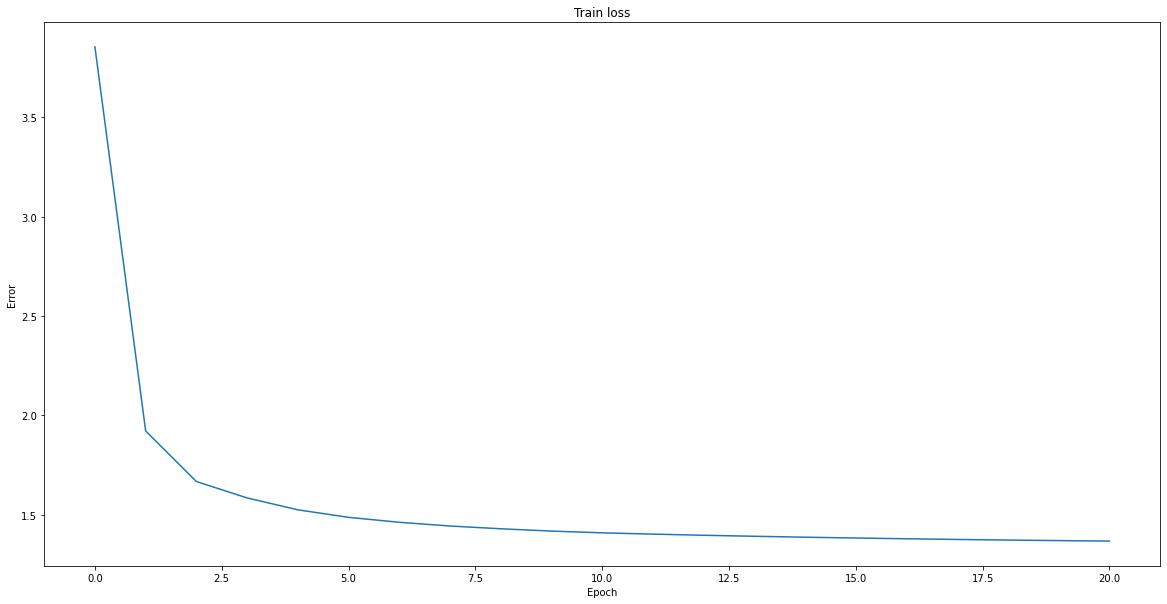

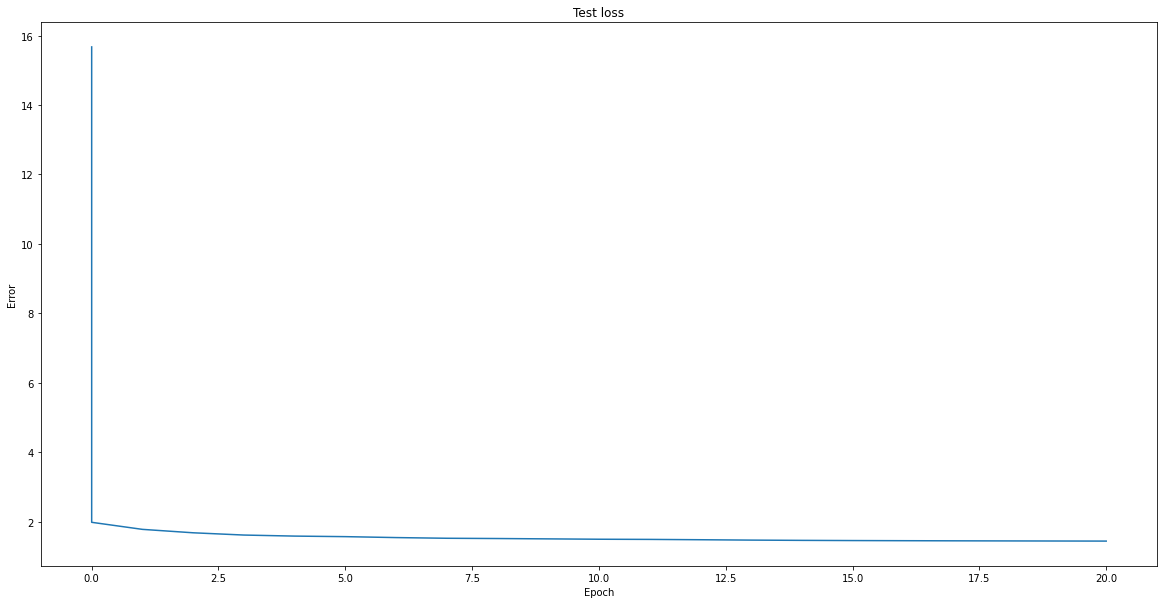

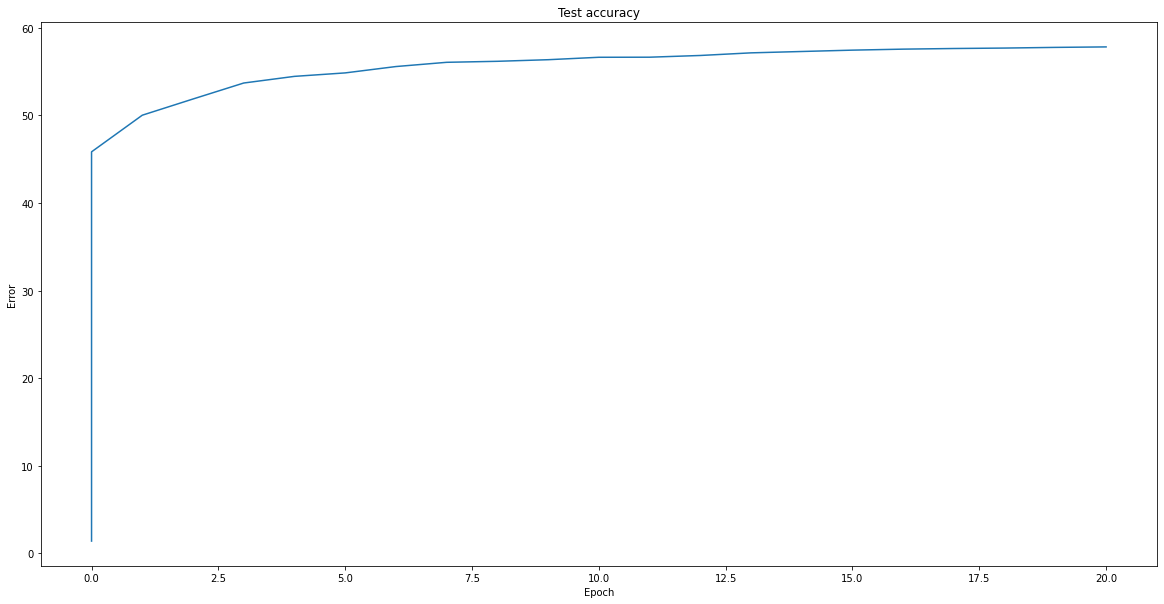

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'



    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 100

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(15):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
    print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the corridor was staring at the corridor and the corridor was staring at the corridor and the corridor 
generated with sample	 Harry Potter and there was after with Some why drinned eyes once. It are trying course, after the mast. These with Hermi
generated with sample	 Harry Potter and they sugged across into Fred and staring at his stal5 within them wat, Harry thremingled and his mbside
generated with sample	 Harry Potter and the Dagis had nexter quiemblike on the barry envoury of rator trueling his agrect. . . . . Pevillow sto
generated with sample	 Harry Potter and there isn't time, then Dean, he was about Hermione. Ro, could sitting them, strongy interility to it. A
generated with sample	 Harry Potter and the whirtles of creaking hands. The wand up the pafentscare or the cortable was trying them, to cale at
generated with sample	 Harry Potter and they were souing out of wearly one things. Hermione des. He cnorilly at the outrawisceg, feering th

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
3. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
6. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 




--2021-11-23 00:39:05--  https://raw.githubusercontent.com/mxw/grmr/master/src/finaltests/bible.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4451368 (4.2M) [text/plain]
Saving to: ‘bible.txt’

bible.txt           100%[===================>]   4.25M  --.-KB/s    in 0.09s   

2021-11-23 00:39:06 (47.3 MB/s) - ‘bible.txt’ saved [4451368/4451368]

bible.txt  harry_potter.txt  pt_util.py
Using device cuda
num workers: 2
Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	0II60yII@nyNIy..NryNN.yy;W66y)C6yJyZbzD yFW6y)C6yCJzzGypvZvNy9TrzW6yIv00yvNFTW@p0p66yI000yIF4ud(y)C6


Input	hath opened mine e

  1%|▏         | 2/135 [00:00<00:24,  5.42it/s]

Train Epoch: 0 [0/34560 (0%)]	Loss: 16.267616


  9%|▉         | 12/135 [00:01<00:18,  6.54it/s]

Train Epoch: 0 [2560/34560 (7%)]	Loss: 11.529466


 16%|█▋        | 22/135 [00:03<00:17,  6.63it/s]

Train Epoch: 0 [5120/34560 (15%)]	Loss: 6.631173


 24%|██▎       | 32/135 [00:04<00:15,  6.47it/s]

Train Epoch: 0 [7680/34560 (22%)]	Loss: 3.900429


 31%|███       | 42/135 [00:06<00:14,  6.58it/s]

Train Epoch: 0 [10240/34560 (30%)]	Loss: 3.052632


 39%|███▊      | 52/135 [00:08<00:12,  6.42it/s]

Train Epoch: 0 [12800/34560 (37%)]	Loss: 2.715109


 46%|████▌     | 62/135 [00:09<00:11,  6.57it/s]

Train Epoch: 0 [15360/34560 (44%)]	Loss: 2.675897


 53%|█████▎    | 72/135 [00:11<00:09,  6.59it/s]

Train Epoch: 0 [17920/34560 (52%)]	Loss: 2.638879


 61%|██████    | 82/135 [00:12<00:08,  6.44it/s]

Train Epoch: 0 [20480/34560 (59%)]	Loss: 2.690842


 68%|██████▊   | 92/135 [00:14<00:06,  6.59it/s]

Train Epoch: 0 [23040/34560 (67%)]	Loss: 2.649677


 76%|███████▌  | 102/135 [00:15<00:05,  6.44it/s]

Train Epoch: 0 [25600/34560 (74%)]	Loss: 2.483027


 83%|████████▎ | 112/135 [00:17<00:03,  6.57it/s]

Train Epoch: 0 [28160/34560 (81%)]	Loss: 2.597287


 90%|█████████ | 122/135 [00:18<00:01,  6.56it/s]

Train Epoch: 0 [30720/34560 (89%)]	Loss: 2.341022


 98%|█████████▊| 132/135 [00:20<00:00,  6.54it/s]

Train Epoch: 0 [33280/34560 (96%)]	Loss: 2.444903


100%|██████████| 135/135 [00:20<00:00,  6.50it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	m,t. aach fr te rddhe dird  and tida pe un  and teang aor h ioollh aa e ihen   .re, aa e ian h  and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	.d  dner d tont wae   2:266Aow iieeiow ihet hod oi r dh aot phpge  t 2et hn t d ten,terfrrandpipplre


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	oi 2:2 A taaar th heu, whal,  2  an hh  ahet hhe   wn ho  prran  fin tnong teu, 1ot Wot hne thet hoo


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:29,  4.46it/s]

Train Epoch: 1 [0/34560 (0%)]	Loss: 2.003448


  9%|▉         | 12/135 [00:02<00:19,  6.34it/s]

Train Epoch: 1 [2560/34560 (7%)]	Loss: 2.008565


 16%|█▋        | 22/135 [00:03<00:17,  6.47it/s]

Train Epoch: 1 [5120/34560 (15%)]	Loss: 2.143625


 24%|██▎       | 32/135 [00:05<00:15,  6.50it/s]

Train Epoch: 1 [7680/34560 (22%)]	Loss: 1.879586


 31%|███       | 42/135 [00:06<00:14,  6.47it/s]

Train Epoch: 1 [10240/34560 (30%)]	Loss: 1.875341


 39%|███▊      | 52/135 [00:08<00:12,  6.48it/s]

Train Epoch: 1 [12800/34560 (37%)]	Loss: 2.200936


 46%|████▌     | 62/135 [00:09<00:11,  6.41it/s]

Train Epoch: 1 [15360/34560 (44%)]	Loss: 1.902888


 53%|█████▎    | 72/135 [00:11<00:09,  6.51it/s]

Train Epoch: 1 [17920/34560 (52%)]	Loss: 1.739158


 61%|██████    | 82/135 [00:12<00:08,  6.45it/s]

Train Epoch: 1 [20480/34560 (59%)]	Loss: 2.122666


 68%|██████▊   | 92/135 [00:14<00:06,  6.47it/s]

Train Epoch: 1 [23040/34560 (67%)]	Loss: 2.306167


 76%|███████▌  | 102/135 [00:15<00:05,  6.45it/s]

Train Epoch: 1 [25600/34560 (74%)]	Loss: 2.060215


 83%|████████▎ | 112/135 [00:17<00:03,  6.50it/s]

Train Epoch: 1 [28160/34560 (81%)]	Loss: 1.977177


 90%|█████████ | 122/135 [00:19<00:02,  6.40it/s]

Train Epoch: 1 [30720/34560 (89%)]	Loss: 1.769757


 98%|█████████▊| 132/135 [00:20<00:00,  6.54it/s]

Train Epoch: 1 [33280/34560 (96%)]	Loss: 1.950774


100%|██████████| 135/135 [00:21<00:00,  6.40it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	  d  aach an ti r tha dard  and tite vertn  and teing ior h tooilh aa   than i ,ry  aa   thn h, and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	.di dner d tene taes  2:136Bow iirtiow that tod oiav dh hot hhnger   aut tn t d lan te fnsardiippere


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	ai 2:4 Antaaak uh tour ahale  2 ran sh  ahat the   an io  inrat  ten inong iour 1o  ao  hfe thit ioa


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:30,  4.40it/s]

Train Epoch: 2 [0/34560 (0%)]	Loss: 1.750121


  9%|▉         | 12/135 [00:02<00:19,  6.38it/s]

Train Epoch: 2 [2560/34560 (7%)]	Loss: 1.595523


 16%|█▋        | 22/135 [00:03<00:17,  6.58it/s]

Train Epoch: 2 [5120/34560 (15%)]	Loss: 1.809415


 24%|██▎       | 32/135 [00:05<00:15,  6.55it/s]

Train Epoch: 2 [7680/34560 (22%)]	Loss: 1.699335


 31%|███       | 42/135 [00:06<00:14,  6.52it/s]

Train Epoch: 2 [10240/34560 (30%)]	Loss: 1.584098


 39%|███▊      | 52/135 [00:08<00:12,  6.52it/s]

Train Epoch: 2 [12800/34560 (37%)]	Loss: 1.706571


 46%|████▌     | 62/135 [00:09<00:11,  6.51it/s]

Train Epoch: 2 [15360/34560 (44%)]	Loss: 1.445380


 53%|█████▎    | 72/135 [00:11<00:09,  6.44it/s]

Train Epoch: 2 [17920/34560 (52%)]	Loss: 1.419306


 61%|██████    | 82/135 [00:12<00:08,  6.42it/s]

Train Epoch: 2 [20480/34560 (59%)]	Loss: 1.786053


 68%|██████▊   | 92/135 [00:14<00:06,  6.55it/s]

Train Epoch: 2 [23040/34560 (67%)]	Loss: 1.895737


 76%|███████▌  | 102/135 [00:15<00:05,  6.45it/s]

Train Epoch: 2 [25600/34560 (74%)]	Loss: 1.748104


 83%|████████▎ | 112/135 [00:17<00:03,  6.45it/s]

Train Epoch: 2 [28160/34560 (81%)]	Loss: 1.715228


 90%|█████████ | 122/135 [00:19<00:02,  6.39it/s]

Train Epoch: 2 [30720/34560 (89%)]	Loss: 1.661496


 98%|█████████▊| 132/135 [00:20<00:00,  6.48it/s]

Train Epoch: 2 [33280/34560 (96%)]	Loss: 1.796610


100%|██████████| 135/135 [00:21<00:00,  6.40it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	  d  ahch as he v the pard  and sepepvertn  and sligg tor h hooish hh   then h ,ue  th   thg h, Wnd 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edh hner.d heng hnes, 2:244Aow ti siow thet hod oo v dh hothhhnge    fut hf i d yen se fssardpipplre


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	hi 2:24Anwaaak uh Jou  hhale  2 ran sh  hhet hhe e os not hnwane hen snong tou  1ot hot hfe hhet hha


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:24,  5.38it/s]

Train Epoch: 3 [0/34560 (0%)]	Loss: 1.642988


  9%|▉         | 12/135 [00:01<00:19,  6.43it/s]

Train Epoch: 3 [2560/34560 (7%)]	Loss: 1.526669


 16%|█▋        | 22/135 [00:03<00:17,  6.48it/s]

Train Epoch: 3 [5120/34560 (15%)]	Loss: 1.666409


 24%|██▎       | 32/135 [00:05<00:15,  6.45it/s]

Train Epoch: 3 [7680/34560 (22%)]	Loss: 1.518712


 31%|███       | 42/135 [00:06<00:14,  6.48it/s]

Train Epoch: 3 [10240/34560 (30%)]	Loss: 1.461677


 39%|███▊      | 52/135 [00:08<00:12,  6.49it/s]

Train Epoch: 3 [12800/34560 (37%)]	Loss: 1.576573


 46%|████▌     | 62/135 [00:09<00:11,  6.32it/s]

Train Epoch: 3 [15360/34560 (44%)]	Loss: 1.343985


 53%|█████▎    | 72/135 [00:11<00:09,  6.39it/s]

Train Epoch: 3 [17920/34560 (52%)]	Loss: 1.339703


 61%|██████    | 82/135 [00:12<00:08,  6.42it/s]

Train Epoch: 3 [20480/34560 (59%)]	Loss: 1.694398


 68%|██████▊   | 92/135 [00:14<00:06,  6.41it/s]

Train Epoch: 3 [23040/34560 (67%)]	Loss: 1.772937


 76%|███████▌  | 102/135 [00:15<00:05,  6.47it/s]

Train Epoch: 3 [25600/34560 (74%)]	Loss: 1.530056


 83%|████████▎ | 112/135 [00:17<00:03,  6.42it/s]

Train Epoch: 3 [28160/34560 (81%)]	Loss: 1.500910


 90%|█████████ | 122/135 [00:19<00:02,  6.44it/s]

Train Epoch: 3 [30720/34560 (89%)]	Loss: 1.500433


 98%|█████████▊| 132/135 [00:20<00:00,  6.49it/s]

Train Epoch: 3 [33280/34560 (96%)]	Loss: 1.667584


100%|██████████| 135/135 [00:21<00:00,  6.40it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	 rd  ahch as ae ddthe pard  and seplivedtn  and sling Jor hitioit  ah   than   ,ul  ta   thg h, and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edh snered tene hyes, 2:244Aow th snow that tod oaav dh hot hhnges   fut hf y y yan se sssamd ippers


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	ai 2:2 Anwaaak uh tou  ahale  2 ran sh  ahat the e ws lot hnlane meddynong tou  1ot hot hne thit dha


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:28,  4.65it/s]

Train Epoch: 4 [0/34560 (0%)]	Loss: 1.549897


  9%|▉         | 12/135 [00:02<00:19,  6.26it/s]

Train Epoch: 4 [2560/34560 (7%)]	Loss: 1.389998


 16%|█▋        | 22/135 [00:03<00:17,  6.40it/s]

Train Epoch: 4 [5120/34560 (15%)]	Loss: 1.513865


 24%|██▎       | 32/135 [00:05<00:16,  6.41it/s]

Train Epoch: 4 [7680/34560 (22%)]	Loss: 1.434927


 31%|███       | 42/135 [00:06<00:14,  6.31it/s]

Train Epoch: 4 [10240/34560 (30%)]	Loss: 1.395892


 39%|███▊      | 52/135 [00:08<00:12,  6.42it/s]

Train Epoch: 4 [12800/34560 (37%)]	Loss: 1.516225


 46%|████▌     | 62/135 [00:09<00:11,  6.34it/s]

Train Epoch: 4 [15360/34560 (44%)]	Loss: 1.286277


 53%|█████▎    | 72/135 [00:11<00:09,  6.44it/s]

Train Epoch: 4 [17920/34560 (52%)]	Loss: 1.286172


 61%|██████    | 82/135 [00:12<00:08,  6.41it/s]

Train Epoch: 4 [20480/34560 (59%)]	Loss: 1.649382


 68%|██████▊   | 92/135 [00:14<00:06,  6.36it/s]

Train Epoch: 4 [23040/34560 (67%)]	Loss: 1.697367


 76%|███████▌  | 102/135 [00:16<00:05,  6.37it/s]

Train Epoch: 4 [25600/34560 (74%)]	Loss: 1.483849


 83%|████████▎ | 112/135 [00:17<00:03,  6.42it/s]

Train Epoch: 4 [28160/34560 (81%)]	Loss: 1.441139


 90%|█████████ | 122/135 [00:19<00:01,  6.54it/s]

Train Epoch: 4 [30720/34560 (89%)]	Loss: 1.434559


 98%|█████████▊| 132/135 [00:20<00:00,  6.49it/s]

Train Epoch: 4 [33280/34560 (96%)]	Loss: 1.631956


100%|██████████| 135/135 [00:21<00:00,  6.35it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	 rt  ahch as ae rdthe pard  and tepeivedtn  and tlong hor h tooit  ah e then e uul  aa i thn h, and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edh hnered tene hyes, 2:243Aow th snow that tod oaav dh hot hhnner   fut tn y   yan se fspamdoippers


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	aa 2:2 Anwaaak uh tou  ahale  2 ran wh  ahat hhe e wn not hnlane meddtnong tou  1ot hot hne thet hha


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:31,  4.17it/s]

Train Epoch: 5 [0/34560 (0%)]	Loss: 1.486722


  9%|▉         | 12/135 [00:02<00:19,  6.25it/s]

Train Epoch: 5 [2560/34560 (7%)]	Loss: 1.334517


 16%|█▋        | 22/135 [00:03<00:17,  6.42it/s]

Train Epoch: 5 [5120/34560 (15%)]	Loss: 1.445245


 24%|██▎       | 32/135 [00:05<00:15,  6.49it/s]

Train Epoch: 5 [7680/34560 (22%)]	Loss: 1.371685


 31%|███       | 42/135 [00:06<00:14,  6.37it/s]

Train Epoch: 5 [10240/34560 (30%)]	Loss: 1.346102


 39%|███▊      | 52/135 [00:08<00:13,  6.31it/s]

Train Epoch: 5 [12800/34560 (37%)]	Loss: 1.474470


 46%|████▌     | 62/135 [00:09<00:11,  6.46it/s]

Train Epoch: 5 [15360/34560 (44%)]	Loss: 1.261366


 53%|█████▎    | 72/135 [00:11<00:09,  6.35it/s]

Train Epoch: 5 [17920/34560 (52%)]	Loss: 1.248073


 61%|██████    | 82/135 [00:13<00:08,  6.43it/s]

Train Epoch: 5 [20480/34560 (59%)]	Loss: 1.612032


 68%|██████▊   | 92/135 [00:14<00:06,  6.36it/s]

Train Epoch: 5 [23040/34560 (67%)]	Loss: 1.640199


 76%|███████▌  | 102/135 [00:16<00:05,  6.29it/s]

Train Epoch: 5 [25600/34560 (74%)]	Loss: 1.440102


 83%|████████▎ | 112/135 [00:17<00:03,  6.48it/s]

Train Epoch: 5 [28160/34560 (81%)]	Loss: 1.389437


 90%|█████████ | 122/135 [00:19<00:02,  6.48it/s]

Train Epoch: 5 [30720/34560 (89%)]	Loss: 1.391897


 98%|█████████▊| 132/135 [00:20<00:00,  6.45it/s]

Train Epoch: 5 [33280/34560 (96%)]	Loss: 1.589746


100%|██████████| 135/135 [00:21<00:00,  6.32it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	  t  ahch as ae ddthe pard  and teteivedtn  and teang hor h tooit  ah e thendh uud  aa i thn h, and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edh hnened tene hyes, 1:23 Aow th snow thet tod oa vddh hot hhnner   aut tn y   man te sspamdhip ers


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	aa 2:2 Anwaaak uh tou  aaale  1 ran wh  ahat hhe e wn not hnmane men tnong tou  1ot hot hne thet hha


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:24,  5.46it/s]

Train Epoch: 6 [0/34560 (0%)]	Loss: 1.431881


  9%|▉         | 12/135 [00:01<00:19,  6.42it/s]

Train Epoch: 6 [2560/34560 (7%)]	Loss: 1.298586


 16%|█▋        | 22/135 [00:03<00:17,  6.45it/s]

Train Epoch: 6 [5120/34560 (15%)]	Loss: 1.368713


 24%|██▎       | 32/135 [00:05<00:16,  6.37it/s]

Train Epoch: 6 [7680/34560 (22%)]	Loss: 1.332330


 31%|███       | 42/135 [00:06<00:14,  6.45it/s]

Train Epoch: 6 [10240/34560 (30%)]	Loss: 1.321385


 39%|███▊      | 52/135 [00:08<00:12,  6.46it/s]

Train Epoch: 6 [12800/34560 (37%)]	Loss: 1.434677


 46%|████▌     | 62/135 [00:09<00:11,  6.51it/s]

Train Epoch: 6 [15360/34560 (44%)]	Loss: 1.240092


 53%|█████▎    | 72/135 [00:11<00:10,  6.26it/s]

Train Epoch: 6 [17920/34560 (52%)]	Loss: 1.211588


 61%|██████    | 82/135 [00:12<00:08,  6.42it/s]

Train Epoch: 6 [20480/34560 (59%)]	Loss: 1.566099


 68%|██████▊   | 92/135 [00:14<00:06,  6.46it/s]

Train Epoch: 6 [23040/34560 (67%)]	Loss: 1.587108


 76%|███████▌  | 102/135 [00:15<00:05,  6.30it/s]

Train Epoch: 6 [25600/34560 (74%)]	Loss: 1.407586


 83%|████████▎ | 112/135 [00:17<00:03,  6.43it/s]

Train Epoch: 6 [28160/34560 (81%)]	Loss: 1.363139


 90%|█████████ | 122/135 [00:19<00:02,  6.48it/s]

Train Epoch: 6 [30720/34560 (89%)]	Loss: 1.368512


 98%|█████████▊| 132/135 [00:20<00:00,  6.44it/s]

Train Epoch: 6 [33280/34560 (96%)]	Loss: 1.549730


100%|██████████| 135/135 [00:21<00:00,  6.38it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	 rt  aach as ae ddahe sords and seteivedtn  and seang hor h tooit  aa e ohendy urd, ta i thg h, and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edh hnened tene hyes, 1:23 Aow th snow that tod oa vddh hot hhnner   aut tf y   man se sssamdhippers


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	aa 2:2 Anwaaak uh tou  aaale  1 ran whn that the e ws not hnmane men tnong tou  1ot yot hn  that doa


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:30,  4.29it/s]

Train Epoch: 7 [0/34560 (0%)]	Loss: 1.398073


  9%|▉         | 12/135 [00:02<00:19,  6.41it/s]

Train Epoch: 7 [2560/34560 (7%)]	Loss: 1.267828


 16%|█▋        | 22/135 [00:03<00:17,  6.55it/s]

Train Epoch: 7 [5120/34560 (15%)]	Loss: 1.288765


 24%|██▎       | 32/135 [00:05<00:15,  6.48it/s]

Train Epoch: 7 [7680/34560 (22%)]	Loss: 1.305159


 31%|███       | 42/135 [00:06<00:14,  6.39it/s]

Train Epoch: 7 [10240/34560 (30%)]	Loss: 1.288880


 39%|███▊      | 52/135 [00:08<00:13,  6.38it/s]

Train Epoch: 7 [12800/34560 (37%)]	Loss: 1.396107


 46%|████▌     | 62/135 [00:09<00:11,  6.43it/s]

Train Epoch: 7 [15360/34560 (44%)]	Loss: 1.209955


 53%|█████▎    | 72/135 [00:11<00:09,  6.39it/s]

Train Epoch: 7 [17920/34560 (52%)]	Loss: 1.185039


 61%|██████    | 82/135 [00:12<00:08,  6.31it/s]

Train Epoch: 7 [20480/34560 (59%)]	Loss: 1.522283


 68%|██████▊   | 92/135 [00:14<00:06,  6.48it/s]

Train Epoch: 7 [23040/34560 (67%)]	Loss: 1.550086


 76%|███████▌  | 102/135 [00:16<00:05,  6.37it/s]

Train Epoch: 7 [25600/34560 (74%)]	Loss: 1.362979


 83%|████████▎ | 112/135 [00:17<00:03,  6.53it/s]

Train Epoch: 7 [28160/34560 (81%)]	Loss: 1.336110


 90%|█████████ | 122/135 [00:19<00:02,  6.29it/s]

Train Epoch: 7 [30720/34560 (89%)]	Loss: 1.328922


 98%|█████████▊| 132/135 [00:20<00:00,  6.41it/s]

Train Epoch: 7 [33280/34560 (96%)]	Loss: 1.524455


100%|██████████| 135/135 [00:21<00:00,  6.37it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	 rd  aach as ae ddtheysords and seteivedtn  and seing tor h tooit  aa e ooesdy url, ta e thd h, tnd 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edi onened tine hyes, 1:10 Aow th snow thet tod oa rddh tot thdner   aut tt y   tan te sssamdoippeds


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	aa 2:2 Anwaaaketh teu  woale  1 ran wan thet theye ws not tnmate man tnong tou  1ot tet hn  thet doa


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:29,  4.48it/s]

Train Epoch: 8 [0/34560 (0%)]	Loss: 1.385375


  9%|▉         | 12/135 [00:02<00:19,  6.23it/s]

Train Epoch: 8 [2560/34560 (7%)]	Loss: 1.255569


 16%|█▋        | 22/135 [00:03<00:17,  6.46it/s]

Train Epoch: 8 [5120/34560 (15%)]	Loss: 1.249654


 24%|██▎       | 32/135 [00:05<00:16,  6.39it/s]

Train Epoch: 8 [7680/34560 (22%)]	Loss: 1.291451


 31%|███       | 42/135 [00:06<00:14,  6.25it/s]

Train Epoch: 8 [10240/34560 (30%)]	Loss: 1.264509


 39%|███▊      | 52/135 [00:08<00:12,  6.40it/s]

Train Epoch: 8 [12800/34560 (37%)]	Loss: 1.359567


 46%|████▌     | 62/135 [00:09<00:11,  6.38it/s]

Train Epoch: 8 [15360/34560 (44%)]	Loss: 1.181389


 53%|█████▎    | 72/135 [00:11<00:09,  6.48it/s]

Train Epoch: 8 [17920/34560 (52%)]	Loss: 1.161880


 61%|██████    | 82/135 [00:12<00:08,  6.46it/s]

Train Epoch: 8 [20480/34560 (59%)]	Loss: 1.497586


 68%|██████▊   | 92/135 [00:14<00:06,  6.48it/s]

Train Epoch: 8 [23040/34560 (67%)]	Loss: 1.512431


 76%|███████▌  | 102/135 [00:16<00:05,  6.48it/s]

Train Epoch: 8 [25600/34560 (74%)]	Loss: 1.344458


 83%|████████▎ | 112/135 [00:17<00:03,  6.43it/s]

Train Epoch: 8 [28160/34560 (81%)]	Loss: 1.326616


 90%|█████████ | 122/135 [00:19<00:01,  6.51it/s]

Train Epoch: 8 [30720/34560 (89%)]	Loss: 1.308464


 98%|█████████▊| 132/135 [00:20<00:00,  6.49it/s]

Train Epoch: 8 [33280/34560 (96%)]	Loss: 1.499534


100%|██████████| 135/135 [00:21<00:00,  6.37it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	r d  ahch as ae rdtheyword  and teteitedtn  and teing tor h tioit  ah e theney url, ta e thd e, and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edi onered tine hyes, 1:12 Aow ti snow thet tod ii r dh tot tedner   aut tt y   tan te tssimdhippede


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	ai 2:1 Anwaaaketh teu  foale  1 ran whn thet theye ws not tnmite man tnong tou  1ot tet hn  thet tea


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:25,  5.15it/s]

Train Epoch: 9 [0/34560 (0%)]	Loss: 1.365203


  9%|▉         | 12/135 [00:01<00:19,  6.40it/s]

Train Epoch: 9 [2560/34560 (7%)]	Loss: 1.237301


 16%|█▋        | 22/135 [00:03<00:17,  6.37it/s]

Train Epoch: 9 [5120/34560 (15%)]	Loss: 1.229575


 24%|██▎       | 32/135 [00:05<00:16,  6.43it/s]

Train Epoch: 9 [7680/34560 (22%)]	Loss: 1.272154


 31%|███       | 42/135 [00:06<00:14,  6.33it/s]

Train Epoch: 9 [10240/34560 (30%)]	Loss: 1.254213


 39%|███▊      | 52/135 [00:08<00:12,  6.40it/s]

Train Epoch: 9 [12800/34560 (37%)]	Loss: 1.340472


 46%|████▌     | 62/135 [00:09<00:11,  6.37it/s]

Train Epoch: 9 [15360/34560 (44%)]	Loss: 1.168767


 53%|█████▎    | 72/135 [00:11<00:09,  6.45it/s]

Train Epoch: 9 [17920/34560 (52%)]	Loss: 1.145159


 61%|██████    | 82/135 [00:12<00:08,  6.41it/s]

Train Epoch: 9 [20480/34560 (59%)]	Loss: 1.482334


 68%|██████▊   | 92/135 [00:14<00:06,  6.35it/s]

Train Epoch: 9 [23040/34560 (67%)]	Loss: 1.474840


 76%|███████▌  | 102/135 [00:15<00:05,  6.43it/s]

Train Epoch: 9 [25600/34560 (74%)]	Loss: 1.337901


 83%|████████▎ | 112/135 [00:17<00:03,  6.53it/s]

Train Epoch: 9 [28160/34560 (81%)]	Loss: 1.313347


 90%|█████████ | 122/135 [00:19<00:02,  6.35it/s]

Train Epoch: 9 [30720/34560 (89%)]	Loss: 1.285541


 98%|█████████▊| 132/135 [00:20<00:00,  6.49it/s]

Train Epoch: 9 [33280/34560 (96%)]	Loss: 1.477698


100%|██████████| 135/135 [00:21<00:00,  6.39it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	r d  aoch an ae r theytords and teteivedtn  and teing tor h tioit  ah e theney url, ta e ihl e  and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edi tnened tine hyes, 1:12 Aew th snow thet ted ii r dh tot tedned   aut tt y   man te tssimdhippede


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	ai 2:1 Anwaiaketh teu  feale  1 ran th  thet theye ws not tnmite man tnong tou  1et tet hn  thet tee


Input	nneth from the beginning. For this pu

  1%|▏         | 2/135 [00:00<00:30,  4.35it/s]

Train Epoch: 10 [0/34560 (0%)]	Loss: 1.350778


  9%|▉         | 12/135 [00:02<00:19,  6.38it/s]

Train Epoch: 10 [2560/34560 (7%)]	Loss: 1.216161


 16%|█▋        | 22/135 [00:03<00:17,  6.48it/s]

Train Epoch: 10 [5120/34560 (15%)]	Loss: 1.199926


 24%|██▎       | 32/135 [00:05<00:16,  6.38it/s]

Train Epoch: 10 [7680/34560 (22%)]	Loss: 1.245943


 31%|███       | 42/135 [00:06<00:14,  6.26it/s]

Train Epoch: 10 [10240/34560 (30%)]	Loss: 1.247448


 39%|███▊      | 52/135 [00:08<00:12,  6.45it/s]

Train Epoch: 10 [12800/34560 (37%)]	Loss: 1.322312


 46%|████▌     | 62/135 [00:09<00:11,  6.34it/s]

Train Epoch: 10 [15360/34560 (44%)]	Loss: 1.154080


 53%|█████▎    | 72/135 [00:11<00:09,  6.51it/s]

Train Epoch: 10 [17920/34560 (52%)]	Loss: 1.131762


 61%|██████    | 82/135 [00:13<00:08,  6.41it/s]

Train Epoch: 10 [20480/34560 (59%)]	Loss: 1.462656


 68%|██████▊   | 92/135 [00:14<00:06,  6.36it/s]

Train Epoch: 10 [23040/34560 (67%)]	Loss: 1.445287


 76%|███████▌  | 102/135 [00:16<00:05,  6.46it/s]

Train Epoch: 10 [25600/34560 (74%)]	Loss: 1.317263


 83%|████████▎ | 112/135 [00:17<00:03,  6.47it/s]

Train Epoch: 10 [28160/34560 (81%)]	Loss: 1.303526


 90%|█████████ | 122/135 [00:19<00:02,  6.44it/s]

Train Epoch: 10 [30720/34560 (89%)]	Loss: 1.280988


 98%|█████████▊| 132/135 [00:20<00:00,  6.45it/s]

Train Epoch: 10 [33280/34560 (96%)]	Loss: 1.458937


100%|██████████| 135/135 [00:21<00:00,  6.35it/s]


Input	ound; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and
GT	und; such as hear the word, and receive it, and bring forth fruit, some thirtyfold, some sixty, and 
pred	rrd  aoch as ae rdthe sords and teseivedtn  and teing tor h tooit  ao e thasty url, ta e thl e, and 


Input	hath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper
GT	ath opened mine eyes. 9:31 Now we know that God heareth not sinners: but if any man be a worshipper 
pred	edi snened tene hyes, 1:12 Aew th snow thet ted ia r dh tot tedneds  aut tt y   man te tssirdeippede


Input	ch. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sh
GT	h. 6:5 I speak to your shame. Is it so, that there is not a wise man among you? no, not one that sha
pred	ai 2:1 Anwaaaketh tou  feale  1  an th  that theye ts not tnmile man tnong tou  1et tet hn  that tea


Input	nneth from the beginning. For this pu

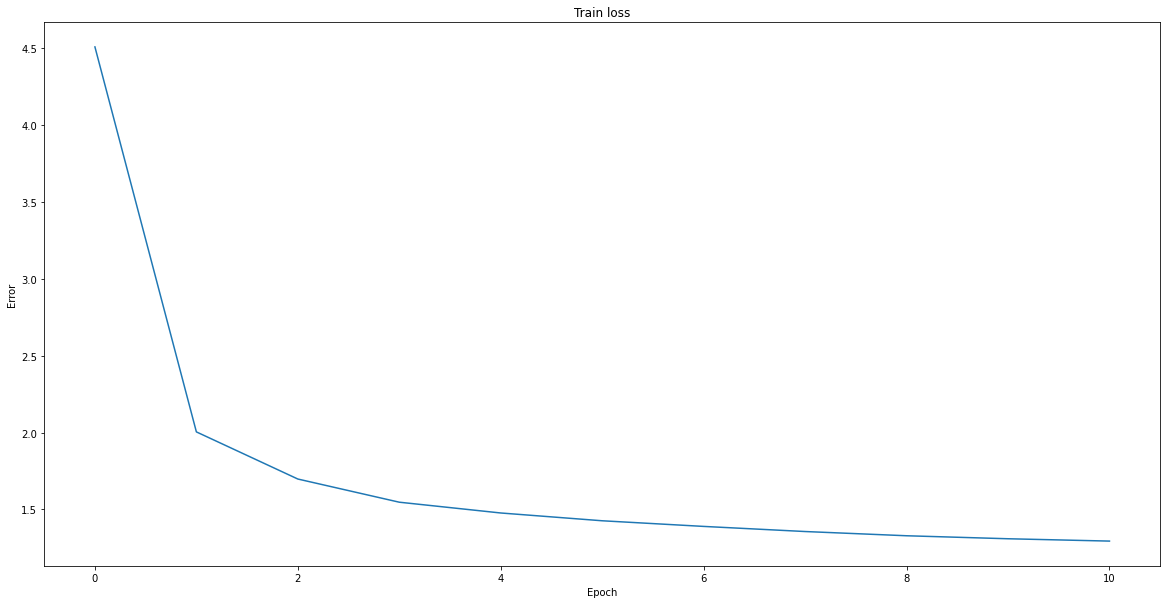

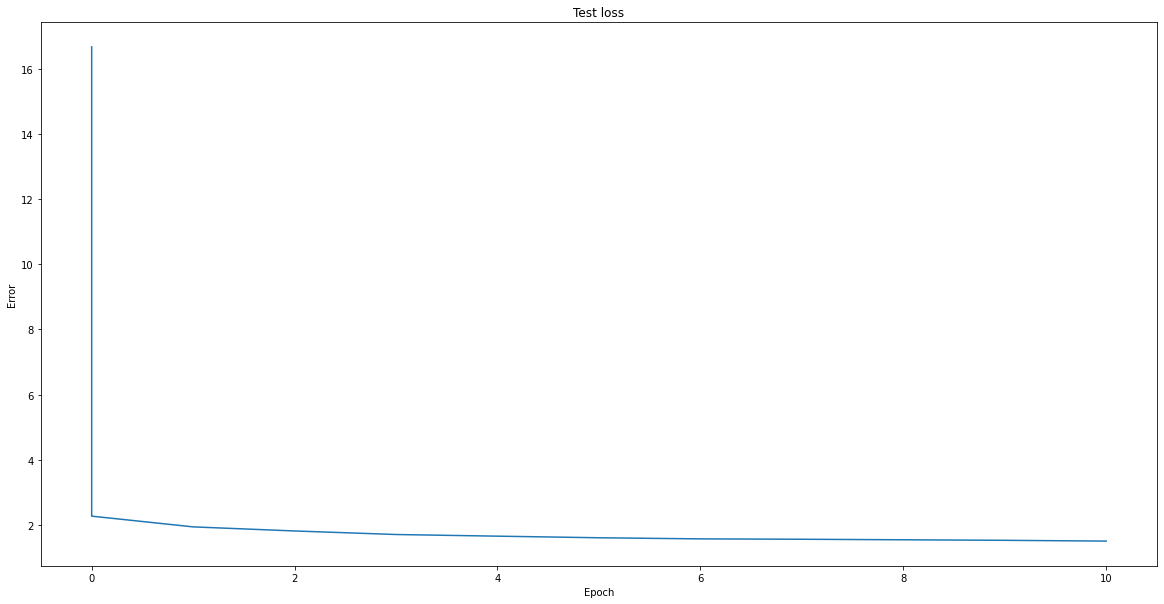

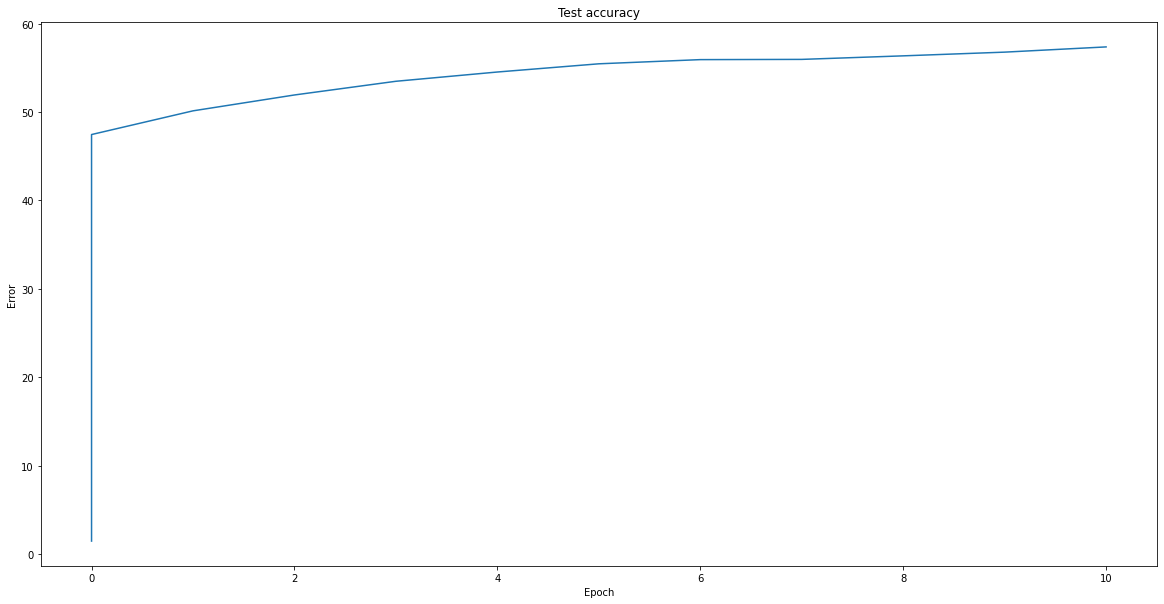

In [ ]:
# 1. We will train the model on bible

if not os.path.exists(os.path.join(DATA_PATH, 'bible.txt')):
    os.chdir(BASE_PATH)
    !wget https://raw.githubusercontent.com/mxw/grmr/master/src/finaltests/bible.txt
    !cp bible.txt /content
    !ls .

prepare_data(DATA_PATH + 'bible.txt', 'bible_chars')

def bible():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 10
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log-bible.pkl'

    data_train = HarryPotterDataset(DATA_PATH + 'bible_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'bible_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints-bible')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints-bible/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints-bible/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab2, device = bible()

In [ ]:
def eval_final_model(final_model, vocab2, device):
    seed_words = 'Love is'
    sequence_length = 100

    generated_sentence = generate_language(final_model, device, seed_words, sequence_length, vocab2, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(15):
        generated_sentence = generate_language(final_model, device, seed_words, sequence_length, vocab2, 'sample')
        print('generated with sample\t', generated_sentence)

    generated_sentence = generate_language(final_model, device, seed_words, sequence_length, vocab2, 'beam')
    print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab2, device)

generated with max	 Love is the tenth one of the seen of the LORD of hosts. 1:11 And they shall be the desolate the temple that
generated with sample	 Love is thy tarkes, and thy taberless. 2:82:21 Then he trought gigdoms, and the pust thing that into see th
generated with sample	 Love is muchts? pleave. 16:25 Estrutifyed, saying, And bastsonded of the time that and. 26:121 Now therefor
generated with sample	 Love is cleaned, and hewed on the desciry topher, even her talms: LOn the didissyis thinguies: 2:21 The hea
generated with sample	 Love is cread. 24:23 Heseeding it bigly and shall come to do strayed; 12:5 And I will derisles thyself with
generated with sample	 Love is man have seen in the lay of bringdom and shall be desolate again and Nathand. 19:25 And it came to 
generated with sample	 Love is the land. 51:33 And Egypt me came unto full my destrylets, and mell and he said unto them, 19:5J! b
generated with sample	 Love is eyecre on them are to and man; he taketh were is brinto

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ggn{?g(ggP!4ggbyQb2Eb.y_g(gEb4bDA=%D gfU_fDbbbbbD.___rDWUg GGGuM=%DggP)ADn'xff(DGdfDDhDgP_h!nggP)A:g


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	D(F%D{DdrD3%fff%D=%DRgb(F(.gP!4(.dfg(F%D JUg(b{?g_Z{b2__ZZngggMSgfM%MgMffrD=Pr!D;ggbggggR2xMCb.A=%Dn


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	44b4gbPdyy%ffgdr4(2ggPb4Q=gbyXZD3bb.gdr%(FWb!nGbggG?dy((GGG^VH_r dy%q'g=gbyQg4%r%__AdD3%gggPb)b!Qd`b


Input	erha

  1%|          | 2/194 [00:00<00:44,  4.34it/s]

Train Epoch: 0 [0/49664 (0%)]	Loss: 9.185851


  6%|▌         | 12/194 [00:02<00:35,  5.19it/s]

Train Epoch: 0 [2560/49664 (5%)]	Loss: 4.542165


 11%|█▏        | 22/194 [00:04<00:32,  5.22it/s]

Train Epoch: 0 [5120/49664 (10%)]	Loss: 3.026533


 16%|█▋        | 32/194 [00:06<00:31,  5.22it/s]

Train Epoch: 0 [7680/49664 (15%)]	Loss: 2.435453


 22%|██▏       | 42/194 [00:08<00:29,  5.21it/s]

Train Epoch: 0 [10240/49664 (21%)]	Loss: 2.099461


 27%|██▋       | 52/194 [00:10<00:27,  5.17it/s]

Train Epoch: 0 [12800/49664 (26%)]	Loss: 2.107396


 32%|███▏      | 62/194 [00:11<00:25,  5.20it/s]

Train Epoch: 0 [15360/49664 (31%)]	Loss: 2.031382


 37%|███▋      | 72/194 [00:13<00:23,  5.21it/s]

Train Epoch: 0 [17920/49664 (36%)]	Loss: 2.035618


 42%|████▏     | 82/194 [00:15<00:21,  5.18it/s]

Train Epoch: 0 [20480/49664 (41%)]	Loss: 1.888087


 47%|████▋     | 92/194 [00:17<00:19,  5.19it/s]

Train Epoch: 0 [23040/49664 (46%)]	Loss: 1.860688


 53%|█████▎    | 102/194 [00:19<00:17,  5.23it/s]

Train Epoch: 0 [25600/49664 (52%)]	Loss: 1.828944


 58%|█████▊    | 112/194 [00:21<00:15,  5.16it/s]

Train Epoch: 0 [28160/49664 (57%)]	Loss: 1.866590


 63%|██████▎   | 122/194 [00:23<00:13,  5.16it/s]

Train Epoch: 0 [30720/49664 (62%)]	Loss: 1.791851


 68%|██████▊   | 132/194 [00:25<00:11,  5.17it/s]

Train Epoch: 0 [33280/49664 (67%)]	Loss: 1.903959


 73%|███████▎  | 142/194 [00:27<00:10,  5.14it/s]

Train Epoch: 0 [35840/49664 (72%)]	Loss: 1.803355


 78%|███████▊  | 152/194 [00:29<00:08,  5.11it/s]

Train Epoch: 0 [38400/49664 (77%)]	Loss: 1.791362


 84%|████████▎ | 162/194 [00:31<00:06,  5.13it/s]

Train Epoch: 0 [40960/49664 (82%)]	Loss: 1.830755


 89%|████████▊ | 172/194 [00:33<00:04,  5.15it/s]

Train Epoch: 0 [43520/49664 (88%)]	Loss: 1.799741


 94%|█████████▍| 182/194 [00:35<00:02,  5.11it/s]

Train Epoch: 0 [46080/49664 (93%)]	Loss: 1.756645


 99%|█████████▉| 192/194 [00:37<00:00,  5.19it/s]

Train Epoch: 0 [48640/49664 (98%)]	Loss: 1.715504


100%|██████████| 194/194 [00:37<00:00,  5.16it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsreathttdhttnd toar d tnain   the sone  ithsl  "T wn tarre .  "e said  "Tob't taudi  wade  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	the seom te ore ta sanlht ttdht tf the saoateredtoreid tn tnsil toel tiom tiss arct tn ey  tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  teon tf toumleds og tivd   tut tt e hing tas taeu   .  .e mione s tedd ttemed th te ttigeng tft 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:04,  3.00it/s]

Train Epoch: 1 [0/49664 (0%)]	Loss: 1.707337


  6%|▌         | 12/194 [00:02<00:37,  4.91it/s]

Train Epoch: 1 [2560/49664 (5%)]	Loss: 1.718262


 11%|█         | 21/194 [00:04<00:33,  5.22it/s]

Train Epoch: 1 [5120/49664 (10%)]	Loss: 1.775081


 16%|█▋        | 32/194 [00:06<00:31,  5.13it/s]

Train Epoch: 1 [7680/49664 (15%)]	Loss: 1.701554


 22%|██▏       | 42/194 [00:08<00:29,  5.18it/s]

Train Epoch: 1 [10240/49664 (21%)]	Loss: 1.628203


 26%|██▋       | 51/194 [00:10<00:27,  5.20it/s]

Train Epoch: 1 [12800/49664 (26%)]	Loss: 1.704131


 31%|███▏      | 61/194 [00:12<00:26,  5.02it/s]

Train Epoch: 1 [15360/49664 (31%)]	Loss: 1.707180


 37%|███▋      | 72/194 [00:14<00:23,  5.22it/s]

Train Epoch: 1 [17920/49664 (36%)]	Loss: 1.738110


 42%|████▏     | 82/194 [00:16<00:22,  5.03it/s]

Train Epoch: 1 [20480/49664 (41%)]	Loss: 1.620050


 47%|████▋     | 91/194 [00:18<00:19,  5.17it/s]

Train Epoch: 1 [23040/49664 (46%)]	Loss: 1.601637


 52%|█████▏    | 101/194 [00:19<00:18,  5.03it/s]

Train Epoch: 1 [25600/49664 (52%)]	Loss: 1.558523


 58%|█████▊    | 112/194 [00:22<00:16,  5.09it/s]

Train Epoch: 1 [28160/49664 (57%)]	Loss: 1.642619


 62%|██████▏   | 121/194 [00:23<00:14,  5.13it/s]

Train Epoch: 1 [30720/49664 (62%)]	Loss: 1.589989


 68%|██████▊   | 132/194 [00:26<00:12,  5.02it/s]

Train Epoch: 1 [33280/49664 (67%)]	Loss: 1.727475


 73%|███████▎  | 142/194 [00:28<00:10,  5.14it/s]

Train Epoch: 1 [35840/49664 (72%)]	Loss: 1.633254


 78%|███████▊  | 152/194 [00:30<00:08,  4.99it/s]

Train Epoch: 1 [38400/49664 (77%)]	Loss: 1.626768


 83%|████████▎ | 161/194 [00:31<00:06,  5.08it/s]

Train Epoch: 1 [40960/49664 (82%)]	Loss: 1.673861


 88%|████████▊ | 171/194 [00:33<00:04,  5.11it/s]

Train Epoch: 1 [43520/49664 (88%)]	Loss: 1.632081


 94%|█████████▍| 182/194 [00:35<00:02,  5.04it/s]

Train Epoch: 1 [46080/49664 (93%)]	Loss: 1.609126


 99%|█████████▉| 192/194 [00:37<00:00,  5.06it/s]

Train Epoch: 1 [48640/49664 (98%)]	Loss: 1.575013


100%|██████████| 194/194 [00:38<00:00,  5.05it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsreat ththttnd toavtd tnainst the sone  iaask  "I wn tirre .  "e said  "To 't waudy  wade  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe seom te ore te wonlht thdht tf the sooateredtorsad tn tnsie toel tiom tiss aoctetn ey  tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	  t tion tf toumleds og tivd   wut tt e hing tis tien   .  .e mione s aedd wee ed to te ttigeng tft 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:05,  2.93it/s]

Train Epoch: 2 [0/49664 (0%)]	Loss: 1.574798


  6%|▌         | 12/194 [00:02<00:36,  4.93it/s]

Train Epoch: 2 [2560/49664 (5%)]	Loss: 1.586618


 11%|█▏        | 22/194 [00:04<00:34,  5.05it/s]

Train Epoch: 2 [5120/49664 (10%)]	Loss: 1.640091


 16%|█▌        | 31/194 [00:06<00:31,  5.15it/s]

Train Epoch: 2 [7680/49664 (15%)]	Loss: 1.579749


 22%|██▏       | 42/194 [00:08<00:30,  5.05it/s]

Train Epoch: 2 [10240/49664 (21%)]	Loss: 1.513965


 27%|██▋       | 52/194 [00:10<00:27,  5.13it/s]

Train Epoch: 2 [12800/49664 (26%)]	Loss: 1.582303


 31%|███▏      | 61/194 [00:12<00:26,  5.11it/s]

Train Epoch: 2 [15360/49664 (31%)]	Loss: 1.604666


 37%|███▋      | 71/194 [00:14<00:24,  4.93it/s]

Train Epoch: 2 [17920/49664 (36%)]	Loss: 1.638652


 42%|████▏     | 82/194 [00:16<00:22,  5.01it/s]

Train Epoch: 2 [20480/49664 (41%)]	Loss: 1.521746


 47%|████▋     | 91/194 [00:18<00:20,  5.00it/s]

Train Epoch: 2 [23040/49664 (46%)]	Loss: 1.505453


 52%|█████▏    | 101/194 [00:20<00:18,  5.11it/s]

Train Epoch: 2 [25600/49664 (52%)]	Loss: 1.466734


 58%|█████▊    | 112/194 [00:22<00:16,  5.06it/s]

Train Epoch: 2 [28160/49664 (57%)]	Loss: 1.561957


 63%|██████▎   | 122/194 [00:24<00:14,  5.05it/s]

Train Epoch: 2 [30720/49664 (62%)]	Loss: 1.505063


 68%|██████▊   | 131/194 [00:26<00:12,  5.00it/s]

Train Epoch: 2 [33280/49664 (67%)]	Loss: 1.653461


 73%|███████▎  | 142/194 [00:28<00:10,  5.00it/s]

Train Epoch: 2 [35840/49664 (72%)]	Loss: 1.550573


 78%|███████▊  | 152/194 [00:30<00:08,  5.05it/s]

Train Epoch: 2 [38400/49664 (77%)]	Loss: 1.545930


 84%|████████▎ | 162/194 [00:32<00:06,  5.09it/s]

Train Epoch: 2 [40960/49664 (82%)]	Loss: 1.602358


 88%|████████▊ | 171/194 [00:34<00:04,  5.09it/s]

Train Epoch: 2 [43520/49664 (88%)]	Loss: 1.550004


 94%|█████████▍| 182/194 [00:36<00:02,  5.04it/s]

Train Epoch: 2 [46080/49664 (93%)]	Loss: 1.540070


 99%|█████████▉| 192/194 [00:38<00:00,  5.04it/s]

Train Epoch: 2 [48640/49664 (98%)]	Loss: 1.504778


100%|██████████| 194/194 [00:38<00:00,  5.00it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsriat ttthtond hoanid tnainst the sone  eaisk  "I wn tirri .  "e said  "Ion't wauky  wtt,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe seom,oe ore te wonght tttht of the sooat restorie  tp tnsie aoel aoom tiss aott tn eyn tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	    tion tf toumlets og tivd   aut ttme hing tis tiing  .  "a mione s wand aaened to te atig ng tft 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:05,  2.94it/s]

Train Epoch: 3 [0/49664 (0%)]	Loss: 1.510022


  6%|▌         | 12/194 [00:02<00:36,  5.01it/s]

Train Epoch: 3 [2560/49664 (5%)]	Loss: 1.522821


 11%|█         | 21/194 [00:04<00:34,  5.03it/s]

Train Epoch: 3 [5120/49664 (10%)]	Loss: 1.571882


 16%|█▌        | 31/194 [00:06<00:32,  5.02it/s]

Train Epoch: 3 [7680/49664 (15%)]	Loss: 1.519497


 21%|██        | 41/194 [00:08<00:30,  4.96it/s]

Train Epoch: 3 [10240/49664 (21%)]	Loss: 1.450174


 26%|██▋       | 51/194 [00:10<00:28,  5.02it/s]

Train Epoch: 3 [12800/49664 (26%)]	Loss: 1.516284


 31%|███▏      | 61/194 [00:12<00:26,  5.01it/s]

Train Epoch: 3 [15360/49664 (31%)]	Loss: 1.544517


 37%|███▋      | 72/194 [00:14<00:24,  4.99it/s]

Train Epoch: 3 [17920/49664 (36%)]	Loss: 1.582783


 42%|████▏     | 81/194 [00:16<00:22,  5.00it/s]

Train Epoch: 3 [20480/49664 (41%)]	Loss: 1.471284


 47%|████▋     | 91/194 [00:18<00:21,  4.90it/s]

Train Epoch: 3 [23040/49664 (46%)]	Loss: 1.453620


 52%|█████▏    | 101/194 [00:20<00:18,  4.97it/s]

Train Epoch: 3 [25600/49664 (52%)]	Loss: 1.418571


 57%|█████▋    | 111/194 [00:22<00:16,  5.01it/s]

Train Epoch: 3 [28160/49664 (57%)]	Loss: 1.511274


 62%|██████▏   | 121/194 [00:24<00:14,  5.00it/s]

Train Epoch: 3 [30720/49664 (62%)]	Loss: 1.452530


 68%|██████▊   | 131/194 [00:26<00:12,  5.07it/s]

Train Epoch: 3 [33280/49664 (67%)]	Loss: 1.601178


 73%|███████▎  | 142/194 [00:28<00:10,  5.02it/s]

Train Epoch: 3 [35840/49664 (72%)]	Loss: 1.499684


 78%|███████▊  | 152/194 [00:30<00:08,  5.02it/s]

Train Epoch: 3 [38400/49664 (77%)]	Loss: 1.498449


 83%|████████▎ | 161/194 [00:32<00:06,  4.99it/s]

Train Epoch: 3 [40960/49664 (82%)]	Loss: 1.554759


 88%|████████▊ | 171/194 [00:34<00:04,  4.99it/s]

Train Epoch: 3 [43520/49664 (88%)]	Loss: 1.503322


 93%|█████████▎| 181/194 [00:36<00:02,  5.00it/s]

Train Epoch: 3 [46080/49664 (93%)]	Loss: 1.496389


 98%|█████████▊| 191/194 [00:38<00:00,  5.05it/s]

Train Epoch: 3 [48640/49664 (98%)]	Loss: 1.468469


100%|██████████| 194/194 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat ttnhtond hoanid tnain t the sone   tasl  "I wn tarri .  "e said  "Io 't wauky  std,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	aha seom we ore ti wanght tttht of the soiat resaarie  op tnsew aoel aoom tis  aott t  een tn the ci


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	    tion tf toumaets og tind   aut ttue hing tis siing  .  "a mione s sand ate ed to te atig ng tft 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:03,  3.04it/s]

Train Epoch: 4 [0/49664 (0%)]	Loss: 1.476482


  6%|▌         | 12/194 [00:02<00:36,  5.00it/s]

Train Epoch: 4 [2560/49664 (5%)]	Loss: 1.480306


 11%|█         | 21/194 [00:04<00:34,  5.01it/s]

Train Epoch: 4 [5120/49664 (10%)]	Loss: 1.537436


 16%|█▋        | 32/194 [00:06<00:32,  4.99it/s]

Train Epoch: 4 [7680/49664 (15%)]	Loss: 1.486691


 21%|██        | 41/194 [00:08<00:30,  4.97it/s]

Train Epoch: 4 [10240/49664 (21%)]	Loss: 1.408728


 26%|██▋       | 51/194 [00:10<00:28,  4.99it/s]

Train Epoch: 4 [12800/49664 (26%)]	Loss: 1.479882


 31%|███▏      | 61/194 [00:12<00:26,  5.00it/s]

Train Epoch: 4 [15360/49664 (31%)]	Loss: 1.504807


 37%|███▋      | 72/194 [00:14<00:24,  5.01it/s]

Train Epoch: 4 [17920/49664 (36%)]	Loss: 1.544413


 42%|████▏     | 82/194 [00:16<00:22,  5.06it/s]

Train Epoch: 4 [20480/49664 (41%)]	Loss: 1.436241


 47%|████▋     | 91/194 [00:18<00:20,  4.98it/s]

Train Epoch: 4 [23040/49664 (46%)]	Loss: 1.414853


 53%|█████▎    | 102/194 [00:20<00:18,  4.98it/s]

Train Epoch: 4 [25600/49664 (52%)]	Loss: 1.383535


 57%|█████▋    | 111/194 [00:22<00:16,  4.94it/s]

Train Epoch: 4 [28160/49664 (57%)]	Loss: 1.483159


 62%|██████▏   | 121/194 [00:24<00:14,  5.01it/s]

Train Epoch: 4 [30720/49664 (62%)]	Loss: 1.418916


 68%|██████▊   | 131/194 [00:26<00:12,  5.02it/s]

Train Epoch: 4 [33280/49664 (67%)]	Loss: 1.570066


 73%|███████▎  | 142/194 [00:28<00:10,  5.02it/s]

Train Epoch: 4 [35840/49664 (72%)]	Loss: 1.472930


 78%|███████▊  | 152/194 [00:30<00:08,  5.03it/s]

Train Epoch: 4 [38400/49664 (77%)]	Loss: 1.471759


 83%|████████▎ | 161/194 [00:32<00:06,  4.94it/s]

Train Epoch: 4 [40960/49664 (82%)]	Loss: 1.525481


 88%|████████▊ | 171/194 [00:34<00:04,  4.92it/s]

Train Epoch: 4 [43520/49664 (88%)]	Loss: 1.475100


 94%|█████████▍| 182/194 [00:36<00:02,  5.02it/s]

Train Epoch: 4 [46080/49664 (93%)]	Loss: 1.467281


 98%|█████████▊| 191/194 [00:38<00:00,  5.02it/s]

Train Epoch: 4 [48640/49664 (98%)]	Loss: 1.447974


100%|██████████| 194/194 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsieat atghtond hoavid tnain t the sone   aitk  "I ws airri .  "e said  "Io 't wauky  tar," said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	aha seom wehore te wanght httht of the cooat re aarie  op ansiw ooet aoom tis  artt tn een tn the si


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d ,tion tf toumaetsiog tind   aut ttuething tis aiing  .  .e mione s sand atened to te aiig ng aft 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:05,  2.96it/s]

Train Epoch: 5 [0/49664 (0%)]	Loss: 1.454108


  6%|▌         | 12/194 [00:02<00:36,  4.97it/s]

Train Epoch: 5 [2560/49664 (5%)]	Loss: 1.456279


 11%|█         | 21/194 [00:04<00:34,  5.04it/s]

Train Epoch: 5 [5120/49664 (10%)]	Loss: 1.512498


 16%|█▌        | 31/194 [00:06<00:32,  5.01it/s]

Train Epoch: 5 [7680/49664 (15%)]	Loss: 1.465451


 22%|██▏       | 42/194 [00:08<00:30,  4.98it/s]

Train Epoch: 5 [10240/49664 (21%)]	Loss: 1.377414


 26%|██▋       | 51/194 [00:10<00:28,  4.97it/s]

Train Epoch: 5 [12800/49664 (26%)]	Loss: 1.456486


 31%|███▏      | 61/194 [00:12<00:26,  4.98it/s]

Train Epoch: 5 [15360/49664 (31%)]	Loss: 1.479896


 37%|███▋      | 72/194 [00:14<00:24,  5.00it/s]

Train Epoch: 5 [17920/49664 (36%)]	Loss: 1.526193


 42%|████▏     | 81/194 [00:16<00:22,  4.99it/s]

Train Epoch: 5 [20480/49664 (41%)]	Loss: 1.410984


 47%|████▋     | 91/194 [00:18<00:20,  5.07it/s]

Train Epoch: 5 [23040/49664 (46%)]	Loss: 1.389637


 52%|█████▏    | 101/194 [00:20<00:18,  4.96it/s]

Train Epoch: 5 [25600/49664 (52%)]	Loss: 1.361291


 58%|█████▊    | 112/194 [00:22<00:16,  5.00it/s]

Train Epoch: 5 [28160/49664 (57%)]	Loss: 1.465350


 63%|██████▎   | 122/194 [00:24<00:14,  5.03it/s]

Train Epoch: 5 [30720/49664 (62%)]	Loss: 1.401028


 68%|██████▊   | 131/194 [00:26<00:12,  5.04it/s]

Train Epoch: 5 [33280/49664 (67%)]	Loss: 1.546168


 73%|███████▎  | 141/194 [00:28<00:10,  4.93it/s]

Train Epoch: 5 [35840/49664 (72%)]	Loss: 1.446023


 78%|███████▊  | 152/194 [00:30<00:08,  5.09it/s]

Train Epoch: 5 [38400/49664 (77%)]	Loss: 1.449876


 83%|████████▎ | 161/194 [00:32<00:06,  5.06it/s]

Train Epoch: 5 [40960/49664 (82%)]	Loss: 1.500944


 88%|████████▊ | 171/194 [00:34<00:04,  4.98it/s]

Train Epoch: 5 [43520/49664 (88%)]	Loss: 1.458517


 94%|█████████▍| 182/194 [00:36<00:02,  5.01it/s]

Train Epoch: 5 [46080/49664 (93%)]	Loss: 1.450332


 98%|█████████▊| 191/194 [00:38<00:00,  5.00it/s]

Train Epoch: 5 [48640/49664 (98%)]	Loss: 1.431397


100%|██████████| 194/194 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat atgntond hoavid ttain t the core  oaitk  "I ds airri .  "e said  "Iu 't wauky  tar,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	aha ceom wehore ti wonght tttht of the cooat re aarie  op antiw sret aoom tis  artt tn eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af toumaetsiog tind   aut ttmething tis aiing     "e mione s sand atened to te atig ng ant 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:02,  3.08it/s]

Train Epoch: 6 [0/49664 (0%)]	Loss: 1.433185


  6%|▌         | 12/194 [00:02<00:36,  4.97it/s]

Train Epoch: 6 [2560/49664 (5%)]	Loss: 1.441559


 11%|█         | 21/194 [00:04<00:34,  5.07it/s]

Train Epoch: 6 [5120/49664 (10%)]	Loss: 1.493984


 16%|█▌        | 31/194 [00:06<00:32,  5.07it/s]

Train Epoch: 6 [7680/49664 (15%)]	Loss: 1.450500


 22%|██▏       | 42/194 [00:08<00:30,  5.05it/s]

Train Epoch: 6 [10240/49664 (21%)]	Loss: 1.360180


 26%|██▋       | 51/194 [00:10<00:28,  5.02it/s]

Train Epoch: 6 [12800/49664 (26%)]	Loss: 1.440976


 31%|███▏      | 61/194 [00:12<00:26,  5.00it/s]

Train Epoch: 6 [15360/49664 (31%)]	Loss: 1.455079


 37%|███▋      | 71/194 [00:14<00:24,  4.99it/s]

Train Epoch: 6 [17920/49664 (36%)]	Loss: 1.508395


 42%|████▏     | 81/194 [00:16<00:23,  4.86it/s]

Train Epoch: 6 [20480/49664 (41%)]	Loss: 1.388583


 47%|████▋     | 91/194 [00:18<00:20,  5.03it/s]

Train Epoch: 6 [23040/49664 (46%)]	Loss: 1.377869


 52%|█████▏    | 101/194 [00:20<00:18,  5.02it/s]

Train Epoch: 6 [25600/49664 (52%)]	Loss: 1.351089


 58%|█████▊    | 112/194 [00:22<00:16,  4.96it/s]

Train Epoch: 6 [28160/49664 (57%)]	Loss: 1.453629


 63%|██████▎   | 122/194 [00:24<00:14,  5.09it/s]

Train Epoch: 6 [30720/49664 (62%)]	Loss: 1.392916


 68%|██████▊   | 131/194 [00:26<00:12,  4.98it/s]

Train Epoch: 6 [33280/49664 (67%)]	Loss: 1.535444


 73%|███████▎  | 141/194 [00:28<00:10,  4.99it/s]

Train Epoch: 6 [35840/49664 (72%)]	Loss: 1.429701


 78%|███████▊  | 152/194 [00:30<00:08,  5.02it/s]

Train Epoch: 6 [38400/49664 (77%)]	Loss: 1.437248


 83%|████████▎ | 161/194 [00:32<00:06,  5.01it/s]

Train Epoch: 6 [40960/49664 (82%)]	Loss: 1.489077


 88%|████████▊ | 171/194 [00:34<00:04,  5.06it/s]

Train Epoch: 6 [43520/49664 (88%)]	Loss: 1.448092


 94%|█████████▍| 182/194 [00:36<00:02,  4.95it/s]

Train Epoch: 6 [46080/49664 (93%)]	Loss: 1.431603


 99%|█████████▉| 192/194 [00:38<00:00,  5.07it/s]

Train Epoch: 6 [48640/49664 (98%)]	Loss: 1.424319


100%|██████████| 194/194 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat stgntond hiavid ttain t the core  oaatk  "I ws ahrr  .  "e said  "Iu 't tauky  tar,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe seom oahore te wonght tttht of the cooat re aarie  op tntiw soet aoom tis  aott tn eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af touplitsiog tinds  aut tt ething tas aaing  .  "e mione s sand atened to te atig ng ant 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:04,  2.99it/s]

Train Epoch: 7 [0/49664 (0%)]	Loss: 1.421543


  6%|▌         | 12/194 [00:02<00:36,  5.03it/s]

Train Epoch: 7 [2560/49664 (5%)]	Loss: 1.431878


 11%|█         | 21/194 [00:04<00:35,  4.93it/s]

Train Epoch: 7 [5120/49664 (10%)]	Loss: 1.484407


 16%|█▌        | 31/194 [00:06<00:32,  5.01it/s]

Train Epoch: 7 [7680/49664 (15%)]	Loss: 1.439103


 21%|██        | 41/194 [00:08<00:30,  5.00it/s]

Train Epoch: 7 [10240/49664 (21%)]	Loss: 1.350334


 27%|██▋       | 52/194 [00:10<00:28,  5.00it/s]

Train Epoch: 7 [12800/49664 (26%)]	Loss: 1.432119


 31%|███▏      | 61/194 [00:12<00:26,  5.02it/s]

Train Epoch: 7 [15360/49664 (31%)]	Loss: 1.445042


 37%|███▋      | 72/194 [00:14<00:24,  4.96it/s]

Train Epoch: 7 [17920/49664 (36%)]	Loss: 1.494422


 42%|████▏     | 82/194 [00:16<00:22,  5.00it/s]

Train Epoch: 7 [20480/49664 (41%)]	Loss: 1.377267


 47%|████▋     | 91/194 [00:18<00:20,  4.98it/s]

Train Epoch: 7 [23040/49664 (46%)]	Loss: 1.370093


 52%|█████▏    | 101/194 [00:20<00:18,  5.03it/s]

Train Epoch: 7 [25600/49664 (52%)]	Loss: 1.343596


 57%|█████▋    | 111/194 [00:22<00:16,  4.97it/s]

Train Epoch: 7 [28160/49664 (57%)]	Loss: 1.438036


 63%|██████▎   | 122/194 [00:24<00:14,  5.01it/s]

Train Epoch: 7 [30720/49664 (62%)]	Loss: 1.380532


 68%|██████▊   | 131/194 [00:26<00:12,  4.97it/s]

Train Epoch: 7 [33280/49664 (67%)]	Loss: 1.528272


 73%|███████▎  | 142/194 [00:28<00:10,  5.00it/s]

Train Epoch: 7 [35840/49664 (72%)]	Loss: 1.419497


 78%|███████▊  | 151/194 [00:30<00:08,  4.92it/s]

Train Epoch: 7 [38400/49664 (77%)]	Loss: 1.428852


 83%|████████▎ | 161/194 [00:32<00:06,  4.99it/s]

Train Epoch: 7 [40960/49664 (82%)]	Loss: 1.479777


 88%|████████▊ | 171/194 [00:34<00:04,  5.00it/s]

Train Epoch: 7 [43520/49664 (88%)]	Loss: 1.440315


 93%|█████████▎| 181/194 [00:36<00:02,  5.00it/s]

Train Epoch: 7 [46080/49664 (93%)]	Loss: 1.421789


 99%|█████████▉| 192/194 [00:38<00:00,  5.07it/s]

Train Epoch: 7 [48640/49664 (98%)]	Loss: 1.420526


100%|██████████| 194/194 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat stgntond tiaved tnain t the core  oaatl  "I wm ahrr  .  "e said  "Iu 't tauky  tar,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe seom oahore te wonsht tttht of the cooat resaartes ap tntiw soet aoom tis  aott tn eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af touplessiog tinds  aut tt ething tas aiing  .  "e mione s sand atened to se aeig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:02,  3.08it/s]

Train Epoch: 8 [0/49664 (0%)]	Loss: 1.413148


  6%|▌         | 12/194 [00:02<00:36,  4.96it/s]

Train Epoch: 8 [2560/49664 (5%)]	Loss: 1.419206


 11%|█▏        | 22/194 [00:04<00:34,  5.05it/s]

Train Epoch: 8 [5120/49664 (10%)]	Loss: 1.478345


 16%|█▌        | 31/194 [00:06<00:32,  4.95it/s]

Train Epoch: 8 [7680/49664 (15%)]	Loss: 1.429009


 22%|██▏       | 42/194 [00:08<00:30,  4.99it/s]

Train Epoch: 8 [10240/49664 (21%)]	Loss: 1.341579


 26%|██▋       | 51/194 [00:10<00:28,  5.00it/s]

Train Epoch: 8 [12800/49664 (26%)]	Loss: 1.424247


 31%|███▏      | 61/194 [00:12<00:26,  5.01it/s]

Train Epoch: 8 [15360/49664 (31%)]	Loss: 1.439855


 37%|███▋      | 72/194 [00:14<00:24,  5.04it/s]

Train Epoch: 8 [17920/49664 (36%)]	Loss: 1.484823


 42%|████▏     | 81/194 [00:16<00:22,  4.96it/s]

Train Epoch: 8 [20480/49664 (41%)]	Loss: 1.369221


 47%|████▋     | 91/194 [00:18<00:20,  5.01it/s]

Train Epoch: 8 [23040/49664 (46%)]	Loss: 1.363573


 53%|█████▎    | 102/194 [00:20<00:18,  4.98it/s]

Train Epoch: 8 [25600/49664 (52%)]	Loss: 1.327329


 57%|█████▋    | 111/194 [00:22<00:16,  4.95it/s]

Train Epoch: 8 [28160/49664 (57%)]	Loss: 1.425142


 62%|██████▏   | 121/194 [00:24<00:14,  5.05it/s]

Train Epoch: 8 [30720/49664 (62%)]	Loss: 1.368909


 68%|██████▊   | 131/194 [00:26<00:12,  4.98it/s]

Train Epoch: 8 [33280/49664 (67%)]	Loss: 1.522015


 73%|███████▎  | 142/194 [00:28<00:10,  5.02it/s]

Train Epoch: 8 [35840/49664 (72%)]	Loss: 1.412002


 78%|███████▊  | 151/194 [00:30<00:08,  4.98it/s]

Train Epoch: 8 [38400/49664 (77%)]	Loss: 1.421857


 83%|████████▎ | 161/194 [00:32<00:06,  4.99it/s]

Train Epoch: 8 [40960/49664 (82%)]	Loss: 1.468896


 88%|████████▊ | 171/194 [00:34<00:04,  4.98it/s]

Train Epoch: 8 [43520/49664 (88%)]	Loss: 1.434689


 94%|█████████▍| 182/194 [00:36<00:02,  4.96it/s]

Train Epoch: 8 [46080/49664 (93%)]	Loss: 1.416097


 98%|█████████▊| 191/194 [00:38<00:00,  5.04it/s]

Train Epoch: 8 [48640/49664 (98%)]	Loss: 1.414250


100%|██████████| 194/194 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoiat stgntond siaved tnainst the core  oaatl  "I wm sirr  .  "e said  "Iu 't tauky  tor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe seom wahore ti wonsht tttht of the cooat resaarted ap tntiw soet aoom tis  aott tn eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af touilessiog tinds  aut th ething tas siing  .  "a mione s sand atened to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:02,  3.10it/s]

Train Epoch: 9 [0/49664 (0%)]	Loss: 1.402369


  6%|▌         | 12/194 [00:02<00:36,  5.05it/s]

Train Epoch: 9 [2560/49664 (5%)]	Loss: 1.408648


 11%|█▏        | 22/194 [00:04<00:34,  4.95it/s]

Train Epoch: 9 [5120/49664 (10%)]	Loss: 1.469601


 16%|█▌        | 31/194 [00:06<00:32,  5.04it/s]

Train Epoch: 9 [7680/49664 (15%)]	Loss: 1.422141


 21%|██        | 41/194 [00:08<00:30,  5.05it/s]

Train Epoch: 9 [10240/49664 (21%)]	Loss: 1.330782


 27%|██▋       | 52/194 [00:10<00:28,  4.97it/s]

Train Epoch: 9 [12800/49664 (26%)]	Loss: 1.415573


 32%|███▏      | 62/194 [00:12<00:26,  5.05it/s]

Train Epoch: 9 [15360/49664 (31%)]	Loss: 1.436457


 37%|███▋      | 71/194 [00:14<00:25,  4.92it/s]

Train Epoch: 9 [17920/49664 (36%)]	Loss: 1.479929


 42%|████▏     | 82/194 [00:16<00:22,  5.00it/s]

Train Epoch: 9 [20480/49664 (41%)]	Loss: 1.375415


 47%|████▋     | 91/194 [00:18<00:20,  4.97it/s]

Train Epoch: 9 [23040/49664 (46%)]	Loss: 1.360245


 52%|█████▏    | 101/194 [00:20<00:18,  4.99it/s]

Train Epoch: 9 [25600/49664 (52%)]	Loss: 1.314086


 57%|█████▋    | 111/194 [00:22<00:16,  5.03it/s]

Train Epoch: 9 [28160/49664 (57%)]	Loss: 1.414901


 63%|██████▎   | 122/194 [00:24<00:14,  5.01it/s]

Train Epoch: 9 [30720/49664 (62%)]	Loss: 1.358151


 68%|██████▊   | 132/194 [00:26<00:12,  5.01it/s]

Train Epoch: 9 [33280/49664 (67%)]	Loss: 1.511566


 73%|███████▎  | 142/194 [00:28<00:10,  4.96it/s]

Train Epoch: 9 [35840/49664 (72%)]	Loss: 1.402329


 78%|███████▊  | 152/194 [00:30<00:08,  5.03it/s]

Train Epoch: 9 [38400/49664 (77%)]	Loss: 1.415720


 83%|████████▎ | 161/194 [00:32<00:06,  4.90it/s]

Train Epoch: 9 [40960/49664 (82%)]	Loss: 1.462724


 88%|████████▊ | 171/194 [00:34<00:04,  4.99it/s]

Train Epoch: 9 [43520/49664 (88%)]	Loss: 1.431197


 93%|█████████▎| 181/194 [00:36<00:02,  5.03it/s]

Train Epoch: 9 [46080/49664 (93%)]	Loss: 1.411909


 99%|█████████▉| 192/194 [00:38<00:00,  5.05it/s]

Train Epoch: 9 [48640/49664 (98%)]	Loss: 1.407048


100%|██████████| 194/194 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoiat stgntond soaved tnainst the core  eaatl  "I wm sirr  .  "e said  "Iu 't tauky  aor,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe soom wahore te wonsht tttht of the sooat resaarted ap tntiw soet aoom tis  aort tn eep tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af touilessiog tidds  aut th ething tas saing  .  "a mione s sand atened to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:04,  2.97it/s]

Train Epoch: 10 [0/49664 (0%)]	Loss: 1.393960


  6%|▌         | 12/194 [00:02<00:36,  4.96it/s]

Train Epoch: 10 [2560/49664 (5%)]	Loss: 1.401807


 11%|█         | 21/194 [00:04<00:34,  4.99it/s]

Train Epoch: 10 [5120/49664 (10%)]	Loss: 1.462478


 16%|█▌        | 31/194 [00:06<00:32,  4.97it/s]

Train Epoch: 10 [7680/49664 (15%)]	Loss: 1.414759


 22%|██▏       | 42/194 [00:08<00:30,  4.99it/s]

Train Epoch: 10 [10240/49664 (21%)]	Loss: 1.323931


 26%|██▋       | 51/194 [00:10<00:28,  4.98it/s]

Train Epoch: 10 [12800/49664 (26%)]	Loss: 1.406140


 32%|███▏      | 62/194 [00:12<00:26,  5.00it/s]

Train Epoch: 10 [15360/49664 (31%)]	Loss: 1.428074


 37%|███▋      | 71/194 [00:14<00:24,  4.99it/s]

Train Epoch: 10 [17920/49664 (36%)]	Loss: 1.472388


 42%|████▏     | 82/194 [00:16<00:22,  5.05it/s]

Train Epoch: 10 [20480/49664 (41%)]	Loss: 1.369723


 47%|████▋     | 91/194 [00:18<00:20,  4.96it/s]

Train Epoch: 10 [23040/49664 (46%)]	Loss: 1.355977


 53%|█████▎    | 102/194 [00:20<00:18,  4.99it/s]

Train Epoch: 10 [25600/49664 (52%)]	Loss: 1.305189


 58%|█████▊    | 112/194 [00:22<00:16,  5.01it/s]

Train Epoch: 10 [28160/49664 (57%)]	Loss: 1.407748


 62%|██████▏   | 121/194 [00:24<00:14,  4.99it/s]

Train Epoch: 10 [30720/49664 (62%)]	Loss: 1.350651


 68%|██████▊   | 131/194 [00:26<00:12,  4.97it/s]

Train Epoch: 10 [33280/49664 (67%)]	Loss: 1.505759


 73%|███████▎  | 142/194 [00:28<00:10,  5.00it/s]

Train Epoch: 10 [35840/49664 (72%)]	Loss: 1.396210


 78%|███████▊  | 151/194 [00:30<00:08,  5.01it/s]

Train Epoch: 10 [38400/49664 (77%)]	Loss: 1.409269


 84%|████████▎ | 162/194 [00:32<00:06,  4.98it/s]

Train Epoch: 10 [40960/49664 (82%)]	Loss: 1.458439


 89%|████████▊ | 172/194 [00:34<00:04,  4.99it/s]

Train Epoch: 10 [43520/49664 (88%)]	Loss: 1.424378


 93%|█████████▎| 181/194 [00:36<00:02,  5.01it/s]

Train Epoch: 10 [46080/49664 (93%)]	Loss: 1.406449


 99%|█████████▉| 192/194 [00:38<00:00,  4.97it/s]

Train Epoch: 10 [48640/49664 (98%)]	Loss: 1.400176


100%|██████████| 194/194 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoiat stgntond soaved tnainst the core  eaasl  "I wm shrr  .  "e said  "Iu 't tauky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe soom wahore te wonsht tttht of the sooat resaorted ap tnsiw soet aoom tis  aort tn eep tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af touilesseog tidd   aut th ething tas saing  .  "a mione s sand atened to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:02,  3.08it/s]

Train Epoch: 11 [0/49664 (0%)]	Loss: 1.384742


  6%|▌         | 12/194 [00:02<00:36,  4.99it/s]

Train Epoch: 11 [2560/49664 (5%)]	Loss: 1.395063


 11%|█         | 21/194 [00:04<00:34,  4.99it/s]

Train Epoch: 11 [5120/49664 (10%)]	Loss: 1.457029


 16%|█▌        | 31/194 [00:06<00:33,  4.91it/s]

Train Epoch: 11 [7680/49664 (15%)]	Loss: 1.408021


 22%|██▏       | 42/194 [00:08<00:30,  5.04it/s]

Train Epoch: 11 [10240/49664 (21%)]	Loss: 1.318209


 26%|██▋       | 51/194 [00:10<00:28,  5.04it/s]

Train Epoch: 11 [12800/49664 (26%)]	Loss: 1.397569


 31%|███▏      | 61/194 [00:12<00:26,  4.95it/s]

Train Epoch: 11 [15360/49664 (31%)]	Loss: 1.419619


 37%|███▋      | 72/194 [00:14<00:24,  5.00it/s]

Train Epoch: 11 [17920/49664 (36%)]	Loss: 1.468053


 42%|████▏     | 81/194 [00:16<00:22,  4.95it/s]

Train Epoch: 11 [20480/49664 (41%)]	Loss: 1.364208


 47%|████▋     | 91/194 [00:18<00:20,  5.02it/s]

Train Epoch: 11 [23040/49664 (46%)]	Loss: 1.351294


 52%|█████▏    | 101/194 [00:20<00:18,  5.00it/s]

Train Epoch: 11 [25600/49664 (52%)]	Loss: 1.297628


 58%|█████▊    | 112/194 [00:22<00:16,  4.98it/s]

Train Epoch: 11 [28160/49664 (57%)]	Loss: 1.403555


 62%|██████▏   | 121/194 [00:24<00:14,  4.99it/s]

Train Epoch: 11 [30720/49664 (62%)]	Loss: 1.344140


 68%|██████▊   | 131/194 [00:26<00:12,  4.93it/s]

Train Epoch: 11 [33280/49664 (67%)]	Loss: 1.499555


 73%|███████▎  | 142/194 [00:28<00:10,  5.03it/s]

Train Epoch: 11 [35840/49664 (72%)]	Loss: 1.390199


 78%|███████▊  | 152/194 [00:30<00:08,  4.97it/s]

Train Epoch: 11 [38400/49664 (77%)]	Loss: 1.401028


 83%|████████▎ | 161/194 [00:32<00:06,  5.05it/s]

Train Epoch: 11 [40960/49664 (82%)]	Loss: 1.452845


 88%|████████▊ | 171/194 [00:34<00:04,  4.99it/s]

Train Epoch: 11 [43520/49664 (88%)]	Loss: 1.416852


 94%|█████████▍| 182/194 [00:36<00:02,  4.98it/s]

Train Epoch: 11 [46080/49664 (93%)]	Loss: 1.399943


 98%|█████████▊| 191/194 [00:38<00:00,  5.06it/s]

Train Epoch: 11 [48640/49664 (98%)]	Loss: 1.394653


100%|██████████| 194/194 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoiat stghtond hoaved tnainst the core  eaasl  "I wm shrri .  "e said  "Iu 't tauky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe soom wehore te wonsht tttht of the sooat resaorted ap tnsiw soet aoom tis  aort tn eep tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af touilesseog tidd   aut th ething tas saing  .  "a mione s sand atemed to se stig ng iut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:03,  3.05it/s]

Train Epoch: 12 [0/49664 (0%)]	Loss: 1.377772


  6%|▌         | 12/194 [00:02<00:36,  4.95it/s]

Train Epoch: 12 [2560/49664 (5%)]	Loss: 1.390526


 11%|█         | 21/194 [00:04<00:34,  5.03it/s]

Train Epoch: 12 [5120/49664 (10%)]	Loss: 1.451745


 16%|█▌        | 31/194 [00:06<00:31,  5.11it/s]

Train Epoch: 12 [7680/49664 (15%)]	Loss: 1.402195


 21%|██        | 41/194 [00:08<00:29,  5.11it/s]

Train Epoch: 12 [10240/49664 (21%)]	Loss: 1.313516


 26%|██▋       | 51/194 [00:10<00:28,  5.10it/s]

Train Epoch: 12 [12800/49664 (26%)]	Loss: 1.390573


 31%|███▏      | 61/194 [00:12<00:25,  5.13it/s]

Train Epoch: 12 [15360/49664 (31%)]	Loss: 1.413317


 37%|███▋      | 72/194 [00:14<00:24,  5.05it/s]

Train Epoch: 12 [17920/49664 (36%)]	Loss: 1.463423


 42%|████▏     | 82/194 [00:16<00:22,  5.08it/s]

Train Epoch: 12 [20480/49664 (41%)]	Loss: 1.357955


 47%|████▋     | 91/194 [00:18<00:20,  5.02it/s]

Train Epoch: 12 [23040/49664 (46%)]	Loss: 1.345817


 52%|█████▏    | 101/194 [00:20<00:17,  5.17it/s]

Train Epoch: 12 [25600/49664 (52%)]	Loss: 1.291373


 58%|█████▊    | 112/194 [00:22<00:16,  4.99it/s]

Train Epoch: 12 [28160/49664 (57%)]	Loss: 1.399664


 63%|██████▎   | 122/194 [00:24<00:14,  5.04it/s]

Train Epoch: 12 [30720/49664 (62%)]	Loss: 1.338404


 68%|██████▊   | 131/194 [00:26<00:12,  5.05it/s]

Train Epoch: 12 [33280/49664 (67%)]	Loss: 1.493427


 73%|███████▎  | 142/194 [00:28<00:10,  5.01it/s]

Train Epoch: 12 [35840/49664 (72%)]	Loss: 1.384185


 78%|███████▊  | 152/194 [00:30<00:08,  5.05it/s]

Train Epoch: 12 [38400/49664 (77%)]	Loss: 1.393650


 84%|████████▎ | 162/194 [00:32<00:06,  5.00it/s]

Train Epoch: 12 [40960/49664 (82%)]	Loss: 1.447642


 88%|████████▊ | 171/194 [00:34<00:04,  5.11it/s]

Train Epoch: 12 [43520/49664 (88%)]	Loss: 1.409639


 94%|█████████▍| 182/194 [00:36<00:02,  5.07it/s]

Train Epoch: 12 [46080/49664 (93%)]	Loss: 1.394516


 99%|█████████▉| 192/194 [00:38<00:00,  5.08it/s]

Train Epoch: 12 [48640/49664 (98%)]	Loss: 1.390114


100%|██████████| 194/194 [00:38<00:00,  5.00it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoiat shlhtond soaved tnainst the corer eaasl  "I wm shrri .  "e said  "Iu 't tauky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe soom wehore te wonsht tttht of the sooaturesaortid ap tnsiw soet aoom tis  aort tn eep tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af touilesseog tidd   aut th ething tas saing  .  "a mione s sand atemed to se stig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:03,  3.05it/s]

Train Epoch: 13 [0/49664 (0%)]	Loss: 1.372345


  6%|▌         | 12/194 [00:02<00:36,  4.92it/s]

Train Epoch: 13 [2560/49664 (5%)]	Loss: 1.386562


 11%|█▏        | 22/194 [00:04<00:34,  5.02it/s]

Train Epoch: 13 [5120/49664 (10%)]	Loss: 1.447361


 16%|█▌        | 31/194 [00:06<00:32,  5.04it/s]

Train Epoch: 13 [7680/49664 (15%)]	Loss: 1.397333


 22%|██▏       | 42/194 [00:08<00:30,  5.02it/s]

Train Epoch: 13 [10240/49664 (21%)]	Loss: 1.308939


 27%|██▋       | 52/194 [00:10<00:28,  4.98it/s]

Train Epoch: 13 [12800/49664 (26%)]	Loss: 1.384559


 31%|███▏      | 61/194 [00:12<00:26,  5.00it/s]

Train Epoch: 13 [15360/49664 (31%)]	Loss: 1.407395


 37%|███▋      | 72/194 [00:14<00:24,  4.94it/s]

Train Epoch: 13 [17920/49664 (36%)]	Loss: 1.459386


 42%|████▏     | 82/194 [00:16<00:22,  5.04it/s]

Train Epoch: 13 [20480/49664 (41%)]	Loss: 1.352375


 47%|████▋     | 91/194 [00:18<00:20,  4.95it/s]

Train Epoch: 13 [23040/49664 (46%)]	Loss: 1.340798


 53%|█████▎    | 102/194 [00:20<00:18,  5.01it/s]

Train Epoch: 13 [25600/49664 (52%)]	Loss: 1.287202


 57%|█████▋    | 111/194 [00:22<00:16,  4.97it/s]

Train Epoch: 13 [28160/49664 (57%)]	Loss: 1.396446


 63%|██████▎   | 122/194 [00:24<00:14,  5.01it/s]

Train Epoch: 13 [30720/49664 (62%)]	Loss: 1.332928


 68%|██████▊   | 131/194 [00:26<00:12,  5.04it/s]

Train Epoch: 13 [33280/49664 (67%)]	Loss: 1.487544


 73%|███████▎  | 142/194 [00:28<00:10,  5.01it/s]

Train Epoch: 13 [35840/49664 (72%)]	Loss: 1.378758


 78%|███████▊  | 152/194 [00:30<00:08,  4.94it/s]

Train Epoch: 13 [38400/49664 (77%)]	Loss: 1.387293


 83%|████████▎ | 161/194 [00:32<00:06,  4.95it/s]

Train Epoch: 13 [40960/49664 (82%)]	Loss: 1.442874


 88%|████████▊ | 171/194 [00:34<00:04,  4.95it/s]

Train Epoch: 13 [43520/49664 (88%)]	Loss: 1.403031


 93%|█████████▎| 181/194 [00:36<00:02,  4.98it/s]

Train Epoch: 13 [46080/49664 (93%)]	Loss: 1.391725


 99%|█████████▉| 192/194 [00:38<00:00,  5.08it/s]

Train Epoch: 13 [48640/49664 (98%)]	Loss: 1.386078


100%|██████████| 194/194 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoiat shlhtond soaved tnainst the corer eaisl  "I wm shlri .  "e said  "Iu 't tauky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe soom wehore te wonsht tttht of the sooaturesaortid ap tnsiw soet aoom tis  aort tn eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion tf touiletseog tidds  aut th ething tas saing  .  "a mione s sand atemed to se stig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:05,  2.92it/s]

Train Epoch: 14 [0/49664 (0%)]	Loss: 1.368435


  6%|▌         | 12/194 [00:02<00:37,  4.89it/s]

Train Epoch: 14 [2560/49664 (5%)]	Loss: 1.382010


 11%|█         | 21/194 [00:04<00:34,  4.96it/s]

Train Epoch: 14 [5120/49664 (10%)]	Loss: 1.443843


 16%|█▋        | 32/194 [00:06<00:32,  4.97it/s]

Train Epoch: 14 [7680/49664 (15%)]	Loss: 1.392867


 21%|██        | 41/194 [00:08<00:30,  4.99it/s]

Train Epoch: 14 [10240/49664 (21%)]	Loss: 1.304893


 26%|██▋       | 51/194 [00:10<00:28,  5.02it/s]

Train Epoch: 14 [12800/49664 (26%)]	Loss: 1.380182


 32%|███▏      | 62/194 [00:12<00:26,  4.99it/s]

Train Epoch: 14 [15360/49664 (31%)]	Loss: 1.403172


 37%|███▋      | 72/194 [00:14<00:24,  5.00it/s]

Train Epoch: 14 [17920/49664 (36%)]	Loss: 1.452433


 42%|████▏     | 82/194 [00:16<00:22,  5.00it/s]

Train Epoch: 14 [20480/49664 (41%)]	Loss: 1.345043


 47%|████▋     | 91/194 [00:18<00:20,  4.96it/s]

Train Epoch: 14 [23040/49664 (46%)]	Loss: 1.336694


 52%|█████▏    | 101/194 [00:20<00:18,  4.98it/s]

Train Epoch: 14 [25600/49664 (52%)]	Loss: 1.285162


 57%|█████▋    | 111/194 [00:22<00:16,  4.95it/s]

Train Epoch: 14 [28160/49664 (57%)]	Loss: 1.393754


 62%|██████▏   | 121/194 [00:24<00:14,  5.02it/s]

Train Epoch: 14 [30720/49664 (62%)]	Loss: 1.328763


 68%|██████▊   | 131/194 [00:26<00:12,  4.98it/s]

Train Epoch: 14 [33280/49664 (67%)]	Loss: 1.482429


 73%|███████▎  | 142/194 [00:28<00:10,  5.07it/s]

Train Epoch: 14 [35840/49664 (72%)]	Loss: 1.374801


 78%|███████▊  | 152/194 [00:30<00:08,  5.01it/s]

Train Epoch: 14 [38400/49664 (77%)]	Loss: 1.381998


 83%|████████▎ | 161/194 [00:32<00:06,  4.95it/s]

Train Epoch: 14 [40960/49664 (82%)]	Loss: 1.440105


 88%|████████▊ | 171/194 [00:34<00:04,  4.97it/s]

Train Epoch: 14 [43520/49664 (88%)]	Loss: 1.398432


 93%|█████████▎| 181/194 [00:36<00:02,  4.97it/s]

Train Epoch: 14 [46080/49664 (93%)]	Loss: 1.389042


 98%|█████████▊| 191/194 [00:38<00:00,  5.03it/s]

Train Epoch: 14 [48640/49664 (98%)]	Loss: 1.381144


100%|██████████| 194/194 [00:39<00:00,  4.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stdhtond soavtd ttainst the core  eaisl  "I wm shrri .  "e said, "Iu 't tarky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe woom wehore te wonlht tttht of the sooaturesaortid ap tnsiw soet aoom tis  aort tn eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af touplots og tidds  aut th ething tas saing  .  "a mione s sand atemed to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:04,  3.01it/s]

Train Epoch: 15 [0/49664 (0%)]	Loss: 1.366459


  6%|▌         | 12/194 [00:02<00:38,  4.79it/s]

Train Epoch: 15 [2560/49664 (5%)]	Loss: 1.377879


 11%|█         | 21/194 [00:04<00:34,  5.01it/s]

Train Epoch: 15 [5120/49664 (10%)]	Loss: 1.441478


 16%|█▌        | 31/194 [00:06<00:33,  4.93it/s]

Train Epoch: 15 [7680/49664 (15%)]	Loss: 1.388500


 21%|██        | 41/194 [00:08<00:30,  4.98it/s]

Train Epoch: 15 [10240/49664 (21%)]	Loss: 1.302146


 26%|██▋       | 51/194 [00:10<00:28,  5.00it/s]

Train Epoch: 15 [12800/49664 (26%)]	Loss: 1.376197


 31%|███▏      | 61/194 [00:12<00:26,  5.02it/s]

Train Epoch: 15 [15360/49664 (31%)]	Loss: 1.400151


 37%|███▋      | 72/194 [00:14<00:24,  5.01it/s]

Train Epoch: 15 [17920/49664 (36%)]	Loss: 1.445098


 42%|████▏     | 82/194 [00:16<00:22,  5.00it/s]

Train Epoch: 15 [20480/49664 (41%)]	Loss: 1.338396


 47%|████▋     | 91/194 [00:18<00:20,  4.96it/s]

Train Epoch: 15 [23040/49664 (46%)]	Loss: 1.333195


 52%|█████▏    | 101/194 [00:20<00:18,  4.96it/s]

Train Epoch: 15 [25600/49664 (52%)]	Loss: 1.283321


 58%|█████▊    | 112/194 [00:22<00:16,  4.96it/s]

Train Epoch: 15 [28160/49664 (57%)]	Loss: 1.390501


 63%|██████▎   | 122/194 [00:24<00:14,  5.01it/s]

Train Epoch: 15 [30720/49664 (62%)]	Loss: 1.325206


 68%|██████▊   | 131/194 [00:26<00:12,  5.05it/s]

Train Epoch: 15 [33280/49664 (67%)]	Loss: 1.478359


 73%|███████▎  | 142/194 [00:28<00:10,  4.99it/s]

Train Epoch: 15 [35840/49664 (72%)]	Loss: 1.372201


 78%|███████▊  | 152/194 [00:30<00:08,  4.99it/s]

Train Epoch: 15 [38400/49664 (77%)]	Loss: 1.377598


 83%|████████▎ | 161/194 [00:32<00:06,  5.02it/s]

Train Epoch: 15 [40960/49664 (82%)]	Loss: 1.438275


 89%|████████▊ | 172/194 [00:34<00:04,  4.91it/s]

Train Epoch: 15 [43520/49664 (88%)]	Loss: 1.395287


 94%|█████████▍| 182/194 [00:36<00:02,  5.03it/s]

Train Epoch: 15 [46080/49664 (93%)]	Loss: 1.384355


 98%|█████████▊| 191/194 [00:38<00:00,  5.02it/s]

Train Epoch: 15 [48640/49664 (98%)]	Loss: 1.377540


100%|██████████| 194/194 [00:39<00:00,  4.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stdhtond soavid ttainst the sore  eaisl  "I ws shrri .  "e said, "Iu 't tarky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe soom wehore te wonght tttht of the sooat resaartid ap tnsiw sret aoom tis  aoct tn eep tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tionsaf toumloss og tidds  aut th ething tas saang  .  "a mione s sand atemed to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:05,  2.93it/s]

Train Epoch: 16 [0/49664 (0%)]	Loss: 1.365891


  6%|▌         | 11/194 [00:02<00:38,  4.79it/s]

Train Epoch: 16 [2560/49664 (5%)]	Loss: 1.373760


 11%|█         | 21/194 [00:04<00:34,  5.03it/s]

Train Epoch: 16 [5120/49664 (10%)]	Loss: 1.439399


 16%|█▌        | 31/194 [00:06<00:32,  5.04it/s]

Train Epoch: 16 [7680/49664 (15%)]	Loss: 1.383658


 22%|██▏       | 42/194 [00:08<00:30,  4.98it/s]

Train Epoch: 16 [10240/49664 (21%)]	Loss: 1.299997


 27%|██▋       | 52/194 [00:10<00:28,  5.01it/s]

Train Epoch: 16 [12800/49664 (26%)]	Loss: 1.372497


 32%|███▏      | 62/194 [00:12<00:26,  4.99it/s]

Train Epoch: 16 [15360/49664 (31%)]	Loss: 1.396193


 37%|███▋      | 72/194 [00:14<00:24,  5.02it/s]

Train Epoch: 16 [17920/49664 (36%)]	Loss: 1.439569


 42%|████▏     | 81/194 [00:16<00:23,  4.91it/s]

Train Epoch: 16 [20480/49664 (41%)]	Loss: 1.334026


 47%|████▋     | 91/194 [00:18<00:20,  4.95it/s]

Train Epoch: 16 [23040/49664 (46%)]	Loss: 1.330302


 52%|█████▏    | 101/194 [00:20<00:18,  5.07it/s]

Train Epoch: 16 [25600/49664 (52%)]	Loss: 1.280312


 58%|█████▊    | 112/194 [00:22<00:16,  4.99it/s]

Train Epoch: 16 [28160/49664 (57%)]	Loss: 1.387452


 63%|██████▎   | 122/194 [00:24<00:14,  5.06it/s]

Train Epoch: 16 [30720/49664 (62%)]	Loss: 1.322122


 68%|██████▊   | 131/194 [00:26<00:12,  5.01it/s]

Train Epoch: 16 [33280/49664 (67%)]	Loss: 1.474945


 73%|███████▎  | 142/194 [00:28<00:10,  4.98it/s]

Train Epoch: 16 [35840/49664 (72%)]	Loss: 1.369949


 78%|███████▊  | 152/194 [00:30<00:08,  5.00it/s]

Train Epoch: 16 [38400/49664 (77%)]	Loss: 1.373905


 83%|████████▎ | 161/194 [00:32<00:06,  5.01it/s]

Train Epoch: 16 [40960/49664 (82%)]	Loss: 1.437097


 88%|████████▊ | 171/194 [00:34<00:04,  5.08it/s]

Train Epoch: 16 [43520/49664 (88%)]	Loss: 1.393158


 94%|█████████▍| 182/194 [00:36<00:02,  5.05it/s]

Train Epoch: 16 [46080/49664 (93%)]	Loss: 1.379015


 99%|█████████▉| 192/194 [00:38<00:00,  5.07it/s]

Train Epoch: 16 [48640/49664 (98%)]	Loss: 1.375045


100%|██████████| 194/194 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stdhtond soavid ttainst the sore  eaisl  "I wm sirri .  "e said, "Iu 't tarky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe soom wehore te wonght tttht of the sooat resaartid ap tnsiw sret aoom tis  aoct an eep tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tionsaf touiloss og tands  aut th ething tas saang  .  "a mione s sand atemed to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:04,  3.00it/s]

Train Epoch: 17 [0/49664 (0%)]	Loss: 1.363017


  6%|▌         | 12/194 [00:02<00:36,  4.95it/s]

Train Epoch: 17 [2560/49664 (5%)]	Loss: 1.368811


 11%|█         | 21/194 [00:04<00:33,  5.09it/s]

Train Epoch: 17 [5120/49664 (10%)]	Loss: 1.436740


 16%|█▌        | 31/194 [00:06<00:32,  5.07it/s]

Train Epoch: 17 [7680/49664 (15%)]	Loss: 1.380822


 22%|██▏       | 42/194 [00:08<00:30,  5.04it/s]

Train Epoch: 17 [10240/49664 (21%)]	Loss: 1.297324


 27%|██▋       | 52/194 [00:10<00:28,  5.01it/s]

Train Epoch: 17 [12800/49664 (26%)]	Loss: 1.369820


 31%|███▏      | 61/194 [00:12<00:26,  4.95it/s]

Train Epoch: 17 [15360/49664 (31%)]	Loss: 1.391300


 37%|███▋      | 72/194 [00:14<00:24,  5.00it/s]

Train Epoch: 17 [17920/49664 (36%)]	Loss: 1.437054


 42%|████▏     | 82/194 [00:16<00:22,  4.99it/s]

Train Epoch: 17 [20480/49664 (41%)]	Loss: 1.331857


 47%|████▋     | 91/194 [00:18<00:20,  4.99it/s]

Train Epoch: 17 [23040/49664 (46%)]	Loss: 1.328204


 52%|█████▏    | 101/194 [00:20<00:18,  5.00it/s]

Train Epoch: 17 [25600/49664 (52%)]	Loss: 1.277215


 57%|█████▋    | 111/194 [00:22<00:16,  4.97it/s]

Train Epoch: 17 [28160/49664 (57%)]	Loss: 1.384089


 63%|██████▎   | 122/194 [00:24<00:14,  5.03it/s]

Train Epoch: 17 [30720/49664 (62%)]	Loss: 1.319810


 68%|██████▊   | 132/194 [00:26<00:12,  4.97it/s]

Train Epoch: 17 [33280/49664 (67%)]	Loss: 1.472082


 73%|███████▎  | 142/194 [00:28<00:10,  5.02it/s]

Train Epoch: 17 [35840/49664 (72%)]	Loss: 1.367912


 78%|███████▊  | 152/194 [00:30<00:08,  4.99it/s]

Train Epoch: 17 [38400/49664 (77%)]	Loss: 1.370592


 83%|████████▎ | 161/194 [00:32<00:06,  4.98it/s]

Train Epoch: 17 [40960/49664 (82%)]	Loss: 1.434188


 88%|████████▊ | 171/194 [00:34<00:04,  5.05it/s]

Train Epoch: 17 [43520/49664 (88%)]	Loss: 1.390020


 94%|█████████▍| 182/194 [00:36<00:02,  4.97it/s]

Train Epoch: 17 [46080/49664 (93%)]	Loss: 1.375782


 99%|█████████▉| 192/194 [00:38<00:00,  5.04it/s]

Train Epoch: 17 [48640/49664 (98%)]	Loss: 1.370795


100%|██████████| 194/194 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlhtond soavid ttainst the sore  eaisl  "I wm sarri .  "e said, "Iu 't tarky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe woom wehore te wonght tttht of the sooaturesaartid ap tnsiw soet aoom tis  aoct an eep tn the sr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  tion af toumlots og tands  aut th ething tas saang  .  "a mione s sand atemed to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:03,  3.02it/s]

Train Epoch: 18 [0/49664 (0%)]	Loss: 1.358947


  6%|▌         | 12/194 [00:02<00:37,  4.83it/s]

Train Epoch: 18 [2560/49664 (5%)]	Loss: 1.365002


 11%|█▏        | 22/194 [00:04<00:34,  5.03it/s]

Train Epoch: 18 [5120/49664 (10%)]	Loss: 1.432410


 16%|█▋        | 32/194 [00:06<00:32,  5.02it/s]

Train Epoch: 18 [7680/49664 (15%)]	Loss: 1.378657


 22%|██▏       | 42/194 [00:08<00:30,  4.98it/s]

Train Epoch: 18 [10240/49664 (21%)]	Loss: 1.295891


 26%|██▋       | 51/194 [00:10<00:28,  4.93it/s]

Train Epoch: 18 [12800/49664 (26%)]	Loss: 1.367166


 31%|███▏      | 61/194 [00:12<00:26,  5.02it/s]

Train Epoch: 18 [15360/49664 (31%)]	Loss: 1.389010


 37%|███▋      | 72/194 [00:14<00:24,  4.97it/s]

Train Epoch: 18 [17920/49664 (36%)]	Loss: 1.433344


 42%|████▏     | 82/194 [00:16<00:22,  5.05it/s]

Train Epoch: 18 [20480/49664 (41%)]	Loss: 1.330516


 47%|████▋     | 92/194 [00:18<00:20,  4.98it/s]

Train Epoch: 18 [23040/49664 (46%)]	Loss: 1.326490


 53%|█████▎    | 102/194 [00:20<00:18,  4.97it/s]

Train Epoch: 18 [25600/49664 (52%)]	Loss: 1.274897


 58%|█████▊    | 112/194 [00:22<00:16,  5.00it/s]

Train Epoch: 18 [28160/49664 (57%)]	Loss: 1.381961


 62%|██████▏   | 121/194 [00:24<00:14,  5.06it/s]

Train Epoch: 18 [30720/49664 (62%)]	Loss: 1.317001


 68%|██████▊   | 131/194 [00:26<00:12,  4.96it/s]

Train Epoch: 18 [33280/49664 (67%)]	Loss: 1.468698


 73%|███████▎  | 142/194 [00:28<00:10,  5.02it/s]

Train Epoch: 18 [35840/49664 (72%)]	Loss: 1.365741


 78%|███████▊  | 152/194 [00:30<00:08,  5.04it/s]

Train Epoch: 18 [38400/49664 (77%)]	Loss: 1.367693


 83%|████████▎ | 161/194 [00:32<00:06,  5.06it/s]

Train Epoch: 18 [40960/49664 (82%)]	Loss: 1.428909


 89%|████████▊ | 172/194 [00:34<00:04,  4.97it/s]

Train Epoch: 18 [43520/49664 (88%)]	Loss: 1.385503


 94%|█████████▍| 182/194 [00:36<00:02,  4.98it/s]

Train Epoch: 18 [46080/49664 (93%)]	Loss: 1.374104


 98%|█████████▊| 191/194 [00:38<00:00,  5.00it/s]

Train Epoch: 18 [48640/49664 (98%)]	Loss: 1.367038


100%|██████████| 194/194 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlhtond soavtd ttainst the sore  eaisl  "I wm sarr  .  "e said, "Iu 't tarky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe woom wetore te wonght httht of the sooaturesaartid ap tnsiw soet aoom tis  aoct an eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  teon af toumlots og tands  aut thmething tas saang  .  "a mione s sand atemed to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:05,  2.96it/s]

Train Epoch: 19 [0/49664 (0%)]	Loss: 1.355885


  6%|▌         | 12/194 [00:02<00:36,  4.99it/s]

Train Epoch: 19 [2560/49664 (5%)]	Loss: 1.362355


 11%|█         | 21/194 [00:04<00:34,  5.01it/s]

Train Epoch: 19 [5120/49664 (10%)]	Loss: 1.429131


 16%|█▌        | 31/194 [00:06<00:32,  5.01it/s]

Train Epoch: 19 [7680/49664 (15%)]	Loss: 1.375945


 21%|██        | 41/194 [00:08<00:30,  5.04it/s]

Train Epoch: 19 [10240/49664 (21%)]	Loss: 1.294157


 27%|██▋       | 52/194 [00:10<00:28,  5.01it/s]

Train Epoch: 19 [12800/49664 (26%)]	Loss: 1.364255


 32%|███▏      | 62/194 [00:12<00:26,  5.00it/s]

Train Epoch: 19 [15360/49664 (31%)]	Loss: 1.385809


 37%|███▋      | 72/194 [00:14<00:24,  4.93it/s]

Train Epoch: 19 [17920/49664 (36%)]	Loss: 1.428960


 42%|████▏     | 82/194 [00:16<00:22,  5.08it/s]

Train Epoch: 19 [20480/49664 (41%)]	Loss: 1.329253


 47%|████▋     | 91/194 [00:18<00:20,  4.97it/s]

Train Epoch: 19 [23040/49664 (46%)]	Loss: 1.323956


 52%|█████▏    | 101/194 [00:20<00:18,  4.96it/s]

Train Epoch: 19 [25600/49664 (52%)]	Loss: 1.271571


 57%|█████▋    | 111/194 [00:22<00:16,  5.00it/s]

Train Epoch: 19 [28160/49664 (57%)]	Loss: 1.379868


 63%|██████▎   | 122/194 [00:24<00:14,  4.96it/s]

Train Epoch: 19 [30720/49664 (62%)]	Loss: 1.314653


 68%|██████▊   | 132/194 [00:26<00:12,  5.03it/s]

Train Epoch: 19 [33280/49664 (67%)]	Loss: 1.466568


 73%|███████▎  | 141/194 [00:28<00:10,  4.92it/s]

Train Epoch: 19 [35840/49664 (72%)]	Loss: 1.363364


 78%|███████▊  | 152/194 [00:30<00:08,  5.01it/s]

Train Epoch: 19 [38400/49664 (77%)]	Loss: 1.365530


 83%|████████▎ | 161/194 [00:32<00:06,  4.86it/s]

Train Epoch: 19 [40960/49664 (82%)]	Loss: 1.424698


 88%|████████▊ | 171/194 [00:34<00:04,  5.02it/s]

Train Epoch: 19 [43520/49664 (88%)]	Loss: 1.381570


 93%|█████████▎| 181/194 [00:36<00:02,  5.01it/s]

Train Epoch: 19 [46080/49664 (93%)]	Loss: 1.372669


 99%|█████████▉| 192/194 [00:38<00:00,  4.99it/s]

Train Epoch: 19 [48640/49664 (98%)]	Loss: 1.364013


100%|██████████| 194/194 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlhtond soavtd ttain t the sore  eaisl  "I wm sirr  .  "e said, "Iu 't tarky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe woom wetore te wonght httht of the sooaturesaartid ap tnsiw soet aoom tis  aoct an eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  teon af toumloss og tands  aut thmething tas saang  .  "a mione s sand atemed to se atig ng aut 


Input	erhaps because Harry's descent into l

  1%|          | 1/194 [00:00<01:05,  2.96it/s]

Train Epoch: 20 [0/49664 (0%)]	Loss: 1.353179


  6%|▌         | 11/194 [00:02<00:38,  4.71it/s]

Train Epoch: 20 [2560/49664 (5%)]	Loss: 1.360232


 11%|█▏        | 22/194 [00:04<00:34,  5.04it/s]

Train Epoch: 20 [5120/49664 (10%)]	Loss: 1.426699


 16%|█▋        | 32/194 [00:06<00:32,  5.03it/s]

Train Epoch: 20 [7680/49664 (15%)]	Loss: 1.373792


 21%|██        | 41/194 [00:08<00:30,  5.00it/s]

Train Epoch: 20 [10240/49664 (21%)]	Loss: 1.292982


 27%|██▋       | 52/194 [00:10<00:28,  4.99it/s]

Train Epoch: 20 [12800/49664 (26%)]	Loss: 1.362128


 31%|███▏      | 61/194 [00:12<00:26,  4.98it/s]

Train Epoch: 20 [15360/49664 (31%)]	Loss: 1.382361


 37%|███▋      | 72/194 [00:14<00:24,  4.98it/s]

Train Epoch: 20 [17920/49664 (36%)]	Loss: 1.425449


 42%|████▏     | 82/194 [00:16<00:22,  5.02it/s]

Train Epoch: 20 [20480/49664 (41%)]	Loss: 1.327668


 47%|████▋     | 92/194 [00:18<00:20,  4.96it/s]

Train Epoch: 20 [23040/49664 (46%)]	Loss: 1.321094


 53%|█████▎    | 102/194 [00:20<00:18,  4.98it/s]

Train Epoch: 20 [25600/49664 (52%)]	Loss: 1.268196


 58%|█████▊    | 112/194 [00:22<00:16,  5.01it/s]

Train Epoch: 20 [28160/49664 (57%)]	Loss: 1.377556


 62%|██████▏   | 121/194 [00:24<00:14,  4.95it/s]

Train Epoch: 20 [30720/49664 (62%)]	Loss: 1.312524


 68%|██████▊   | 131/194 [00:26<00:12,  4.98it/s]

Train Epoch: 20 [33280/49664 (67%)]	Loss: 1.464546


 73%|███████▎  | 142/194 [00:28<00:10,  4.99it/s]

Train Epoch: 20 [35840/49664 (72%)]	Loss: 1.360810


 78%|███████▊  | 152/194 [00:30<00:08,  5.04it/s]

Train Epoch: 20 [38400/49664 (77%)]	Loss: 1.363848


 83%|████████▎ | 161/194 [00:32<00:06,  4.96it/s]

Train Epoch: 20 [40960/49664 (82%)]	Loss: 1.421359


 88%|████████▊ | 171/194 [00:34<00:04,  4.96it/s]

Train Epoch: 20 [43520/49664 (88%)]	Loss: 1.378292


 93%|█████████▎| 181/194 [00:36<00:02,  5.02it/s]

Train Epoch: 20 [46080/49664 (93%)]	Loss: 1.371790


 99%|█████████▉| 192/194 [00:38<00:00,  5.02it/s]

Train Epoch: 20 [48640/49664 (98%)]	Loss: 1.361816


100%|██████████| 194/194 [00:39<00:00,  4.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlhtond soavtd ttain t the sore  eaisl  "I wm sirr  .  "e said, "Iu 't warky  Ior,  said Har


Input	 the room before he caught sight of the creature curled up a few feet from him, fast asleep in the g
GT	the room before he caught sight of the creature curled up a few feet from him, fast asleep in the gl
pred	ahe woom wetore te wonght httht of the sooaturesaartid ap tnsiw soet aoom tis  aoct an eep tn the cr


Input	sensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out
GT	ensation of compressing hands, but something was wrong.... Hermione's hand seemed to be sliding out 
pred	 d  teon af toumloss og tands  aut thmething tas saang  .  "a mione s sand atemed to be atig ng aut 


Input	erhaps because Harry's descent into l

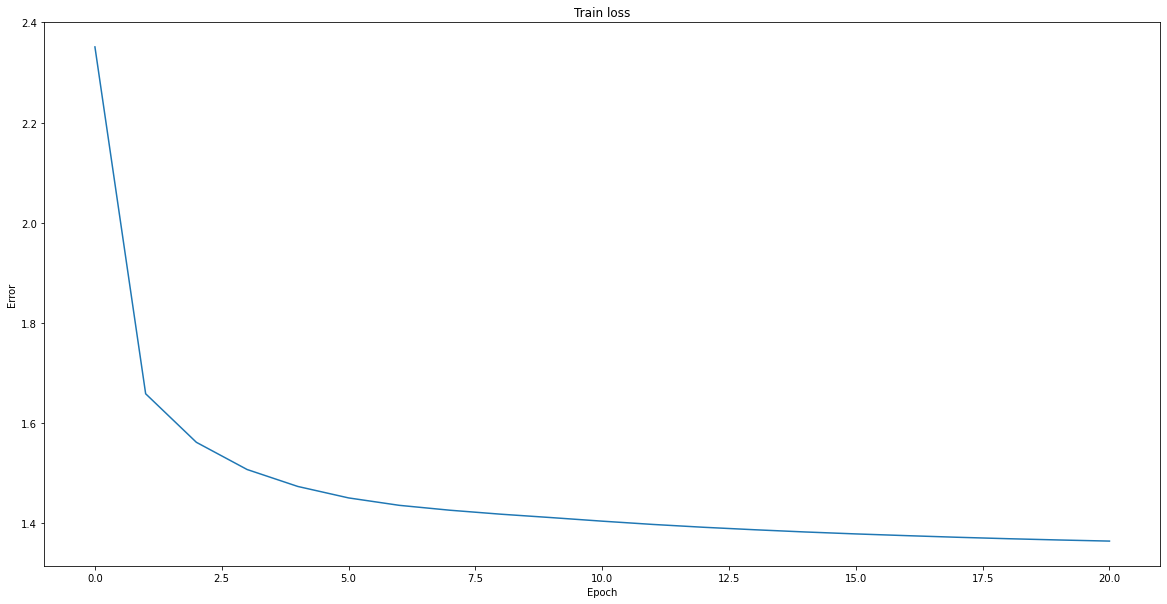

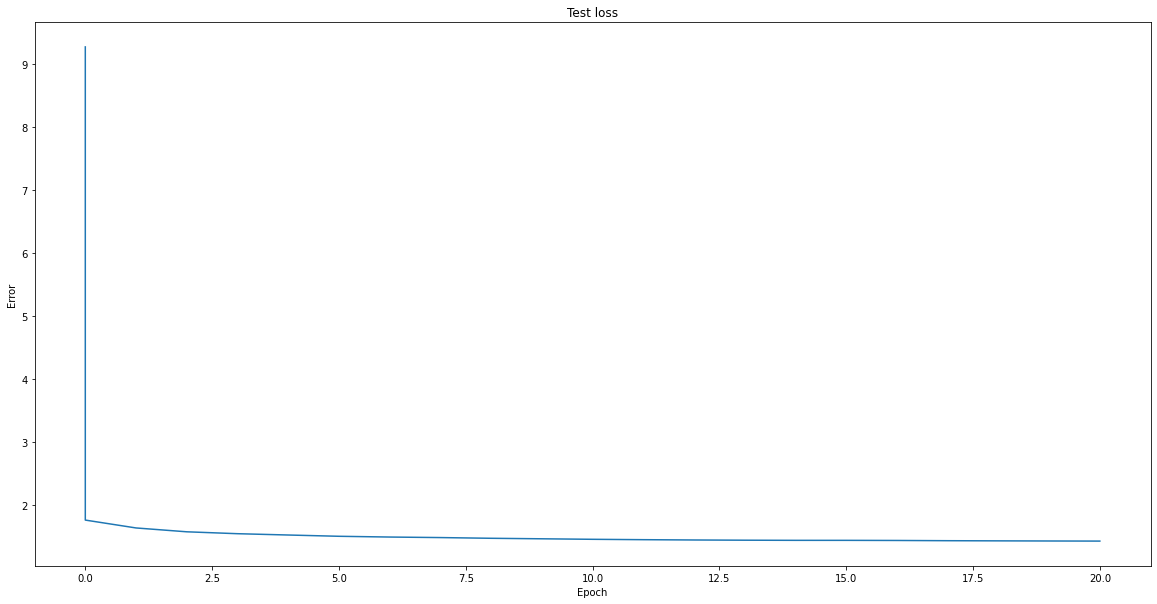

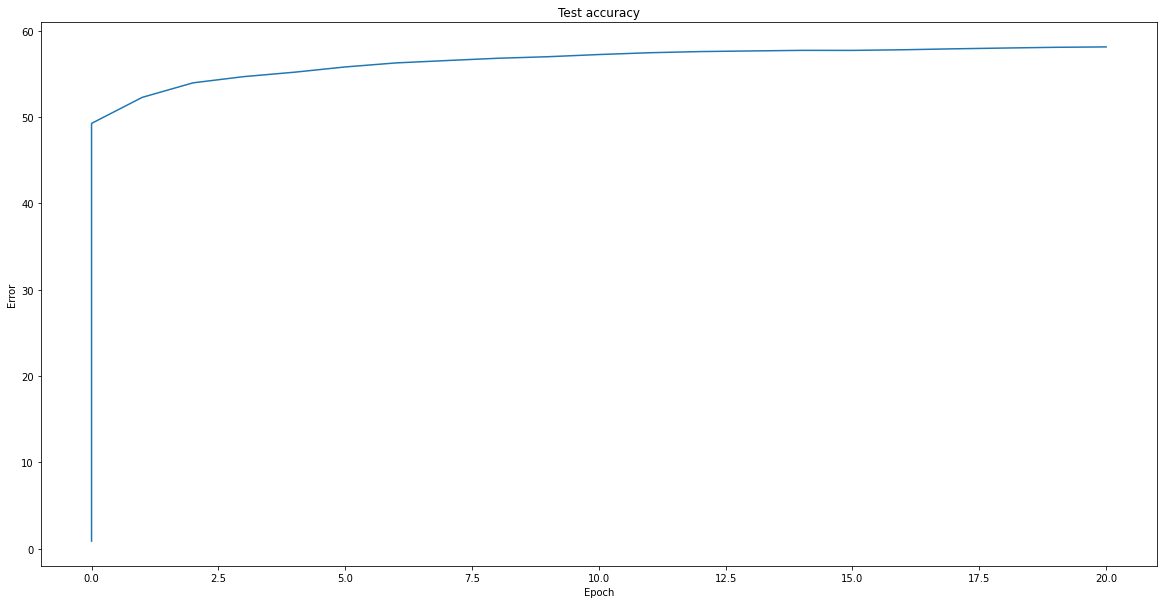

In [ ]:
# 3. LSTM
TEMPERATURE = 0.5

class LstmNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(LstmNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state) 
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

def lstm():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LstmNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints-lstm')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints-lstm/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints-lstm/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = lstm()

[('harry', 16731), ('potter', 1110), ('and', 27435), ('the', 51790), ('sorcerers', 31), ('stone', 389), ('chapter', 203), ('one', 2572), ('boy', 514), ('who', 2865), ('lived', 90), ('mr', 1270), ('mrs', 881), ('dursley', 86), ('of', 21779), ('number', 214), ('four', 285), ('privet', 87), ('drive', 119), ('were', 4736), ('proud', 53), ('to', 26952), ('say', 882), ('that', 9862), ('they', 5909), ('perfectly', 100), ('normal', 111), ('thank', 162), ('you', 12287), ('very', 2068), ('much', 1032), ('last', 1054), ('people', 915), ('youd', 284), ('expect', 153), ('be', 4462), ('involved', 39), ('in', 12642), ('anything', 732), ('strange', 124), ('or', 1616), ('mysterious', 34), ('because', 888), ('just', 2298), ('didnt', 1392), ('hold', 177), ('with', 6508), ('such', 282), ('nonsense', 22), ('was', 15623), ('director', 2), ('a', 20984), ('firm', 20), ('called', 380), ('grunnings', 3), ('which', 1477), ('made', 931), ('drills', 9), ('he', 20388), ('big', 180), ('beefy', 3), ('man', 479), ('ha

  1%|          | 1/106 [00:00<00:34,  3.02it/s]

Train Epoch: 0 [0/27136 (0%)]	Loss: 5.948842


 10%|█         | 11/106 [00:02<00:20,  4.66it/s]

Train Epoch: 0 [2560/27136 (9%)]	Loss: 6.371632


 20%|█▉        | 21/106 [00:04<00:18,  4.62it/s]

Train Epoch: 0 [5120/27136 (19%)]	Loss: 6.183752


 29%|██▉       | 31/106 [00:06<00:15,  4.72it/s]

Train Epoch: 0 [7680/27136 (28%)]	Loss: 6.070723


 39%|███▊      | 41/106 [00:08<00:13,  4.74it/s]

Train Epoch: 0 [10240/27136 (38%)]	Loss: 6.087572


 48%|████▊     | 51/106 [00:10<00:11,  4.61it/s]

Train Epoch: 0 [12800/27136 (47%)]	Loss: 5.853287


 58%|█████▊    | 61/106 [00:13<00:09,  4.81it/s]

Train Epoch: 0 [15360/27136 (57%)]	Loss: 6.182282


 67%|██████▋   | 71/106 [00:15<00:07,  4.69it/s]

Train Epoch: 0 [17920/27136 (66%)]	Loss: 6.035758


 76%|███████▋  | 81/106 [00:17<00:05,  4.75it/s]

Train Epoch: 0 [20480/27136 (75%)]	Loss: 5.818064


 86%|████████▌ | 91/106 [00:19<00:03,  4.77it/s]

Train Epoch: 0 [23040/27136 (85%)]	Loss: 5.929300


 95%|█████████▌| 101/106 [00:21<00:01,  4.71it/s]

Train Epoch: 0 [25600/27136 (94%)]	Loss: 5.993322


100%|██████████| 106/106 [00:22<00:00,  4.69it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	wand and was the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> that that a that of harry he i of in be be been it was think


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been it of the room of his and of the room to he to yes it i the th

  1%|          | 1/106 [00:00<00:37,  2.83it/s]

Train Epoch: 1 [0/27136 (0%)]	Loss: 5.720122


 10%|█         | 11/106 [00:02<00:20,  4.68it/s]

Train Epoch: 1 [2560/27136 (9%)]	Loss: 5.963206


 20%|█▉        | 21/106 [00:04<00:17,  4.78it/s]

Train Epoch: 1 [5120/27136 (19%)]	Loss: 5.934603


 29%|██▉       | 31/106 [00:06<00:15,  4.76it/s]

Train Epoch: 1 [7680/27136 (28%)]	Loss: 5.847738


 39%|███▊      | 41/106 [00:08<00:13,  4.74it/s]

Train Epoch: 1 [10240/27136 (38%)]	Loss: 5.896725


 48%|████▊     | 51/106 [00:10<00:11,  4.68it/s]

Train Epoch: 1 [12800/27136 (47%)]	Loss: 5.661960


 58%|█████▊    | 61/106 [00:12<00:09,  4.67it/s]

Train Epoch: 1 [15360/27136 (57%)]	Loss: 5.991957


 67%|██████▋   | 71/106 [00:15<00:07,  4.67it/s]

Train Epoch: 1 [17920/27136 (66%)]	Loss: 5.863187


 76%|███████▋  | 81/106 [00:17<00:05,  4.72it/s]

Train Epoch: 1 [20480/27136 (75%)]	Loss: 5.642746


 86%|████████▌ | 91/106 [00:19<00:03,  4.68it/s]

Train Epoch: 1 [23040/27136 (85%)]	Loss: 5.755961


 95%|█████████▌| 101/106 [00:21<00:01,  4.66it/s]

Train Epoch: 1 [25600/27136 (94%)]	Loss: 5.809553


100%|██████████| 106/106 [00:22<00:00,  4.70it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	wand and was the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> of <UNKNOWN> a the the dumbledore he i of in be be been it was can


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been it of the room of the and of the room to he of yes said 

  1%|          | 1/106 [00:00<00:38,  2.76it/s]

Train Epoch: 2 [0/27136 (0%)]	Loss: 5.686059


 10%|█         | 11/106 [00:02<00:19,  4.76it/s]

Train Epoch: 2 [2560/27136 (9%)]	Loss: 5.817955


 20%|█▉        | 21/106 [00:04<00:18,  4.71it/s]

Train Epoch: 2 [5120/27136 (19%)]	Loss: 5.800967


 29%|██▉       | 31/106 [00:06<00:15,  4.78it/s]

Train Epoch: 2 [7680/27136 (28%)]	Loss: 5.722744


 39%|███▊      | 41/106 [00:08<00:13,  4.78it/s]

Train Epoch: 2 [10240/27136 (38%)]	Loss: 5.780873


 48%|████▊     | 51/106 [00:10<00:11,  4.77it/s]

Train Epoch: 2 [12800/27136 (47%)]	Loss: 5.540284


 58%|█████▊    | 61/106 [00:13<00:09,  4.73it/s]

Train Epoch: 2 [15360/27136 (57%)]	Loss: 5.883925


 67%|██████▋   | 71/106 [00:15<00:07,  4.73it/s]

Train Epoch: 2 [17920/27136 (66%)]	Loss: 5.770606


 76%|███████▋  | 81/106 [00:17<00:05,  4.67it/s]

Train Epoch: 2 [20480/27136 (75%)]	Loss: 5.543967


 86%|████████▌ | 91/106 [00:19<00:03,  4.69it/s]

Train Epoch: 2 [23040/27136 (85%)]	Loss: 5.662369


 95%|█████████▌| 101/106 [00:21<00:01,  4.65it/s]

Train Epoch: 2 [25600/27136 (94%)]	Loss: 5.702707


100%|██████████| 106/106 [00:22<00:00,  4.69it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and was the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> of <UNKNOWN> a the the dumbledore and the of in be be been it but can


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room of the and of the room out be it

  1%|          | 1/106 [00:00<00:37,  2.77it/s]

Train Epoch: 3 [0/27136 (0%)]	Loss: 5.641571


 10%|█         | 11/106 [00:02<00:20,  4.74it/s]

Train Epoch: 3 [2560/27136 (9%)]	Loss: 5.724663


 20%|█▉        | 21/106 [00:04<00:18,  4.63it/s]

Train Epoch: 3 [5120/27136 (19%)]	Loss: 5.710322


 29%|██▉       | 31/106 [00:06<00:15,  4.73it/s]

Train Epoch: 3 [7680/27136 (28%)]	Loss: 5.647577


 39%|███▊      | 41/106 [00:08<00:13,  4.65it/s]

Train Epoch: 3 [10240/27136 (38%)]	Loss: 5.708035


 48%|████▊     | 51/106 [00:10<00:11,  4.75it/s]

Train Epoch: 3 [12800/27136 (47%)]	Loss: 5.469552


 58%|█████▊    | 61/106 [00:13<00:09,  4.71it/s]

Train Epoch: 3 [15360/27136 (57%)]	Loss: 5.809151


 67%|██████▋   | 71/106 [00:15<00:07,  4.75it/s]

Train Epoch: 3 [17920/27136 (66%)]	Loss: 5.709969


 76%|███████▋  | 81/106 [00:17<00:05,  4.73it/s]

Train Epoch: 3 [20480/27136 (75%)]	Loss: 5.484523


 86%|████████▌ | 91/106 [00:19<00:03,  4.72it/s]

Train Epoch: 3 [23040/27136 (85%)]	Loss: 5.581078


 95%|█████████▌| 101/106 [00:21<00:01,  4.62it/s]

Train Epoch: 3 [25600/27136 (94%)]	Loss: 5.635699


100%|██████████| 106/106 [00:22<00:00,  4.67it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and could the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> of <UNKNOWN> a the the harry he the of in be be been it but have


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room of the and of the room out be it ye

  1%|          | 1/106 [00:00<00:36,  2.87it/s]

Train Epoch: 4 [0/27136 (0%)]	Loss: 5.603268


 10%|█         | 11/106 [00:02<00:20,  4.60it/s]

Train Epoch: 4 [2560/27136 (9%)]	Loss: 5.665315


 20%|█▉        | 21/106 [00:04<00:18,  4.65it/s]

Train Epoch: 4 [5120/27136 (19%)]	Loss: 5.648579


 29%|██▉       | 31/106 [00:06<00:16,  4.62it/s]

Train Epoch: 4 [7680/27136 (28%)]	Loss: 5.607161


 39%|███▊      | 41/106 [00:08<00:13,  4.69it/s]

Train Epoch: 4 [10240/27136 (38%)]	Loss: 5.656693


 48%|████▊     | 51/106 [00:10<00:11,  4.72it/s]

Train Epoch: 4 [12800/27136 (47%)]	Loss: 5.418507


 58%|█████▊    | 61/106 [00:13<00:09,  4.62it/s]

Train Epoch: 4 [15360/27136 (57%)]	Loss: 5.753253


 67%|██████▋   | 71/106 [00:15<00:07,  4.62it/s]

Train Epoch: 4 [17920/27136 (66%)]	Loss: 5.675131


 76%|███████▋  | 81/106 [00:17<00:05,  4.67it/s]

Train Epoch: 4 [20480/27136 (75%)]	Loss: 5.449140


 86%|████████▌ | 91/106 [00:19<00:03,  4.67it/s]

Train Epoch: 4 [23040/27136 (85%)]	Loss: 5.535823


 95%|█████████▌| 101/106 [00:21<00:01,  4.75it/s]

Train Epoch: 4 [25600/27136 (94%)]	Loss: 5.591173


100%|██████████| 106/106 [00:22<00:00,  4.67it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and could the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> of not a the the harry and the of in be be been it but said


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room to be of yes sai

  1%|          | 1/106 [00:00<00:37,  2.79it/s]

Train Epoch: 5 [0/27136 (0%)]	Loss: 5.576197


 10%|█         | 11/106 [00:02<00:20,  4.63it/s]

Train Epoch: 5 [2560/27136 (9%)]	Loss: 5.628874


 20%|█▉        | 21/106 [00:04<00:17,  4.73it/s]

Train Epoch: 5 [5120/27136 (19%)]	Loss: 5.611757


 29%|██▉       | 31/106 [00:06<00:16,  4.63it/s]

Train Epoch: 5 [7680/27136 (28%)]	Loss: 5.576853


 39%|███▊      | 41/106 [00:08<00:13,  4.65it/s]

Train Epoch: 5 [10240/27136 (38%)]	Loss: 5.623970


 48%|████▊     | 51/106 [00:11<00:11,  4.70it/s]

Train Epoch: 5 [12800/27136 (47%)]	Loss: 5.390658


 58%|█████▊    | 61/106 [00:13<00:09,  4.61it/s]

Train Epoch: 5 [15360/27136 (57%)]	Loss: 5.719435


 67%|██████▋   | 71/106 [00:15<00:07,  4.65it/s]

Train Epoch: 5 [17920/27136 (66%)]	Loss: 5.648026


 76%|███████▋  | 81/106 [00:17<00:05,  4.64it/s]

Train Epoch: 5 [20480/27136 (75%)]	Loss: 5.427009


 86%|████████▌ | 91/106 [00:19<00:03,  4.74it/s]

Train Epoch: 5 [23040/27136 (85%)]	Loss: 5.510095


 95%|█████████▌| 101/106 [00:21<00:01,  4.68it/s]

Train Epoch: 5 [25600/27136 (94%)]	Loss: 5.554134


100%|██████████| 106/106 [00:22<00:00,  4.64it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and was the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> of the a the the harry and the of in be be been it but said


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room to be of yes said 

  1%|          | 1/106 [00:00<00:37,  2.78it/s]

Train Epoch: 6 [0/27136 (0%)]	Loss: 5.556679


 10%|█         | 11/106 [00:02<00:20,  4.62it/s]

Train Epoch: 6 [2560/27136 (9%)]	Loss: 5.607992


 20%|█▉        | 21/106 [00:04<00:18,  4.59it/s]

Train Epoch: 6 [5120/27136 (19%)]	Loss: 5.589201


 29%|██▉       | 31/106 [00:06<00:16,  4.67it/s]

Train Epoch: 6 [7680/27136 (28%)]	Loss: 5.556144


 39%|███▊      | 41/106 [00:08<00:14,  4.57it/s]

Train Epoch: 6 [10240/27136 (38%)]	Loss: 5.606218


 48%|████▊     | 51/106 [00:11<00:11,  4.69it/s]

Train Epoch: 6 [12800/27136 (47%)]	Loss: 5.373356


 58%|█████▊    | 61/106 [00:13<00:09,  4.72it/s]

Train Epoch: 6 [15360/27136 (57%)]	Loss: 5.700886


 67%|██████▋   | 71/106 [00:15<00:07,  4.62it/s]

Train Epoch: 6 [17920/27136 (66%)]	Loss: 5.632720


 76%|███████▋  | 81/106 [00:17<00:05,  4.67it/s]

Train Epoch: 6 [20480/27136 (75%)]	Loss: 5.403330


 86%|████████▌ | 91/106 [00:19<00:03,  4.63it/s]

Train Epoch: 6 [23040/27136 (85%)]	Loss: 5.496971


 95%|█████████▌| 101/106 [00:21<00:01,  4.71it/s]

Train Epoch: 6 [25600/27136 (94%)]	Loss: 5.534817


100%|██████████| 106/106 [00:22<00:00,  4.64it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and could the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> of not a the the harry and the of in be be been it but would


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room to be to harry 

  1%|          | 1/106 [00:00<00:37,  2.78it/s]

Train Epoch: 7 [0/27136 (0%)]	Loss: 5.547007


 10%|█         | 11/106 [00:02<00:20,  4.59it/s]

Train Epoch: 7 [2560/27136 (9%)]	Loss: 5.599293


 20%|█▉        | 21/106 [00:04<00:18,  4.61it/s]

Train Epoch: 7 [5120/27136 (19%)]	Loss: 5.575714


 29%|██▉       | 31/106 [00:06<00:16,  4.68it/s]

Train Epoch: 7 [7680/27136 (28%)]	Loss: 5.545310


 39%|███▊      | 41/106 [00:08<00:13,  4.64it/s]

Train Epoch: 7 [10240/27136 (38%)]	Loss: 5.593832


 48%|████▊     | 51/106 [00:11<00:11,  4.65it/s]

Train Epoch: 7 [12800/27136 (47%)]	Loss: 5.362067


 58%|█████▊    | 61/106 [00:13<00:09,  4.64it/s]

Train Epoch: 7 [15360/27136 (57%)]	Loss: 5.681132


 67%|██████▋   | 71/106 [00:15<00:07,  4.64it/s]

Train Epoch: 7 [17920/27136 (66%)]	Loss: 5.621454


 76%|███████▋  | 81/106 [00:17<00:05,  4.61it/s]

Train Epoch: 7 [20480/27136 (75%)]	Loss: 5.388006


 86%|████████▌ | 91/106 [00:19<00:03,  4.66it/s]

Train Epoch: 7 [23040/27136 (85%)]	Loss: 5.481251


 95%|█████████▌| 101/106 [00:21<00:01,  4.62it/s]

Train Epoch: 7 [25600/27136 (94%)]	Loss: 5.524253


100%|██████████| 106/106 [00:22<00:00,  4.62it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and was the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> was not a the the harry and the of in not be been it was would


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room to be to no sai

  1%|          | 1/106 [00:00<00:37,  2.80it/s]

Train Epoch: 8 [0/27136 (0%)]	Loss: 5.538286


 10%|█         | 11/106 [00:02<00:20,  4.67it/s]

Train Epoch: 8 [2560/27136 (9%)]	Loss: 5.590461


 20%|█▉        | 21/106 [00:04<00:18,  4.69it/s]

Train Epoch: 8 [5120/27136 (19%)]	Loss: 5.568818


 29%|██▉       | 31/106 [00:06<00:16,  4.58it/s]

Train Epoch: 8 [7680/27136 (28%)]	Loss: 5.527728


 39%|███▊      | 41/106 [00:08<00:13,  4.69it/s]

Train Epoch: 8 [10240/27136 (38%)]	Loss: 5.586077


 48%|████▊     | 51/106 [00:11<00:11,  4.67it/s]

Train Epoch: 8 [12800/27136 (47%)]	Loss: 5.355658


 58%|█████▊    | 61/106 [00:13<00:09,  4.62it/s]

Train Epoch: 8 [15360/27136 (57%)]	Loss: 5.669800


 67%|██████▋   | 71/106 [00:15<00:07,  4.69it/s]

Train Epoch: 8 [17920/27136 (66%)]	Loss: 5.611419


 76%|███████▋  | 81/106 [00:17<00:05,  4.65it/s]

Train Epoch: 8 [20480/27136 (75%)]	Loss: 5.381347


 86%|████████▌ | 91/106 [00:19<00:03,  4.58it/s]

Train Epoch: 8 [23040/27136 (85%)]	Loss: 5.469285


 95%|█████████▌| 101/106 [00:21<00:01,  4.65it/s]

Train Epoch: 8 [25600/27136 (94%)]	Loss: 5.520958


100%|██████████| 106/106 [00:22<00:00,  4.63it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and was the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> was not a the the harry and the of in not be been it was would


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room and be the said

  1%|          | 1/106 [00:00<00:36,  2.84it/s]

Train Epoch: 9 [0/27136 (0%)]	Loss: 5.534964


 10%|█         | 11/106 [00:02<00:20,  4.68it/s]

Train Epoch: 9 [2560/27136 (9%)]	Loss: 5.581917


 20%|█▉        | 21/106 [00:04<00:18,  4.63it/s]

Train Epoch: 9 [5120/27136 (19%)]	Loss: 5.566359


 29%|██▉       | 31/106 [00:06<00:16,  4.60it/s]

Train Epoch: 9 [7680/27136 (28%)]	Loss: 5.524768


 39%|███▊      | 41/106 [00:08<00:13,  4.65it/s]

Train Epoch: 9 [10240/27136 (38%)]	Loss: 5.580648


 48%|████▊     | 51/106 [00:11<00:12,  4.58it/s]

Train Epoch: 9 [12800/27136 (47%)]	Loss: 5.350554


 58%|█████▊    | 61/106 [00:13<00:09,  4.71it/s]

Train Epoch: 9 [15360/27136 (57%)]	Loss: 5.663004


 67%|██████▋   | 71/106 [00:15<00:07,  4.69it/s]

Train Epoch: 9 [17920/27136 (66%)]	Loss: 5.607172


 76%|███████▋  | 81/106 [00:17<00:05,  4.61it/s]

Train Epoch: 9 [20480/27136 (75%)]	Loss: 5.379353


 86%|████████▌ | 91/106 [00:19<00:03,  4.65it/s]

Train Epoch: 9 [23040/27136 (85%)]	Loss: 5.468226


 95%|█████████▌| 101/106 [00:21<00:01,  4.70it/s]

Train Epoch: 9 [25600/27136 (94%)]	Loss: 5.515365


100%|██████████| 106/106 [00:22<00:00,  4.63it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and was the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> was not a the and harry and the of in not be been it was know


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room and be it said s

  1%|          | 1/106 [00:00<00:37,  2.82it/s]

Train Epoch: 10 [0/27136 (0%)]	Loss: 5.538429


 10%|█         | 11/106 [00:02<00:20,  4.61it/s]

Train Epoch: 10 [2560/27136 (9%)]	Loss: 5.581712


 20%|█▉        | 21/106 [00:04<00:17,  4.73it/s]

Train Epoch: 10 [5120/27136 (19%)]	Loss: 5.568603


 29%|██▉       | 31/106 [00:06<00:15,  4.70it/s]

Train Epoch: 10 [7680/27136 (28%)]	Loss: 5.525134


 39%|███▊      | 41/106 [00:08<00:13,  4.67it/s]

Train Epoch: 10 [10240/27136 (38%)]	Loss: 5.578321


 48%|████▊     | 51/106 [00:11<00:11,  4.66it/s]

Train Epoch: 10 [12800/27136 (47%)]	Loss: 5.350453


 58%|█████▊    | 61/106 [00:13<00:09,  4.57it/s]

Train Epoch: 10 [15360/27136 (57%)]	Loss: 5.655370


 67%|██████▋   | 71/106 [00:15<00:07,  4.64it/s]

Train Epoch: 10 [17920/27136 (66%)]	Loss: 5.605848


 76%|███████▋  | 81/106 [00:17<00:05,  4.67it/s]

Train Epoch: 10 [20480/27136 (75%)]	Loss: 5.378865


 86%|████████▌ | 91/106 [00:19<00:03,  4.72it/s]

Train Epoch: 10 [23040/27136 (85%)]	Loss: 5.461307


 95%|█████████▌| 101/106 [00:21<00:01,  4.64it/s]

Train Epoch: 10 [25600/27136 (94%)]	Loss: 5.517103


100%|██████████| 106/106 [00:22<00:00,  4.64it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and was the eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was not a the and harry and the of in not be been it was would


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room and see the said 

  1%|          | 1/106 [00:00<00:36,  2.90it/s]

Train Epoch: 11 [0/27136 (0%)]	Loss: 5.538531


 10%|█         | 11/106 [00:02<00:20,  4.63it/s]

Train Epoch: 11 [2560/27136 (9%)]	Loss: 5.583718


 20%|█▉        | 21/106 [00:04<00:18,  4.58it/s]

Train Epoch: 11 [5120/27136 (19%)]	Loss: 5.568412


 29%|██▉       | 31/106 [00:06<00:16,  4.67it/s]

Train Epoch: 11 [7680/27136 (28%)]	Loss: 5.524626


 39%|███▊      | 41/106 [00:08<00:13,  4.68it/s]

Train Epoch: 11 [10240/27136 (38%)]	Loss: 5.579585


 48%|████▊     | 51/106 [00:11<00:11,  4.60it/s]

Train Epoch: 11 [12800/27136 (47%)]	Loss: 5.349809


 58%|█████▊    | 61/106 [00:13<00:09,  4.70it/s]

Train Epoch: 11 [15360/27136 (57%)]	Loss: 5.650162


 67%|██████▋   | 71/106 [00:15<00:07,  4.65it/s]

Train Epoch: 11 [17920/27136 (66%)]	Loss: 5.600406


 76%|███████▋  | 81/106 [00:17<00:05,  4.58it/s]

Train Epoch: 11 [20480/27136 (75%)]	Loss: 5.377204


 86%|████████▌ | 91/106 [00:19<00:03,  4.66it/s]

Train Epoch: 11 [23040/27136 (85%)]	Loss: 5.464278


 95%|█████████▌| 101/106 [00:21<00:01,  4.60it/s]

Train Epoch: 11 [25600/27136 (94%)]	Loss: 5.516706


100%|██████████| 106/106 [00:22<00:00,  4.61it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and had the eyes and into the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry and and of in not be been it was would


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room and see t

  1%|          | 1/106 [00:00<00:37,  2.80it/s]

Train Epoch: 12 [0/27136 (0%)]	Loss: 5.545099


 10%|█         | 11/106 [00:02<00:20,  4.62it/s]

Train Epoch: 12 [2560/27136 (9%)]	Loss: 5.586447


 20%|█▉        | 21/106 [00:04<00:18,  4.64it/s]

Train Epoch: 12 [5120/27136 (19%)]	Loss: 5.571279


 29%|██▉       | 31/106 [00:06<00:16,  4.62it/s]

Train Epoch: 12 [7680/27136 (28%)]	Loss: 5.522586


 39%|███▊      | 41/106 [00:08<00:14,  4.63it/s]

Train Epoch: 12 [10240/27136 (38%)]	Loss: 5.576298


 48%|████▊     | 51/106 [00:11<00:11,  4.69it/s]

Train Epoch: 12 [12800/27136 (47%)]	Loss: 5.351973


 58%|█████▊    | 61/106 [00:13<00:09,  4.75it/s]

Train Epoch: 12 [15360/27136 (57%)]	Loss: 5.647147


 67%|██████▋   | 71/106 [00:15<00:07,  4.70it/s]

Train Epoch: 12 [17920/27136 (66%)]	Loss: 5.600931


 76%|███████▋  | 81/106 [00:17<00:05,  4.58it/s]

Train Epoch: 12 [20480/27136 (75%)]	Loss: 5.379165


 86%|████████▌ | 91/106 [00:19<00:03,  4.68it/s]

Train Epoch: 12 [23040/27136 (85%)]	Loss: 5.465159


 95%|█████████▌| 101/106 [00:21<00:01,  4.68it/s]

Train Epoch: 12 [25600/27136 (94%)]	Loss: 5.516089


100%|██████████| 106/106 [00:22<00:00,  4.64it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and had his eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry and and of in not be been it to would


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been in of the room and the and of the room and see the s

  1%|          | 1/106 [00:00<00:38,  2.72it/s]

Train Epoch: 13 [0/27136 (0%)]	Loss: 5.541240


 10%|█         | 11/106 [00:02<00:20,  4.66it/s]

Train Epoch: 13 [2560/27136 (9%)]	Loss: 5.582490


 20%|█▉        | 21/106 [00:04<00:18,  4.67it/s]

Train Epoch: 13 [5120/27136 (19%)]	Loss: 5.568052


 29%|██▉       | 31/106 [00:06<00:16,  4.60it/s]

Train Epoch: 13 [7680/27136 (28%)]	Loss: 5.519544


 39%|███▊      | 41/106 [00:08<00:13,  4.68it/s]

Train Epoch: 13 [10240/27136 (38%)]	Loss: 5.574630


 48%|████▊     | 51/106 [00:11<00:11,  4.61it/s]

Train Epoch: 13 [12800/27136 (47%)]	Loss: 5.355366


 58%|█████▊    | 61/106 [00:13<00:09,  4.66it/s]

Train Epoch: 13 [15360/27136 (57%)]	Loss: 5.646561


 67%|██████▋   | 71/106 [00:15<00:07,  4.71it/s]

Train Epoch: 13 [17920/27136 (66%)]	Loss: 5.598240


 76%|███████▋  | 81/106 [00:17<00:05,  4.58it/s]

Train Epoch: 13 [20480/27136 (75%)]	Loss: 5.380322


 86%|████████▌ | 91/106 [00:19<00:03,  4.65it/s]

Train Epoch: 13 [23040/27136 (85%)]	Loss: 5.470603


 95%|█████████▌| 101/106 [00:21<00:01,  4.72it/s]

Train Epoch: 13 [25600/27136 (94%)]	Loss: 5.515195


100%|██████████| 106/106 [00:22<00:00,  4.62it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and had the eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry and a of in not be been it was would


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been in of the room and the and of the room and see the sa

  1%|          | 1/106 [00:00<00:38,  2.73it/s]

Train Epoch: 14 [0/27136 (0%)]	Loss: 5.541260


 10%|█         | 11/106 [00:02<00:20,  4.58it/s]

Train Epoch: 14 [2560/27136 (9%)]	Loss: 5.583951


 20%|█▉        | 21/106 [00:04<00:18,  4.67it/s]

Train Epoch: 14 [5120/27136 (19%)]	Loss: 5.566078


 29%|██▉       | 31/106 [00:06<00:16,  4.65it/s]

Train Epoch: 14 [7680/27136 (28%)]	Loss: 5.520771


 39%|███▊      | 41/106 [00:08<00:14,  4.64it/s]

Train Epoch: 14 [10240/27136 (38%)]	Loss: 5.581077


 48%|████▊     | 51/106 [00:11<00:11,  4.66it/s]

Train Epoch: 14 [12800/27136 (47%)]	Loss: 5.358785


 58%|█████▊    | 61/106 [00:13<00:09,  4.70it/s]

Train Epoch: 14 [15360/27136 (57%)]	Loss: 5.644091


 67%|██████▋   | 71/106 [00:15<00:07,  4.58it/s]

Train Epoch: 14 [17920/27136 (66%)]	Loss: 5.603659


 76%|███████▋  | 81/106 [00:17<00:05,  4.69it/s]

Train Epoch: 14 [20480/27136 (75%)]	Loss: 5.381168


 86%|████████▌ | 91/106 [00:19<00:03,  4.69it/s]

Train Epoch: 14 [23040/27136 (85%)]	Loss: 5.469500


 95%|█████████▌| 101/106 [00:21<00:01,  4.66it/s]

Train Epoch: 14 [25600/27136 (94%)]	Loss: 5.514725


100%|██████████| 106/106 [00:22<00:00,  4.63it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and had the eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry and a of in not be been it to would


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been in of the room and the and of the room and see the sai

  1%|          | 1/106 [00:00<00:36,  2.85it/s]

Train Epoch: 15 [0/27136 (0%)]	Loss: 5.542460


 10%|█         | 11/106 [00:02<00:20,  4.60it/s]

Train Epoch: 15 [2560/27136 (9%)]	Loss: 5.583121


 20%|█▉        | 21/106 [00:04<00:18,  4.61it/s]

Train Epoch: 15 [5120/27136 (19%)]	Loss: 5.570010


 29%|██▉       | 31/106 [00:06<00:15,  4.69it/s]

Train Epoch: 15 [7680/27136 (28%)]	Loss: 5.519484


 39%|███▊      | 41/106 [00:08<00:14,  4.59it/s]

Train Epoch: 15 [10240/27136 (38%)]	Loss: 5.583095


 48%|████▊     | 51/106 [00:11<00:11,  4.70it/s]

Train Epoch: 15 [12800/27136 (47%)]	Loss: 5.361772


 58%|█████▊    | 61/106 [00:13<00:09,  4.68it/s]

Train Epoch: 15 [15360/27136 (57%)]	Loss: 5.642180


 67%|██████▋   | 71/106 [00:15<00:07,  4.58it/s]

Train Epoch: 15 [17920/27136 (66%)]	Loss: 5.599661


 76%|███████▋  | 81/106 [00:17<00:05,  4.68it/s]

Train Epoch: 15 [20480/27136 (75%)]	Loss: 5.383307


 86%|████████▌ | 91/106 [00:19<00:03,  4.73it/s]

Train Epoch: 15 [23040/27136 (85%)]	Loss: 5.471492


 95%|█████████▌| 101/106 [00:21<00:01,  4.65it/s]

Train Epoch: 15 [25600/27136 (94%)]	Loss: 5.517086


100%|██████████| 106/106 [00:22<00:00,  4.63it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and had the eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry and the of the not be been that to know


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been in of the room and the and of the room and be the 

  1%|          | 1/106 [00:00<00:36,  2.89it/s]

Train Epoch: 16 [0/27136 (0%)]	Loss: 5.543254


 10%|█         | 11/106 [00:02<00:20,  4.63it/s]

Train Epoch: 16 [2560/27136 (9%)]	Loss: 5.588603


 20%|█▉        | 21/106 [00:04<00:18,  4.66it/s]

Train Epoch: 16 [5120/27136 (19%)]	Loss: 5.571154


 29%|██▉       | 31/106 [00:06<00:16,  4.65it/s]

Train Epoch: 16 [7680/27136 (28%)]	Loss: 5.516854


 39%|███▊      | 41/106 [00:08<00:13,  4.67it/s]

Train Epoch: 16 [10240/27136 (38%)]	Loss: 5.580707


 48%|████▊     | 51/106 [00:11<00:12,  4.58it/s]

Train Epoch: 16 [12800/27136 (47%)]	Loss: 5.364981


 58%|█████▊    | 61/106 [00:13<00:09,  4.71it/s]

Train Epoch: 16 [15360/27136 (57%)]	Loss: 5.637204


 67%|██████▋   | 71/106 [00:15<00:07,  4.67it/s]

Train Epoch: 16 [17920/27136 (66%)]	Loss: 5.595434


 76%|███████▋  | 81/106 [00:17<00:05,  4.69it/s]

Train Epoch: 16 [20480/27136 (75%)]	Loss: 5.384056


 86%|████████▌ | 91/106 [00:19<00:03,  4.62it/s]

Train Epoch: 16 [23040/27136 (85%)]	Loss: 5.469778


 95%|█████████▌| 101/106 [00:21<00:01,  4.67it/s]

Train Epoch: 16 [25600/27136 (94%)]	Loss: 5.515570


100%|██████████| 106/106 [00:22<00:00,  4.63it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and was his eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry he the of the not be been it for know


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room to you the s

  1%|          | 1/106 [00:00<00:38,  2.75it/s]

Train Epoch: 17 [0/27136 (0%)]	Loss: 5.539994


 10%|█         | 11/106 [00:02<00:20,  4.58it/s]

Train Epoch: 17 [2560/27136 (9%)]	Loss: 5.591424


 20%|█▉        | 21/106 [00:04<00:18,  4.63it/s]

Train Epoch: 17 [5120/27136 (19%)]	Loss: 5.573145


 29%|██▉       | 31/106 [00:06<00:16,  4.65it/s]

Train Epoch: 17 [7680/27136 (28%)]	Loss: 5.518326


 39%|███▊      | 41/106 [00:08<00:14,  4.63it/s]

Train Epoch: 17 [10240/27136 (38%)]	Loss: 5.582491


 48%|████▊     | 51/106 [00:11<00:11,  4.60it/s]

Train Epoch: 17 [12800/27136 (47%)]	Loss: 5.366154


 58%|█████▊    | 61/106 [00:13<00:09,  4.69it/s]

Train Epoch: 17 [15360/27136 (57%)]	Loss: 5.636666


 67%|██████▋   | 71/106 [00:15<00:07,  4.65it/s]

Train Epoch: 17 [17920/27136 (66%)]	Loss: 5.592773


 76%|███████▋  | 81/106 [00:17<00:05,  4.65it/s]

Train Epoch: 17 [20480/27136 (75%)]	Loss: 5.383011


 86%|████████▌ | 91/106 [00:19<00:03,  4.65it/s]

Train Epoch: 17 [23040/27136 (85%)]	Loss: 5.467276


 95%|█████████▌| 101/106 [00:21<00:01,  4.71it/s]

Train Epoch: 17 [25600/27136 (94%)]	Loss: 5.516272


100%|██████████| 106/106 [00:22<00:00,  4.62it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and had his eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry he his of in not be been it for know


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room to you the sa

  1%|          | 1/106 [00:00<00:37,  2.81it/s]

Train Epoch: 18 [0/27136 (0%)]	Loss: 5.541976


 10%|█         | 11/106 [00:02<00:20,  4.68it/s]

Train Epoch: 18 [2560/27136 (9%)]	Loss: 5.583693


 20%|█▉        | 21/106 [00:04<00:18,  4.70it/s]

Train Epoch: 18 [5120/27136 (19%)]	Loss: 5.572266


 29%|██▉       | 31/106 [00:06<00:16,  4.67it/s]

Train Epoch: 18 [7680/27136 (28%)]	Loss: 5.521214


 39%|███▊      | 41/106 [00:08<00:13,  4.72it/s]

Train Epoch: 18 [10240/27136 (38%)]	Loss: 5.585684


 48%|████▊     | 51/106 [00:10<00:11,  4.61it/s]

Train Epoch: 18 [12800/27136 (47%)]	Loss: 5.368758


 58%|█████▊    | 61/106 [00:13<00:09,  4.64it/s]

Train Epoch: 18 [15360/27136 (57%)]	Loss: 5.633935


 67%|██████▋   | 71/106 [00:15<00:07,  4.67it/s]

Train Epoch: 18 [17920/27136 (66%)]	Loss: 5.593354


 76%|███████▋  | 81/106 [00:17<00:05,  4.67it/s]

Train Epoch: 18 [20480/27136 (75%)]	Loss: 5.381971


 86%|████████▌ | 91/106 [00:19<00:03,  4.60it/s]

Train Epoch: 18 [23040/27136 (85%)]	Loss: 5.465896


 95%|█████████▌| 101/106 [00:21<00:01,  4.63it/s]

Train Epoch: 18 [25600/27136 (94%)]	Loss: 5.514356


100%|██████████| 106/106 [00:22<00:00,  4.65it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and had his eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry and his of in not be been the for know


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room and see the

  1%|          | 1/106 [00:00<00:37,  2.83it/s]

Train Epoch: 19 [0/27136 (0%)]	Loss: 5.539031


 10%|█         | 11/106 [00:02<00:20,  4.65it/s]

Train Epoch: 19 [2560/27136 (9%)]	Loss: 5.579454


 20%|█▉        | 21/106 [00:04<00:18,  4.63it/s]

Train Epoch: 19 [5120/27136 (19%)]	Loss: 5.570694


 29%|██▉       | 31/106 [00:06<00:16,  4.67it/s]

Train Epoch: 19 [7680/27136 (28%)]	Loss: 5.521529


 39%|███▊      | 41/106 [00:08<00:13,  4.69it/s]

Train Epoch: 19 [10240/27136 (38%)]	Loss: 5.587101


 48%|████▊     | 51/106 [00:11<00:12,  4.58it/s]

Train Epoch: 19 [12800/27136 (47%)]	Loss: 5.366039


 58%|█████▊    | 61/106 [00:13<00:09,  4.61it/s]

Train Epoch: 19 [15360/27136 (57%)]	Loss: 5.633488


 67%|██████▋   | 71/106 [00:15<00:07,  4.68it/s]

Train Epoch: 19 [17920/27136 (66%)]	Loss: 5.590697


 76%|███████▋  | 81/106 [00:17<00:05,  4.60it/s]

Train Epoch: 19 [20480/27136 (75%)]	Loss: 5.378728


 86%|████████▌ | 91/106 [00:19<00:03,  4.67it/s]

Train Epoch: 19 [23040/27136 (85%)]	Loss: 5.467072


 95%|█████████▌| 101/106 [00:21<00:01,  4.73it/s]

Train Epoch: 19 [25600/27136 (94%)]	Loss: 5.513392


100%|██████████| 106/106 [00:22<00:00,  4.64it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and had the eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> a the and harry he the of the not be been the was know


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room and see the

  1%|          | 1/106 [00:00<00:36,  2.86it/s]

Train Epoch: 20 [0/27136 (0%)]	Loss: 5.539456


 10%|█         | 11/106 [00:02<00:20,  4.63it/s]

Train Epoch: 20 [2560/27136 (9%)]	Loss: 5.583404


 20%|█▉        | 21/106 [00:04<00:18,  4.62it/s]

Train Epoch: 20 [5120/27136 (19%)]	Loss: 5.572335


 29%|██▉       | 31/106 [00:06<00:16,  4.59it/s]

Train Epoch: 20 [7680/27136 (28%)]	Loss: 5.522403


 39%|███▊      | 41/106 [00:08<00:13,  4.66it/s]

Train Epoch: 20 [10240/27136 (38%)]	Loss: 5.581603


 48%|████▊     | 51/106 [00:11<00:11,  4.61it/s]

Train Epoch: 20 [12800/27136 (47%)]	Loss: 5.361478


 58%|█████▊    | 61/106 [00:13<00:09,  4.64it/s]

Train Epoch: 20 [15360/27136 (57%)]	Loss: 5.633832


 67%|██████▋   | 71/106 [00:15<00:07,  4.71it/s]

Train Epoch: 20 [17920/27136 (66%)]	Loss: 5.590300


 76%|███████▋  | 81/106 [00:17<00:05,  4.70it/s]

Train Epoch: 20 [20480/27136 (75%)]	Loss: 5.379609


 86%|████████▌ | 91/106 [00:19<00:03,  4.62it/s]

Train Epoch: 20 [23040/27136 (85%)]	Loss: 5.468864


 95%|█████████▌| 101/106 [00:21<00:01,  4.66it/s]

Train Epoch: 20 [25600/27136 (94%)]	Loss: 5.512205


100%|██████████| 106/106 [00:22<00:00,  4.64it/s]


Input	his shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you
GT	shoulders harry <UNKNOWN> his headmaster back around the lake bearing most of his weight the protection was after all <UNKNOWN> said dumbledore faintly one alone could not have done it you did
pred	<UNKNOWN> and was the eyes and to the room and the of the <UNKNOWN> and <UNKNOWN> was <UNKNOWN> the the and harry he the of the not be been it was know


Input	had just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating
GT	just flown out of the fireplace behind him out of the way cant y oh sorry runcorn clearly frightened the balding wizard hurried away apparently the man who harry was impersonating runcorn
pred	been been the of the room and the and of the room and you th

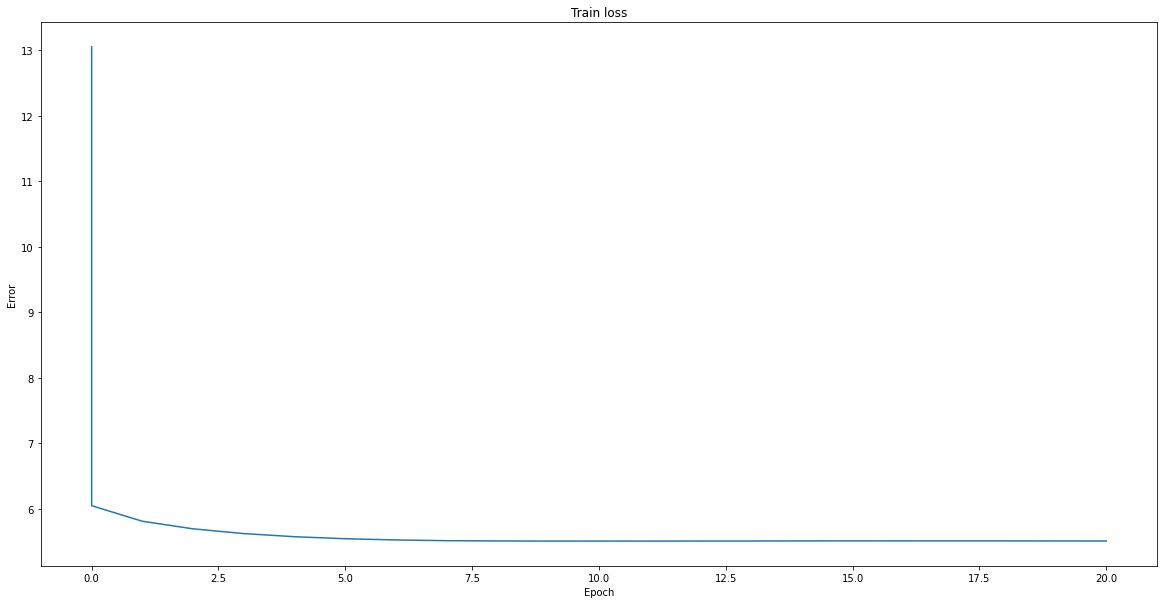

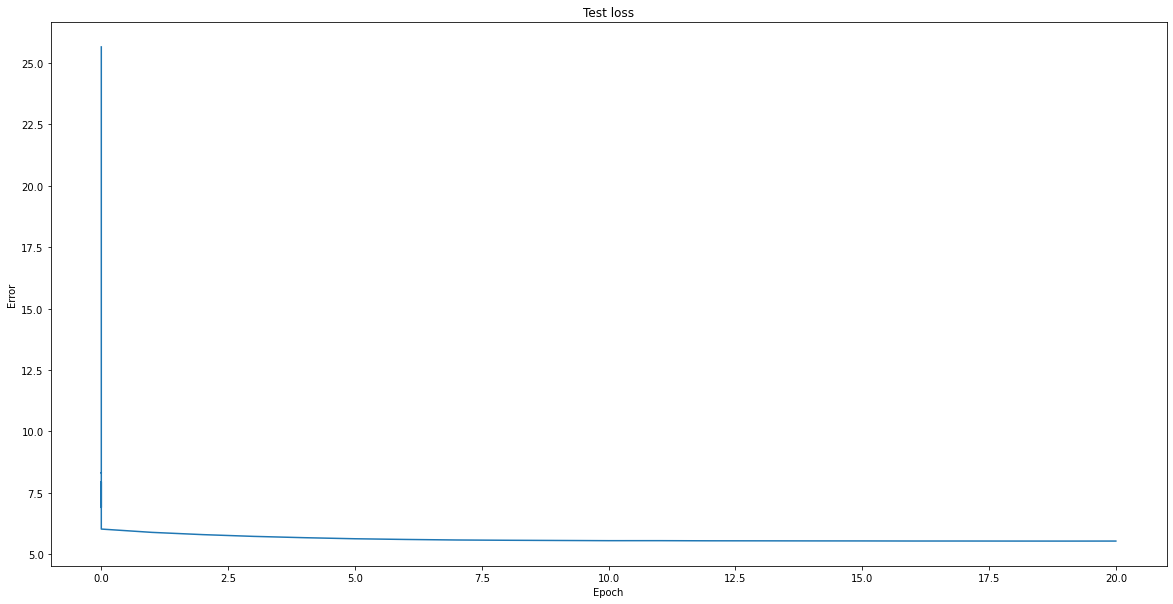

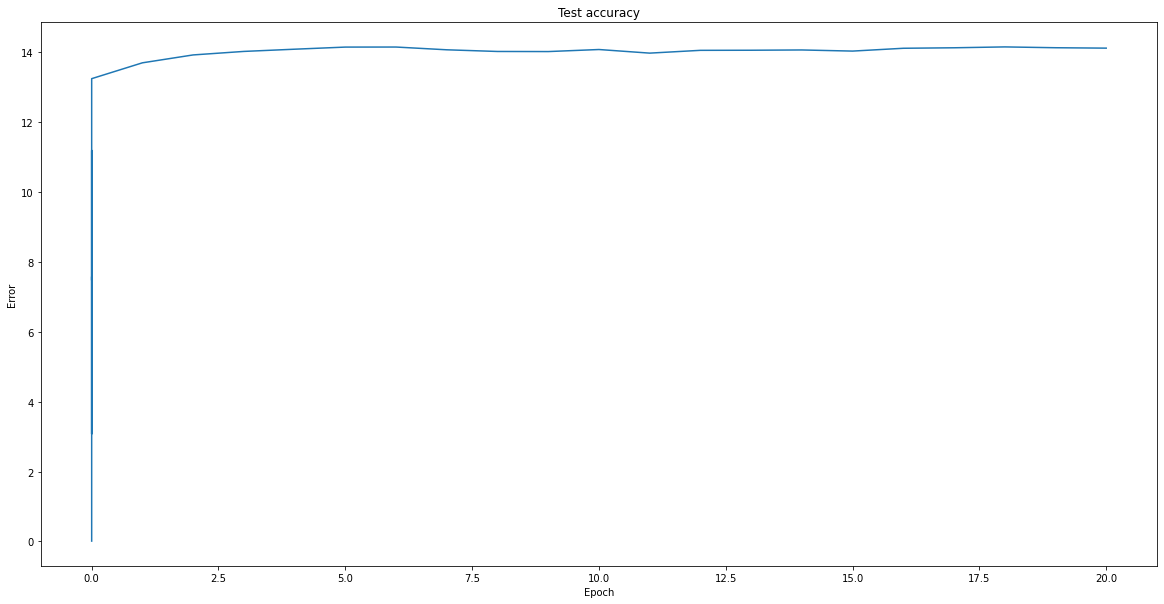

In [ ]:
# 6. Words
import string
def prepare_data_word(data_path, save='harry_potter_words', maximum_word=10000):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    # data.translate(str.maketrans('', '', string.punctuation))
    data = re.sub(r'[^\w\s]', '', data)
    data = data.lower()
    data = data.replace(',', '')
    data = data.replace('.', '')
    data = data.split()

    count = {}
    for word in data:
      if word not in count:
        count[word] = 0
      count[word] = count[word] + 1

    sorted = [(k, c) for k, c in count.items()]
    print(sorted)
    sorted.sort(reverse=True, key=lambda tup: tup[1])
    print(sorted)
    voc2ind = {}
    for word, c in sorted:
      idx = len(voc2ind)
      voc2ind[word] = idx
      if len(voc2ind) >= maximum_word:
        break
      
    out = []
    for word in data:
      if word in voc2ind:
        out.append(voc2ind[word])
      else:
        out.append(len(voc2ind))

    # Compute voc2ind and transform the data into an integer representation of the tokens.

    ind2voc = {val: key for key, val in voc2ind.items()}
    ind2voc[len(voc2ind)] = "<UNKNOWN>"

    size = int(len(out) * 0.8)
    train_text = np.array(out[:size]) # TODO Fill this in
    test_text = np.array(out[size:]) # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + save + '_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + save + '_test.pkl', 'wb'))
    
prepare_data_word(DATA_PATH + 'harry_potter.txt')


class VocabularyWord(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        l = [self.voc2ind[word] if word in self.voc2ind else len(self.voc2ind) for word in words]
        return torch.LongTensor(l)

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind) + 1

class HarryPotterWordDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterWordDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = VocabularyWord(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        self.tokens = dataset['tokens']
        self.len = int(((len(self.tokens) - 1) // self.sequence_length // self.batch_size) * self.batch_size)

    def __len__(self):
        return self.len
        
    def __getitem__(self, idx): 
        start = self.sequence_length * idx
        data = self.tokens[start : start+self.sequence_length]
        label = self.tokens[start+1 : start+self.sequence_length+1]
        return data, label

    def vocab_size(self):
        return len(self.vocab)

def generate_language_word(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()
    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)
        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, device)
        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)
        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab, device)
        return seed_words + " " + vocab.array_to_words(outputs)

def word():
    SEQUENCE_LENGTH = 32
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log-words.pkl'


    data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    print(len(vocab))
    print(data_train[0][0])
    print(vocab.array_to_words(data_train[0][0]))

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints-words')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints-words/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language_word(model, device, seed_words, 32, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language_word(model, device, seed_words, 32, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language_word(model, device, seed_words, 16, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints-words/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = word()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    